# XAI

**변수 설명**
* `A10 Autism Spectrum Quotient` : AQ-10으로 불리는 시험으로 10개의 문항을 가지고 자폐인인지 판단할 수 있는 참고용 설문지. 수치형(0, 1)
* `Social Responsiveness Scale` : 부모나 교사에게 아동이 보인 사회적 상호작용의 특징에 대해 질문하는 설문지로, 점수가 높을수록 사회적 기능이 낮음을 의미. 수치형(0 ~ 10)
* `Age_Years` : 나이. 수치형(1 ~ 18)
* `Qchat_10_Score` : AQ-10 10문항의 합(총점). 수치형(0 ~ 10)
* `Speech Delay/Language Disorder` : 말하거나 언어에 대한 지연 및 장애. 논리값
* `Learning disorder` : 배우는데 존재한 장애. 논리값
* `Genetic Disorders` : 장애에 대한 유전. 논리값
* `Depression` : 우울함. 논리값
* `Global developmental delay/intellectual disability` : 전반적인 발달 지연 및 지적 장애. 논리값
* `Social/Behavioural Issues` : 사회적, 행동적 문제
* `Childhood Autism Rating Scale` : 부모가 쉽게 이용할 수 있는 자폐 진단 테스트의 점수. 수치형(1 ~ 4)
* `Anxiety disorder` : 불안 장애. 논리값
* `Sex` : 성별. 범주형(M, F)
* `Ethnicity` : 인종. 범주형(Asian, Black, Hispanic, Latino, Middle Eastern, Mixed, Native Indian, Others, PaciFica, South Asian, White European)
* `Jaundice` : 황달. 논리값
* `Family mem with ASD` : 가족 구성원 중 ASD를 가지고 있는지 여부. 논리값
* `Who completed the test` : 테스트를 진행한 사람. 범주형(Family Memeber, Health Care Professional, Others, School and NGO, Self)
* **`ASD traits`** : ASD 여부

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from pycaret.classification import *
import matplotlib.pyplot as plt
from pdpbox import info_plots
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import shap
import logging

logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)
seed = 10
np.random.seed(10)

In [2]:
df = pd.read_csv("/home/jovyan/work/_dataset/data_csv.csv")
df.head()

CASE_NO_PATIENT'S  A1  A2  A3  A4  A5  A6  A7  A8  A9  ...  \
0                  1   0   0   0   0   0   0   1   1   0  ...   
1                  2   1   1   0   0   0   1   1   0   0  ...   
2                  3   1   0   0   0   0   0   1   1   0  ...   
3                  4   1   1   1   1   1   1   1   1   1  ...   
4                  5   1   1   0   1   1   1   1   1   1  ...   

   Global developmental delay/intellectual disability  \
0                                                Yes    
1                                                Yes    
2                                                Yes    
3                                                Yes    
4                                                Yes    

   Social/Behavioural Issues  Childhood Autism Rating Scale  Anxiety_disorder  \
0                        Yes                              1               Yes   
1                        Yes                              2               Yes   
2                        Yes                              4               Yes   
3                        Yes                              2               Yes   
4                        Yes                              1               Yes   

  Sex       Ethnicity Jaundice Family_mem_with_ASD Who_completed_the_test  \
0   F  middle eastern      Yes                  No          Family Member   
1   M  White European      Yes                  No          Family Member   
2   M  Middle Eastern      Yes                  No          Family Member   
3   M        Hispanic       No                  No          Family Member   
4   F  White European       No                  No          Family Member   

  ASD_traits  
0         No  
1        Yes  
2        Yes  
3        Yes  
4        Yes  

[5 rows x 28 columns]

### 결측치 제거

In [3]:
df.drop("CASE_NO_PATIENT'S", axis=1, inplace=True) # 환자 ID 제거

In [4]:
df = df.dropna(axis=0)

In [5]:
df.isnull().sum()

A1                                                    0
A2                                                    0
A3                                                    0
A4                                                    0
A5                                                    0
A6                                                    0
A7                                                    0
A8                                                    0
A9                                                    0
A10_Autism_Spectrum_Quotient                          0
Social_Responsiveness_Scale                           0
Age_Years                                             0
Qchat_10_Score                                        0
Speech Delay/Language Disorder                        0
Learning disorder                                     0
Genetic_Disorders                                     0
Depression                                            0
Global developmental delay/intellectual disabili

### 범주형 변수 수치형으로 변환

Ethnicity, Who_completed_the_test 변수 범주 통합

In [6]:
# Ethnicity이 Asian, asian 이렇게 분리된 경우가 있어서 이를 통합
new_ethnicity = list(map(str.upper, df['Ethnicity'].to_list()))

# Who_completed_the_test 변수도 분리되어 있어서 이를 통합
new_who_completed = list(map(str.upper, df['Who_completed_the_test'].to_list()))

# dataset 생성
dataset = df.copy()

Ethnicity, Who_completed_the_test 변수 수치형으로 변환

In [7]:
encoder = OrdinalEncoder()

# Ethnicity 변환
new_ethnicity = encoder.fit_transform(np.array(new_ethnicity).reshape(-1, 1))
dataset['Ethnicity'] = new_ethnicity

# Who_completed_the_test 변환
new_who_completed = encoder.fit_transform(np.array(new_who_completed).reshape(-1, 1))
dataset['Who_completed_the_test'] = new_who_completed

Yes, No 변수 수치형으로 변환 & 성별 수치형으로 변환

In [8]:
yes_no_columns = ['Social_Responsiveness_Scale', 'Speech Delay/Language Disorder', 'Learning disorder', 'Genetic_Disorders', 'Depression', 'Global developmental delay/intellectual disability', 'Social/Behavioural Issues', 'Anxiety_disorder', 'Jaundice', 'Family_mem_with_ASD', 'ASD_traits']

for column in yes_no_columns:
    dataset[column] = dataset[column].replace({'Yes': 1.0, 'No': 0.0})

# 성별 수치형 변환
dataset['Sex'] = dataset['Sex'].replace({'M': 0.0, 'F': 1.0})

### 최종 데이터셋

In [9]:
dataset.head()

A1  A2  A3  A4  A5  A6  A7  A8  A9  A10_Autism_Spectrum_Quotient  ...  \
0   0   0   0   0   0   0   1   1   0                             1  ...   
1   1   1   0   0   0   1   1   0   0                             0  ...   
2   1   0   0   0   0   0   1   1   0                             1  ...   
3   1   1   1   1   1   1   1   1   1                             1  ...   
4   1   1   0   1   1   1   1   1   1                             1  ...   

   Global developmental delay/intellectual disability  \
0                                                1.0    
1                                                1.0    
2                                                1.0    
3                                                1.0    
4                                                1.0    

   Social/Behavioural Issues  Childhood Autism Rating Scale  Anxiety_disorder  \
0                        1.0                              1               1.0   
1                        1.0                              2               1.0   
2                        1.0                              4               1.0   
3                        1.0                              2               1.0   
4                        1.0                              1               1.0   

   Sex  Ethnicity  Jaundice  Family_mem_with_ASD  Who_completed_the_test  \
0  1.0        4.0       1.0                  0.0                     0.0   
1  0.0       10.0       1.0                  0.0                     0.0   
2  0.0        4.0       1.0                  0.0                     0.0   
3  0.0        2.0       0.0                  0.0                     0.0   
4  1.0       10.0       0.0                  0.0                     0.0   

   ASD_traits  
0         0.0  
1         1.0  
2         1.0  
3         1.0  
4         1.0  

[5 rows x 27 columns]

### 변수 중요도

In [10]:
X_train = dataset.drop('ASD_traits', axis=1)
y_train = dataset['ASD_traits']

In [11]:
rf = RandomForestClassifier(n_estimators = 100, random_state = seed, max_features='sqrt')
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=10)

In [12]:
importances = pd.Series(rf.feature_importances_, X_train.columns)

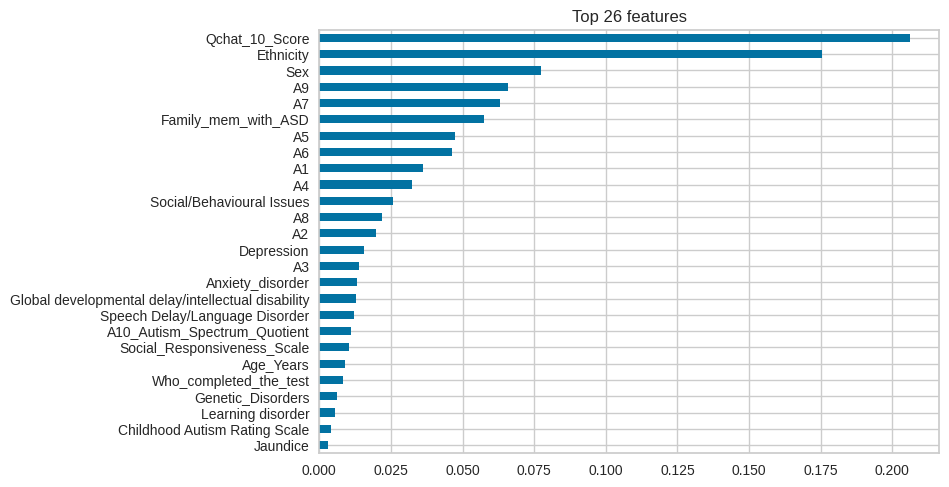

In [13]:
n = X_train.shape[1]
plt.title(f"Top {n} features")
importances.sort_values().tail(n).plot.barh()
plt.show()

### PDP

In [14]:
X_train = dataset.drop('ASD_traits', axis=1)
y_train = dataset['ASD_traits']

print(X_train.columns)

Index(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9',
       'A10_Autism_Spectrum_Quotient', 'Social_Responsiveness_Scale',
       'Age_Years', 'Qchat_10_Score', 'Speech Delay/Language Disorder',
       'Learning disorder', 'Genetic_Disorders', 'Depression',
       'Global developmental delay/intellectual disability',
       'Social/Behavioural Issues', 'Childhood Autism Rating Scale',
       'Anxiety_disorder', 'Sex', 'Ethnicity', 'Jaundice',
       'Family_mem_with_ASD', 'Who_completed_the_test'],
      dtype='object')


In [15]:
rf = RandomForestClassifier(n_estimators = 100, random_state = seed, max_features='sqrt')
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=10)

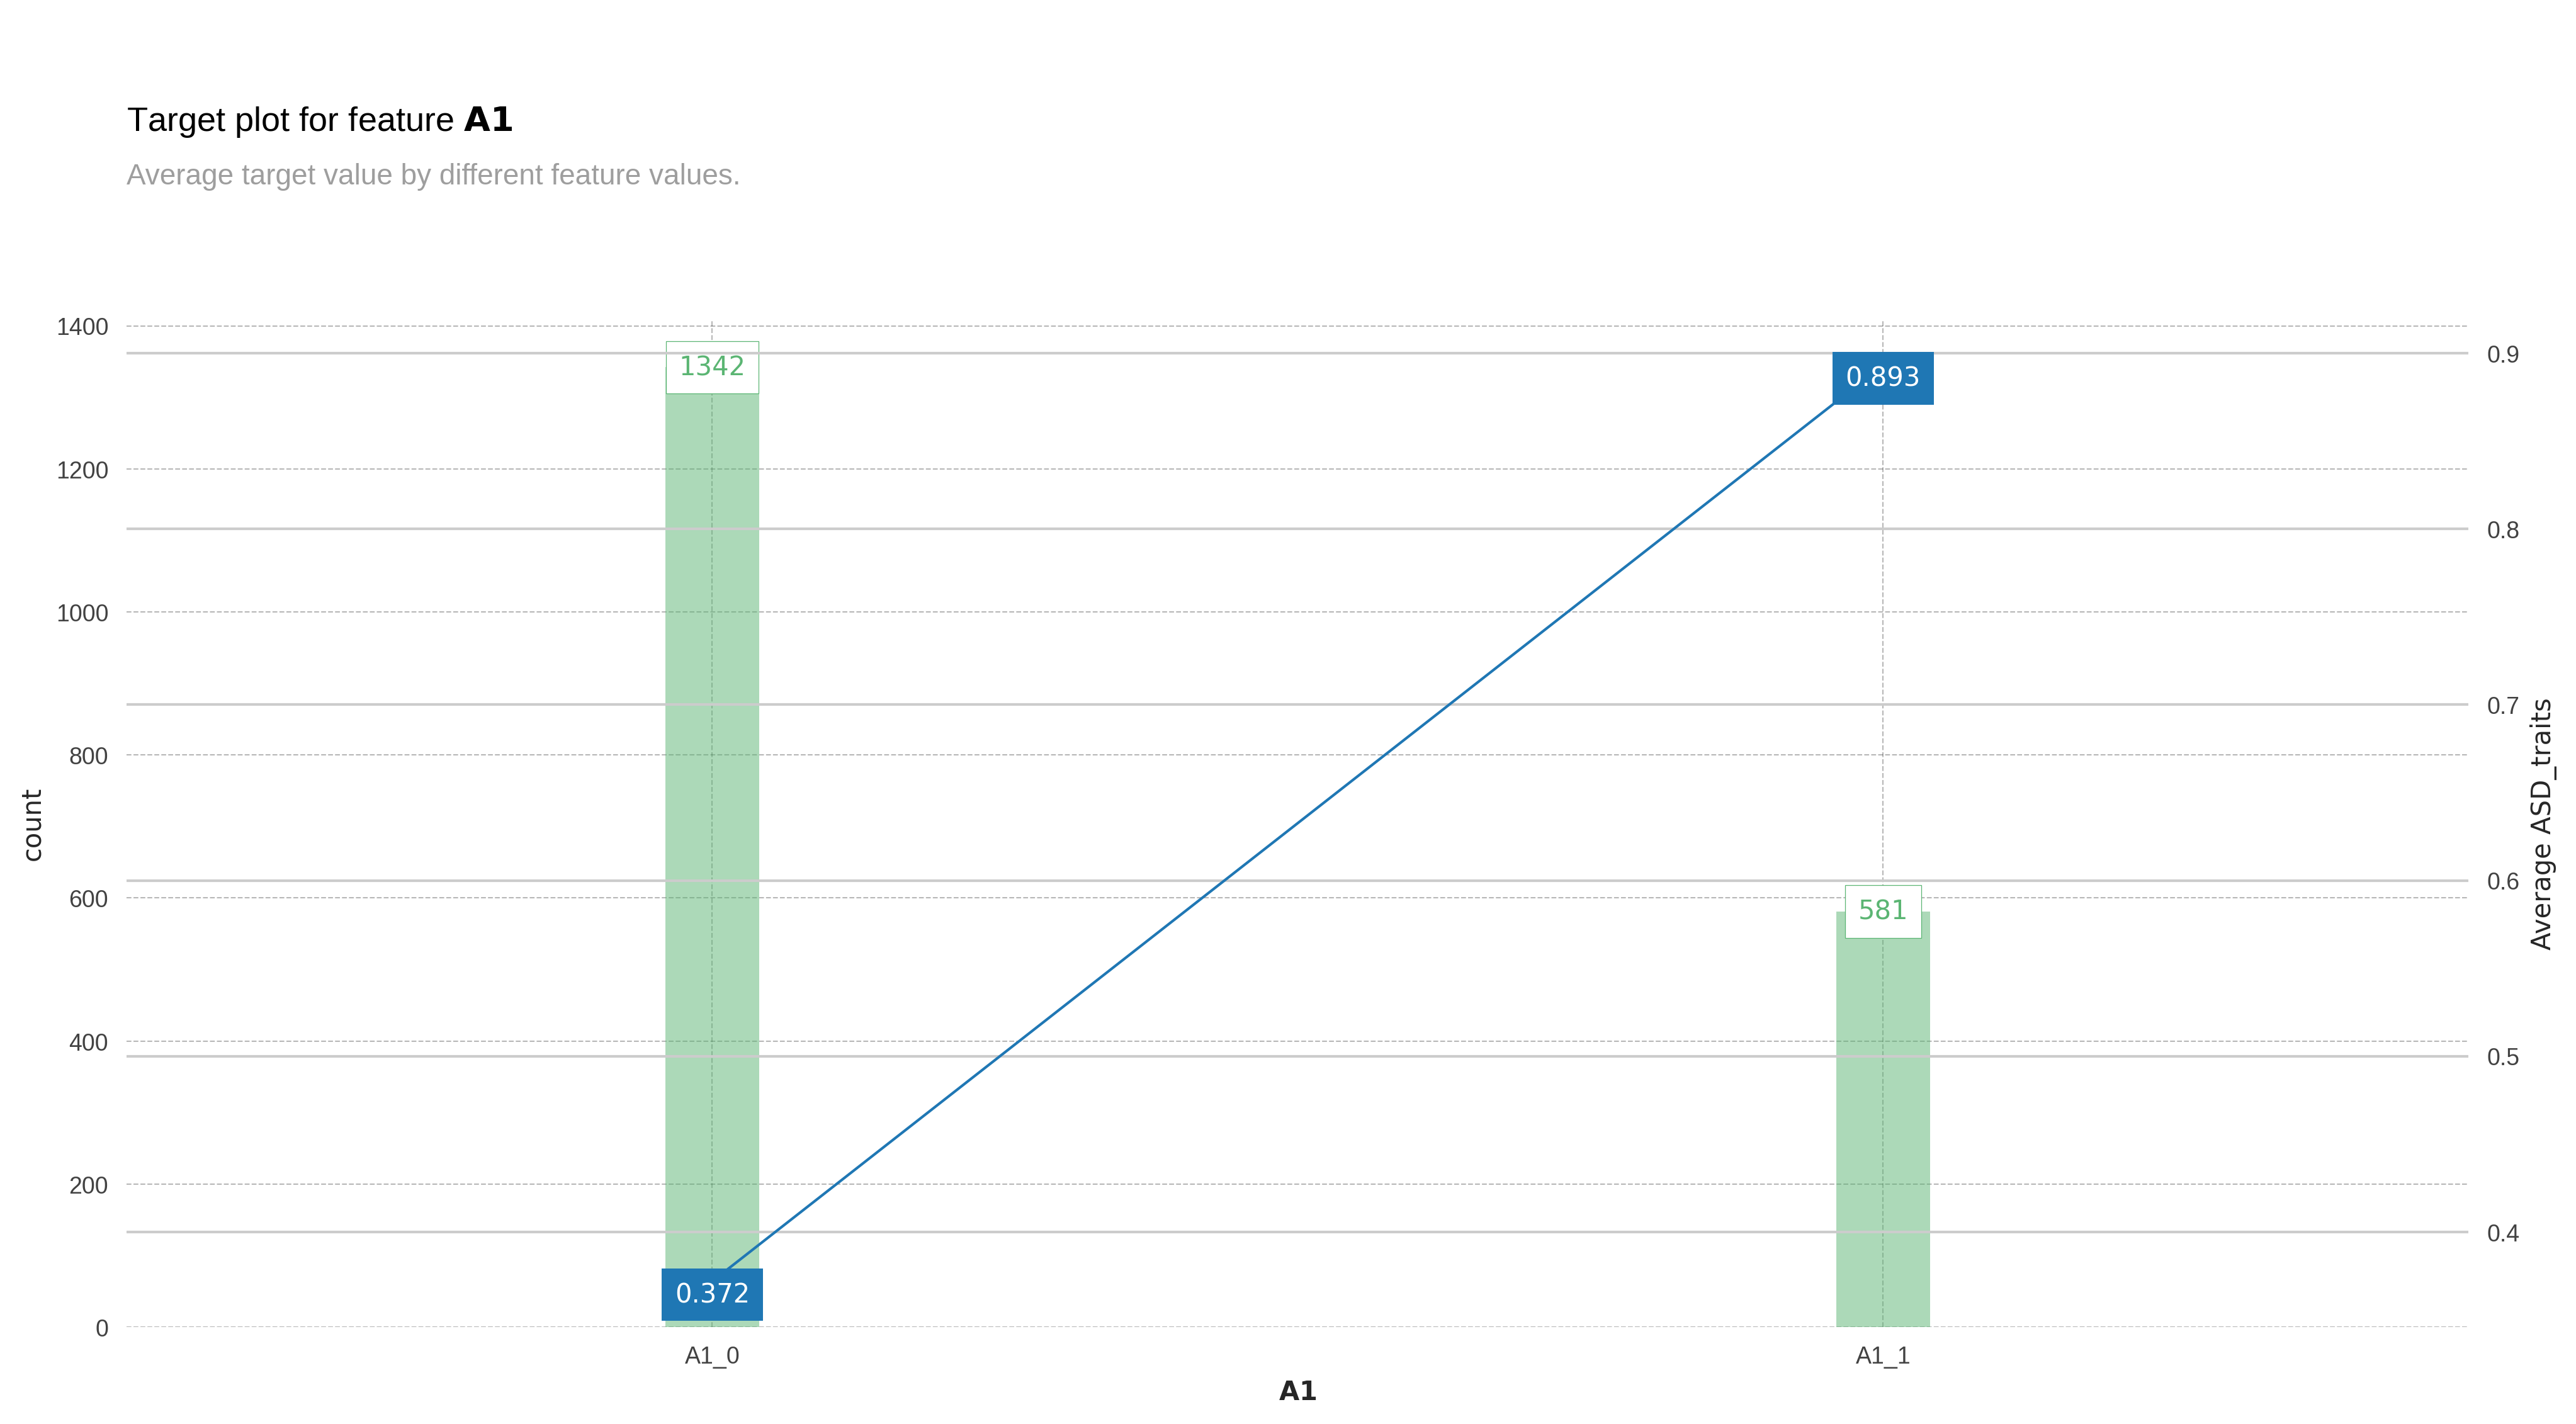

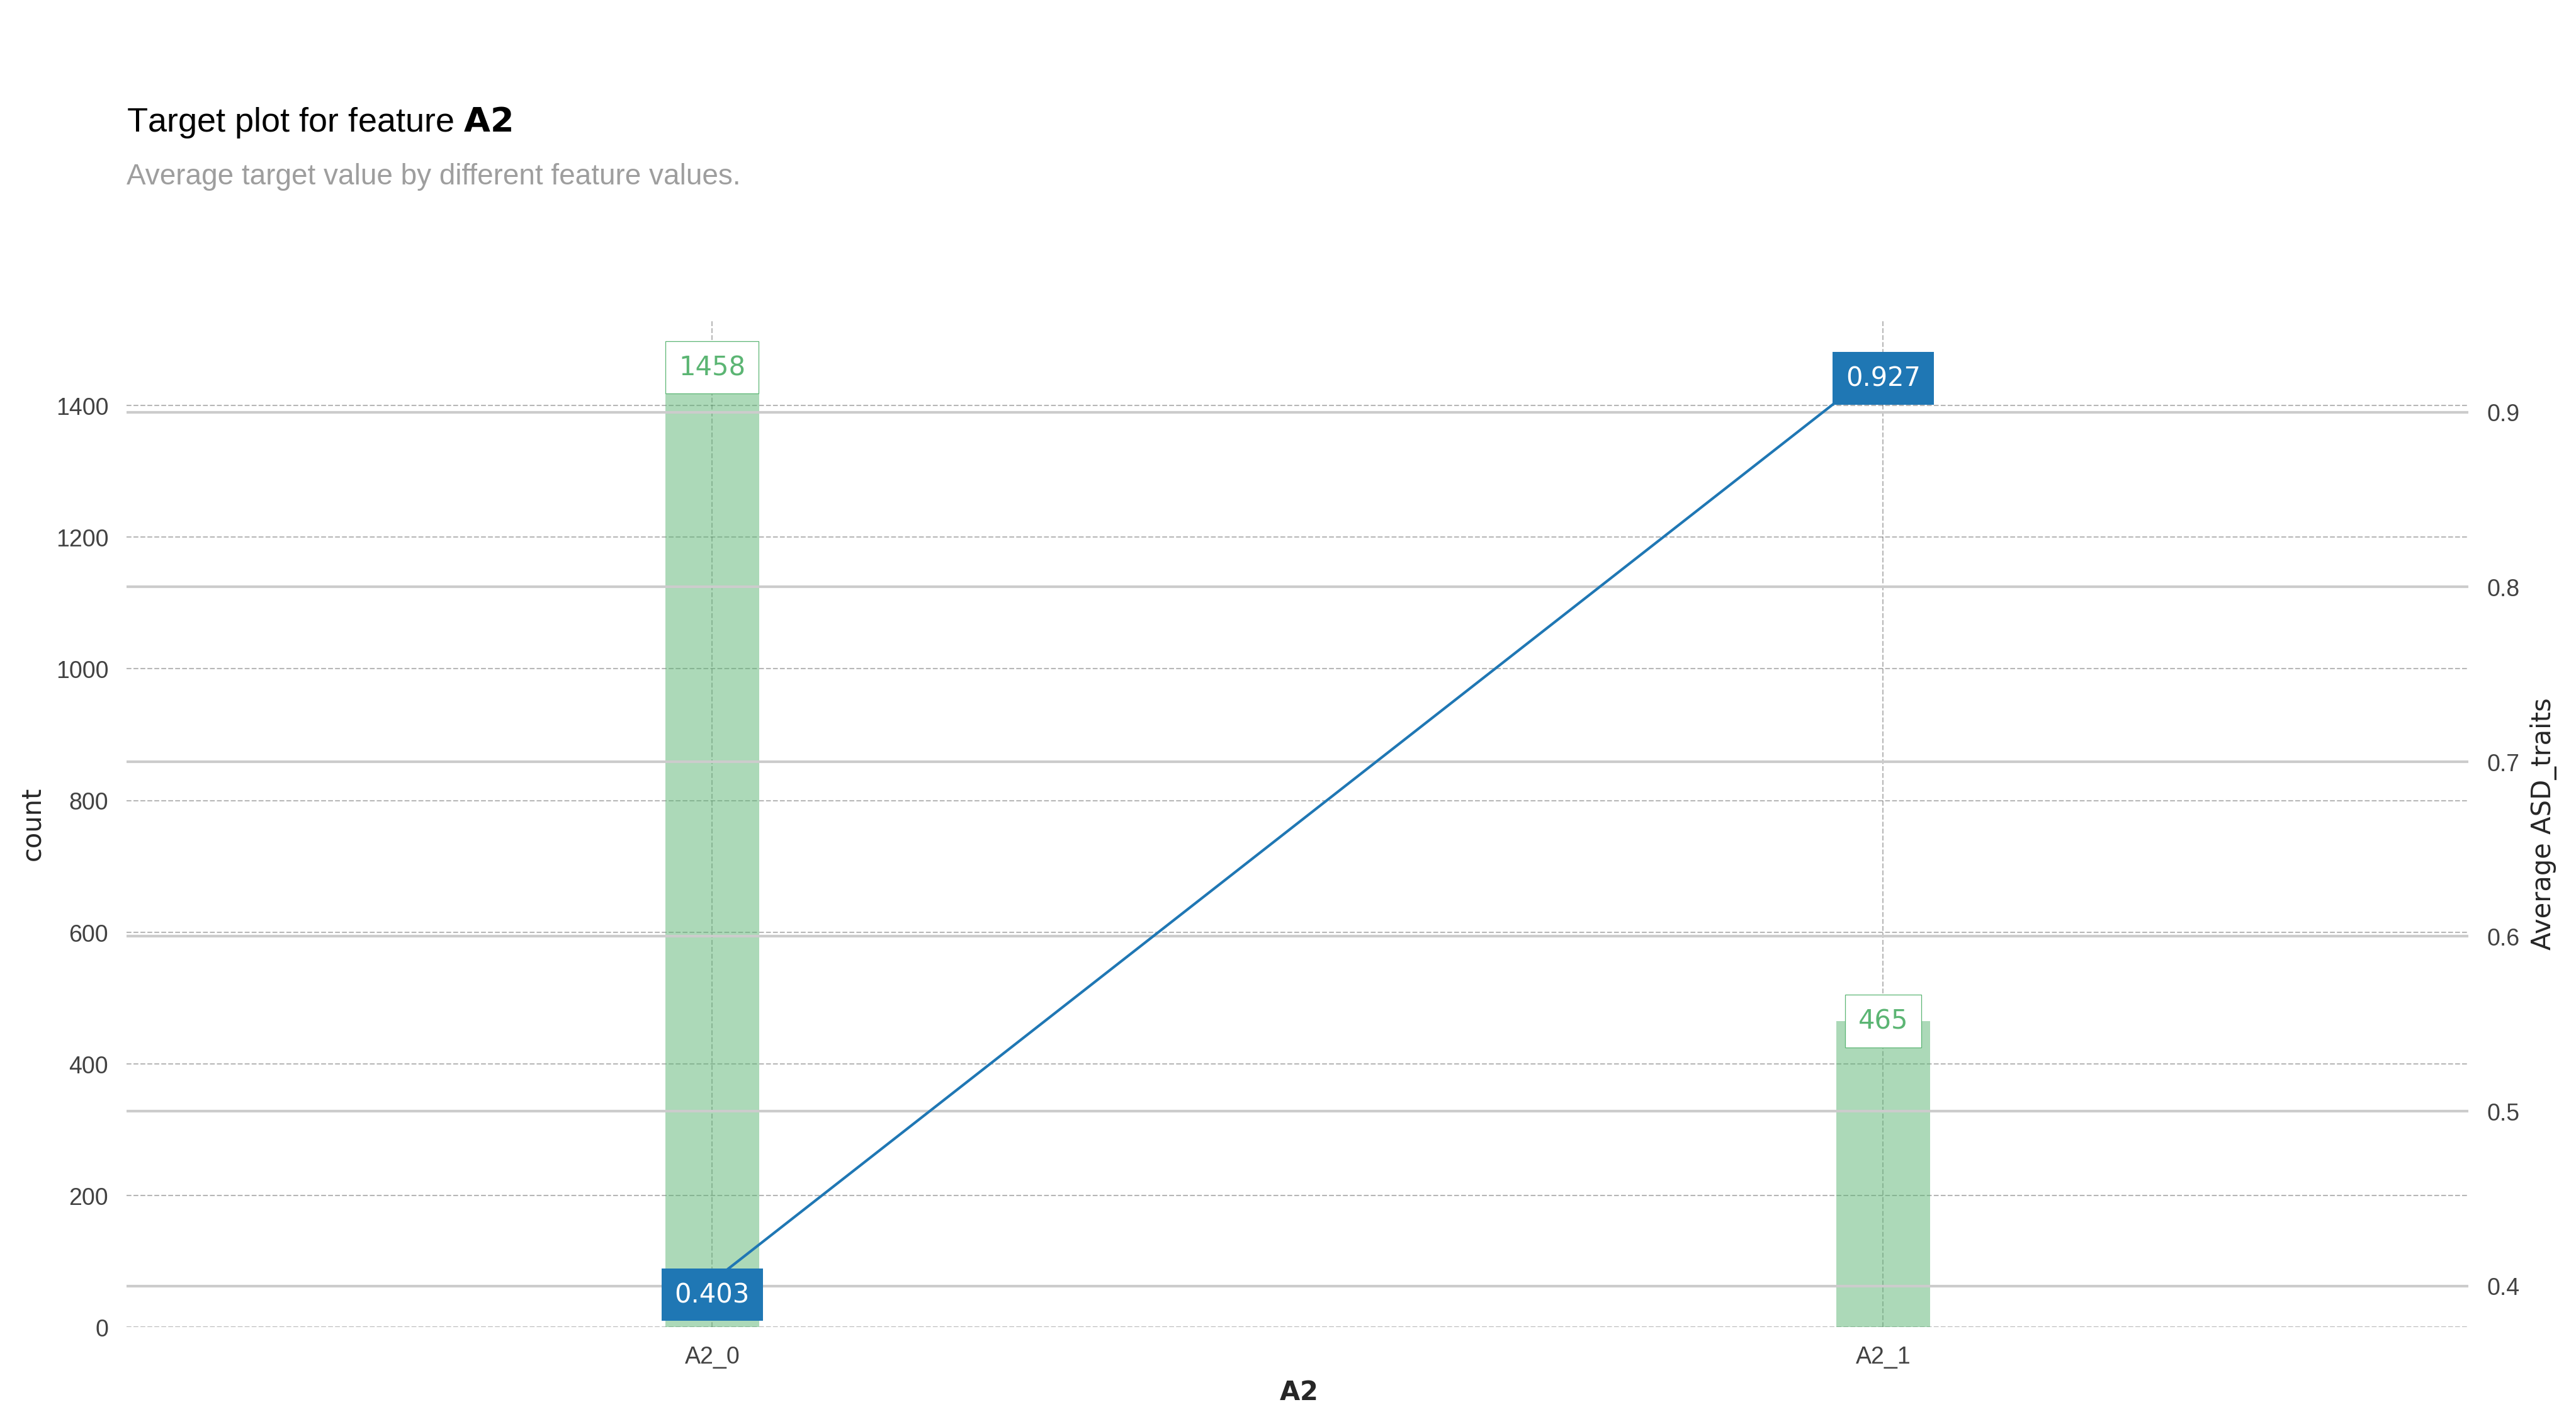

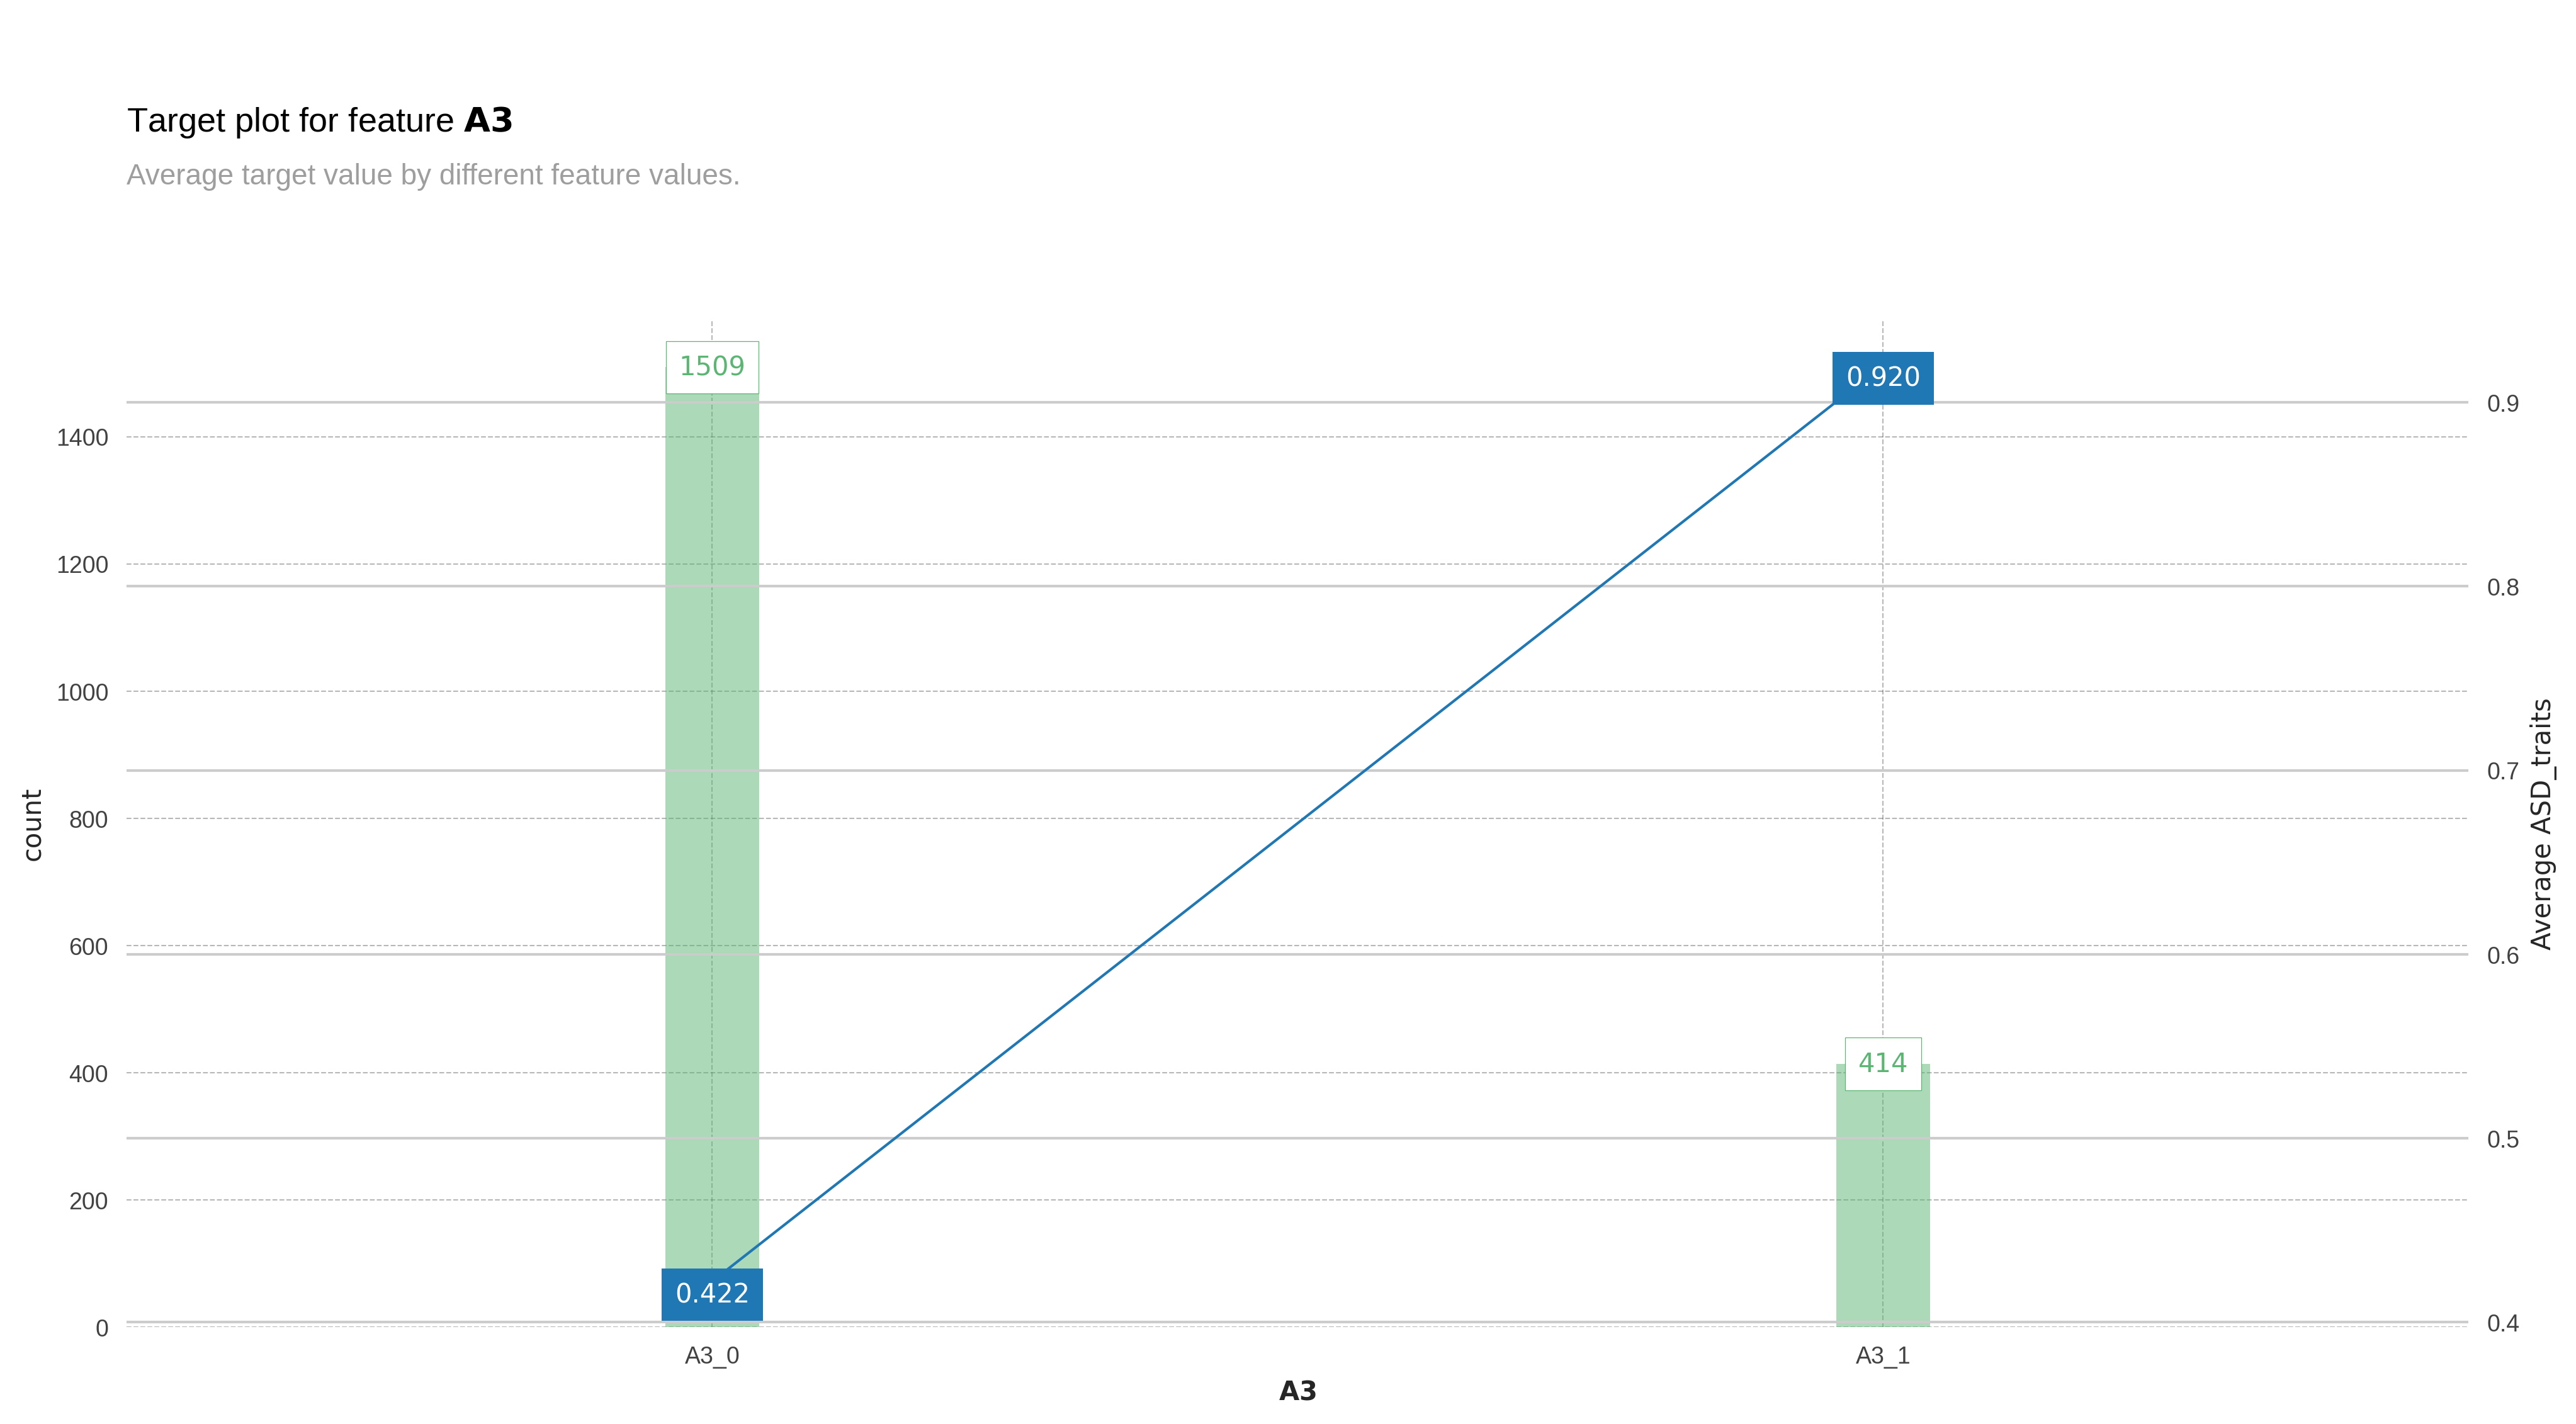

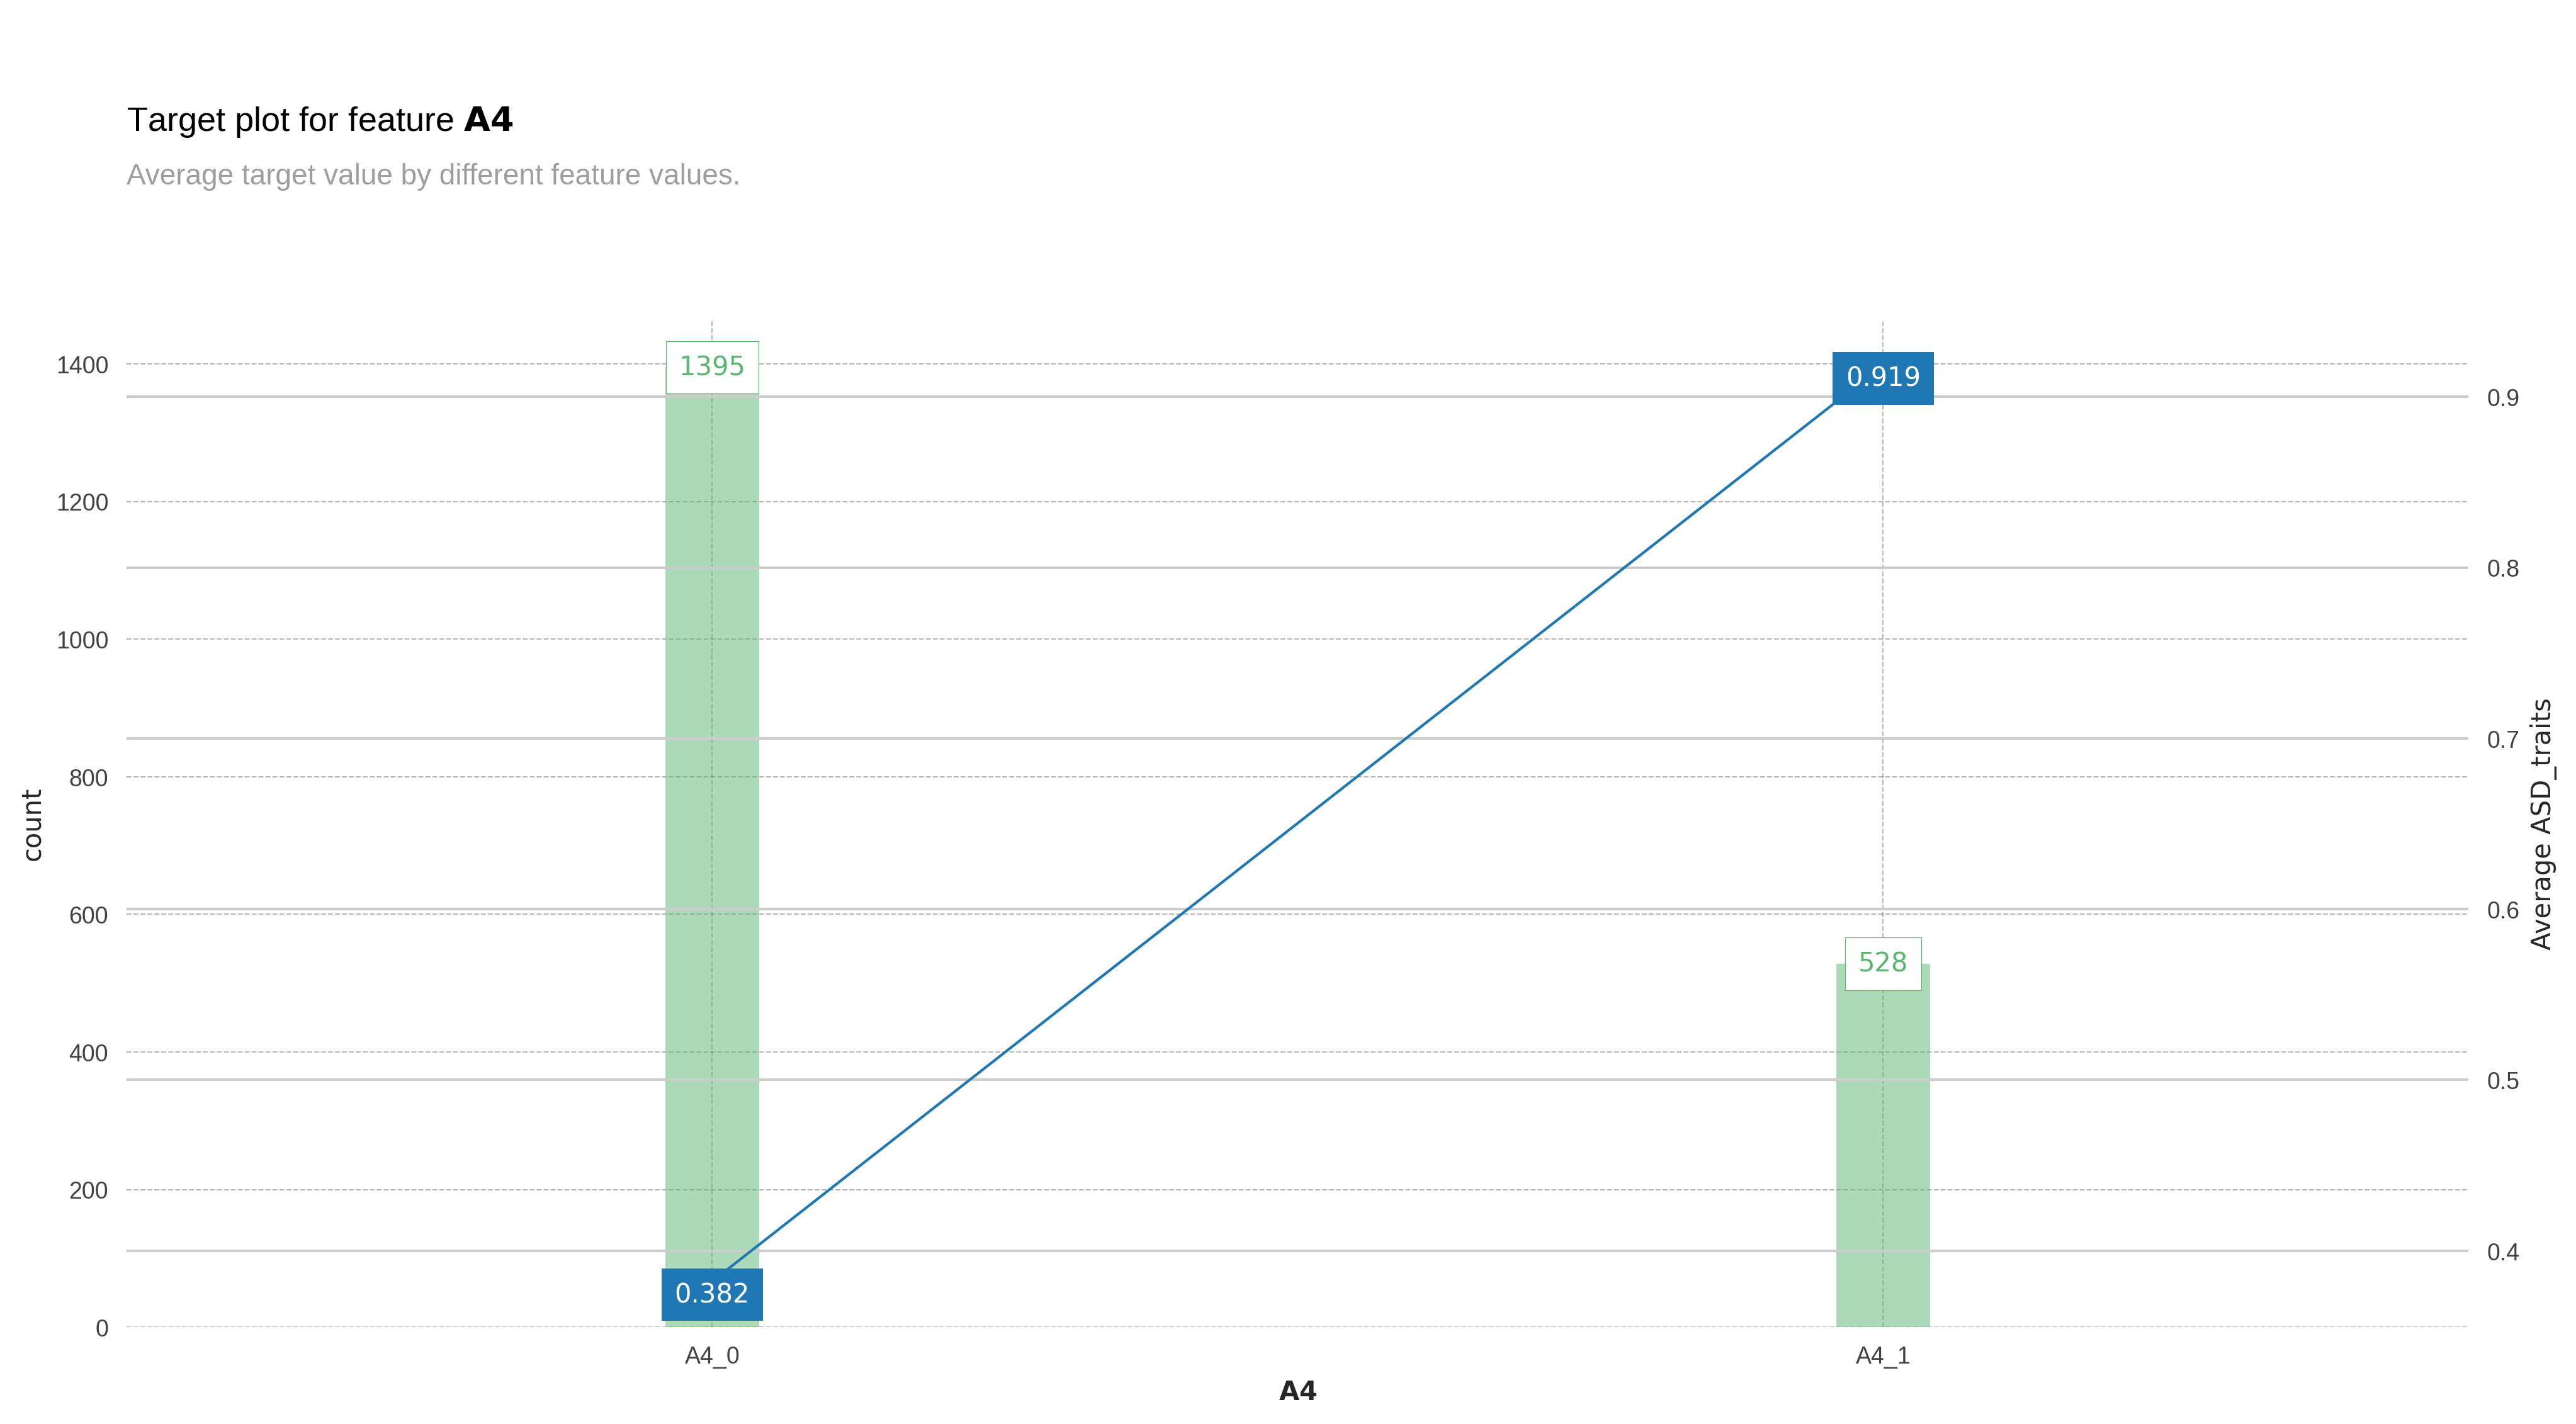

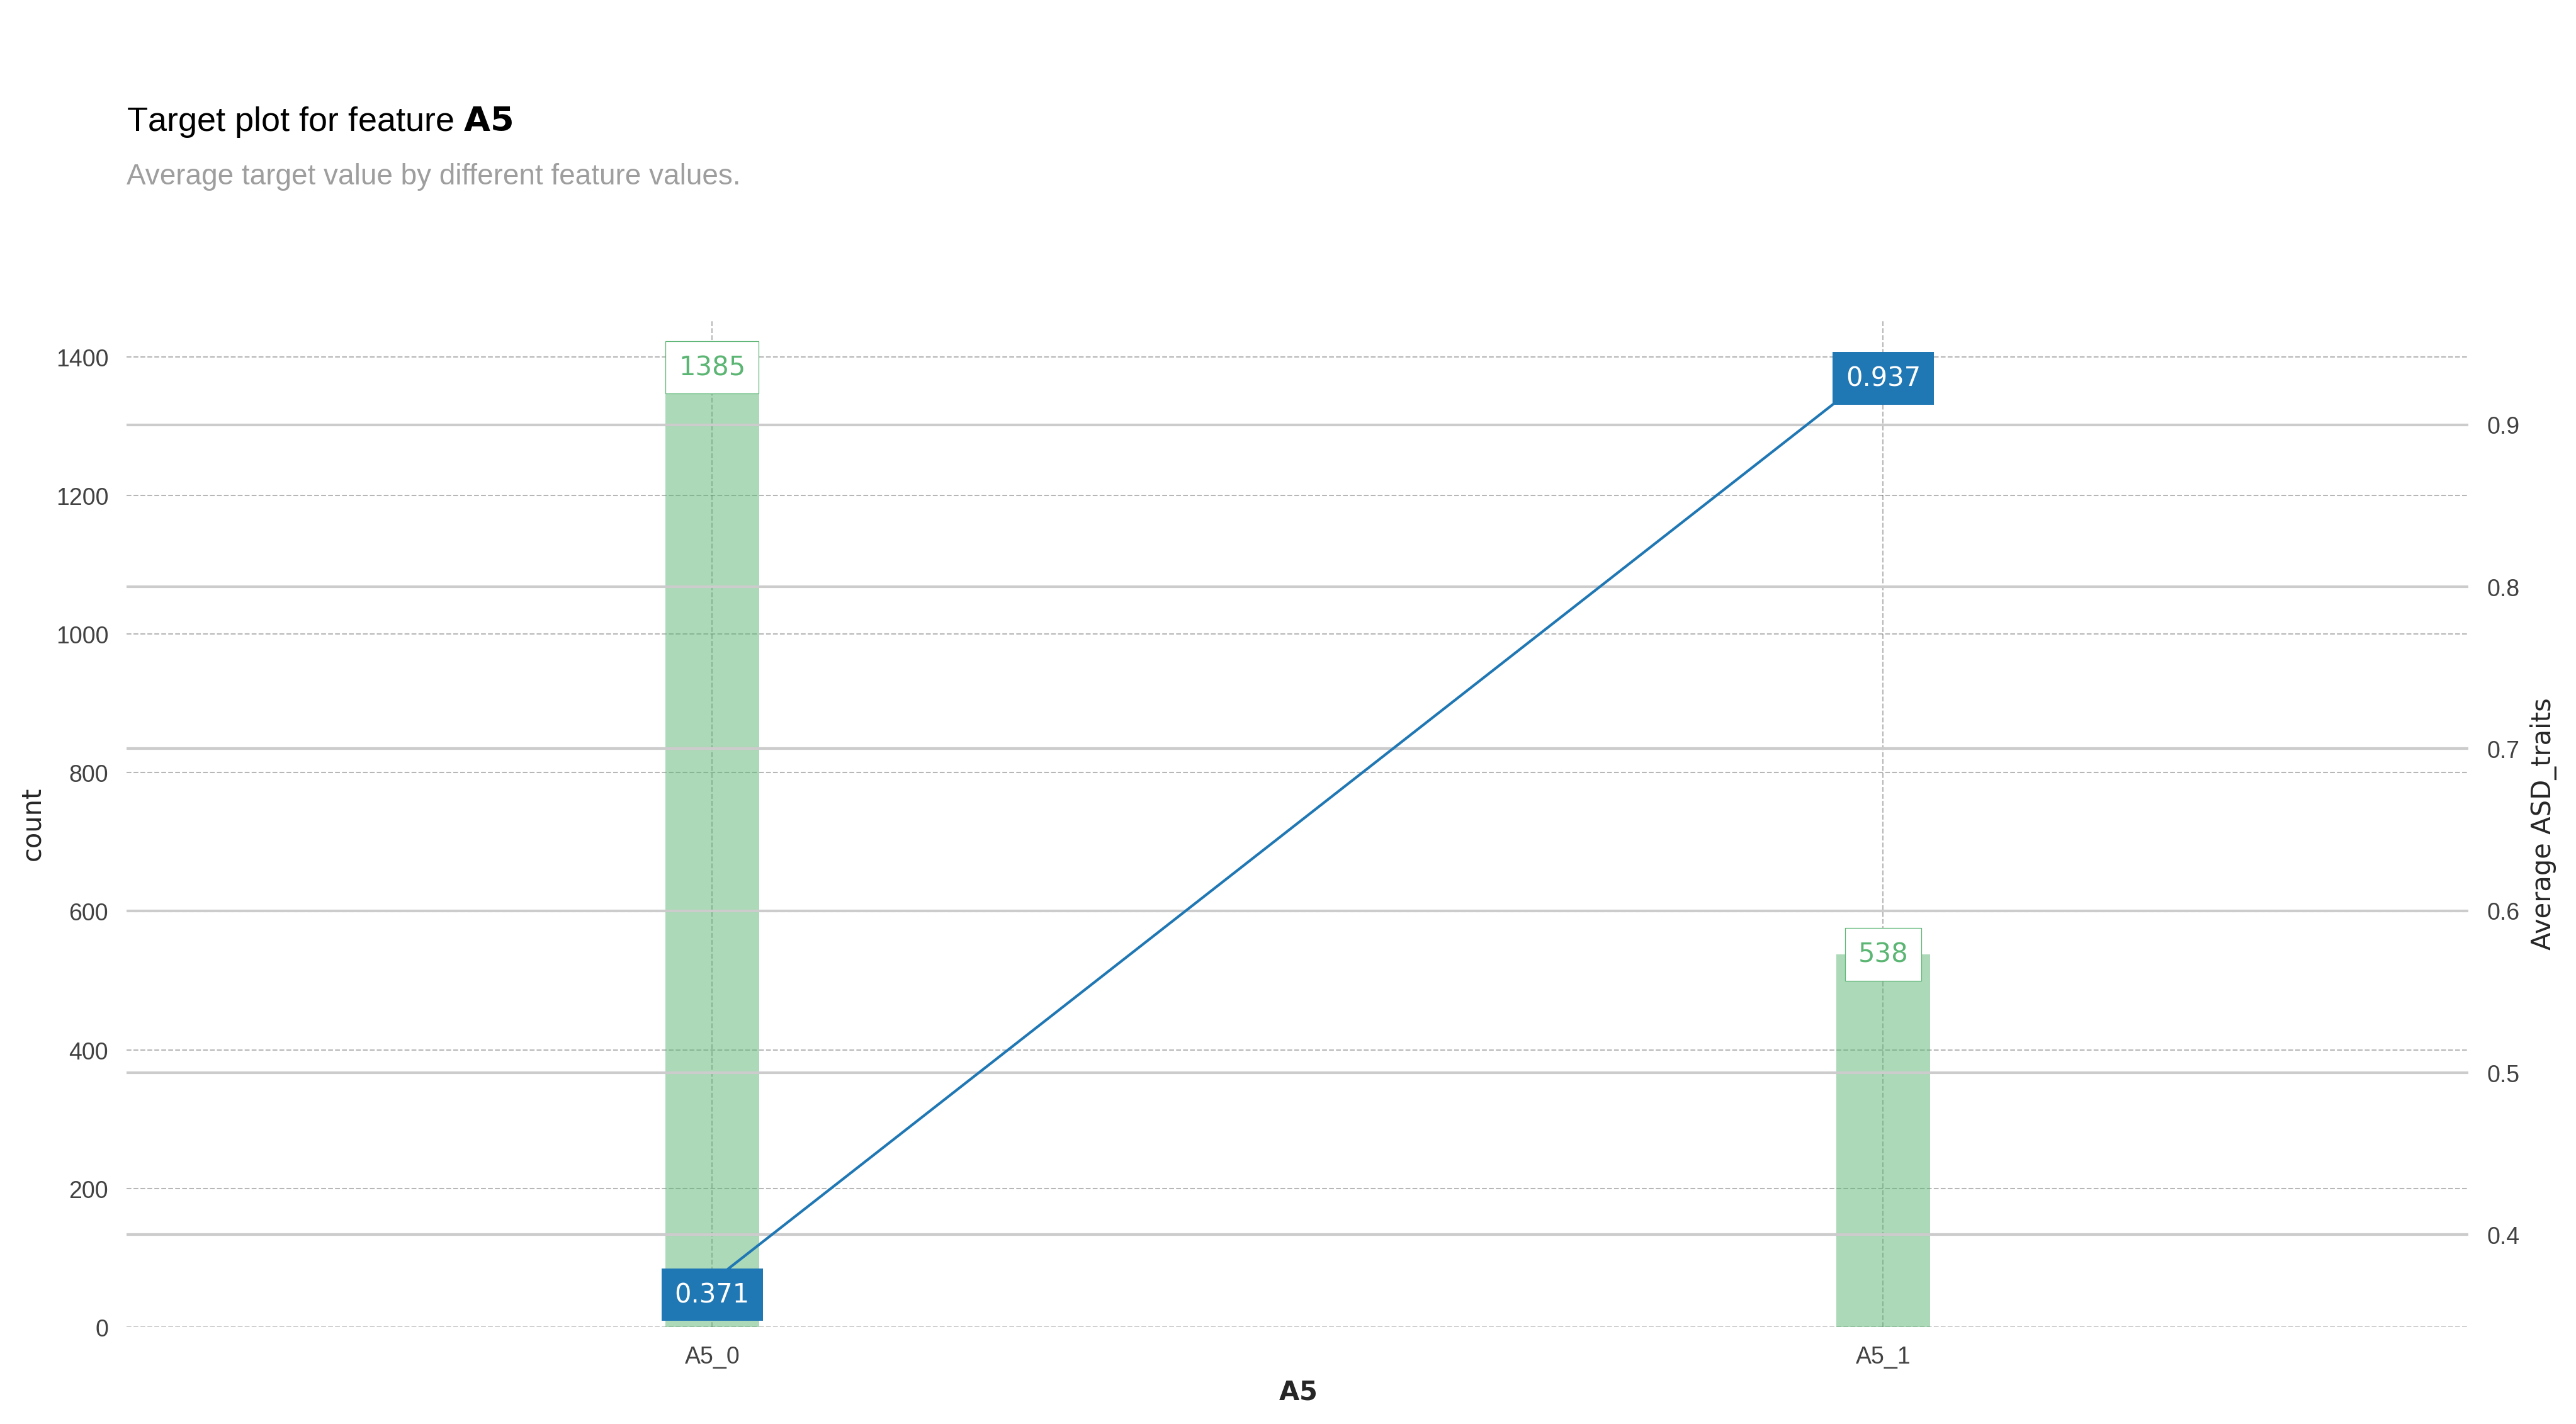

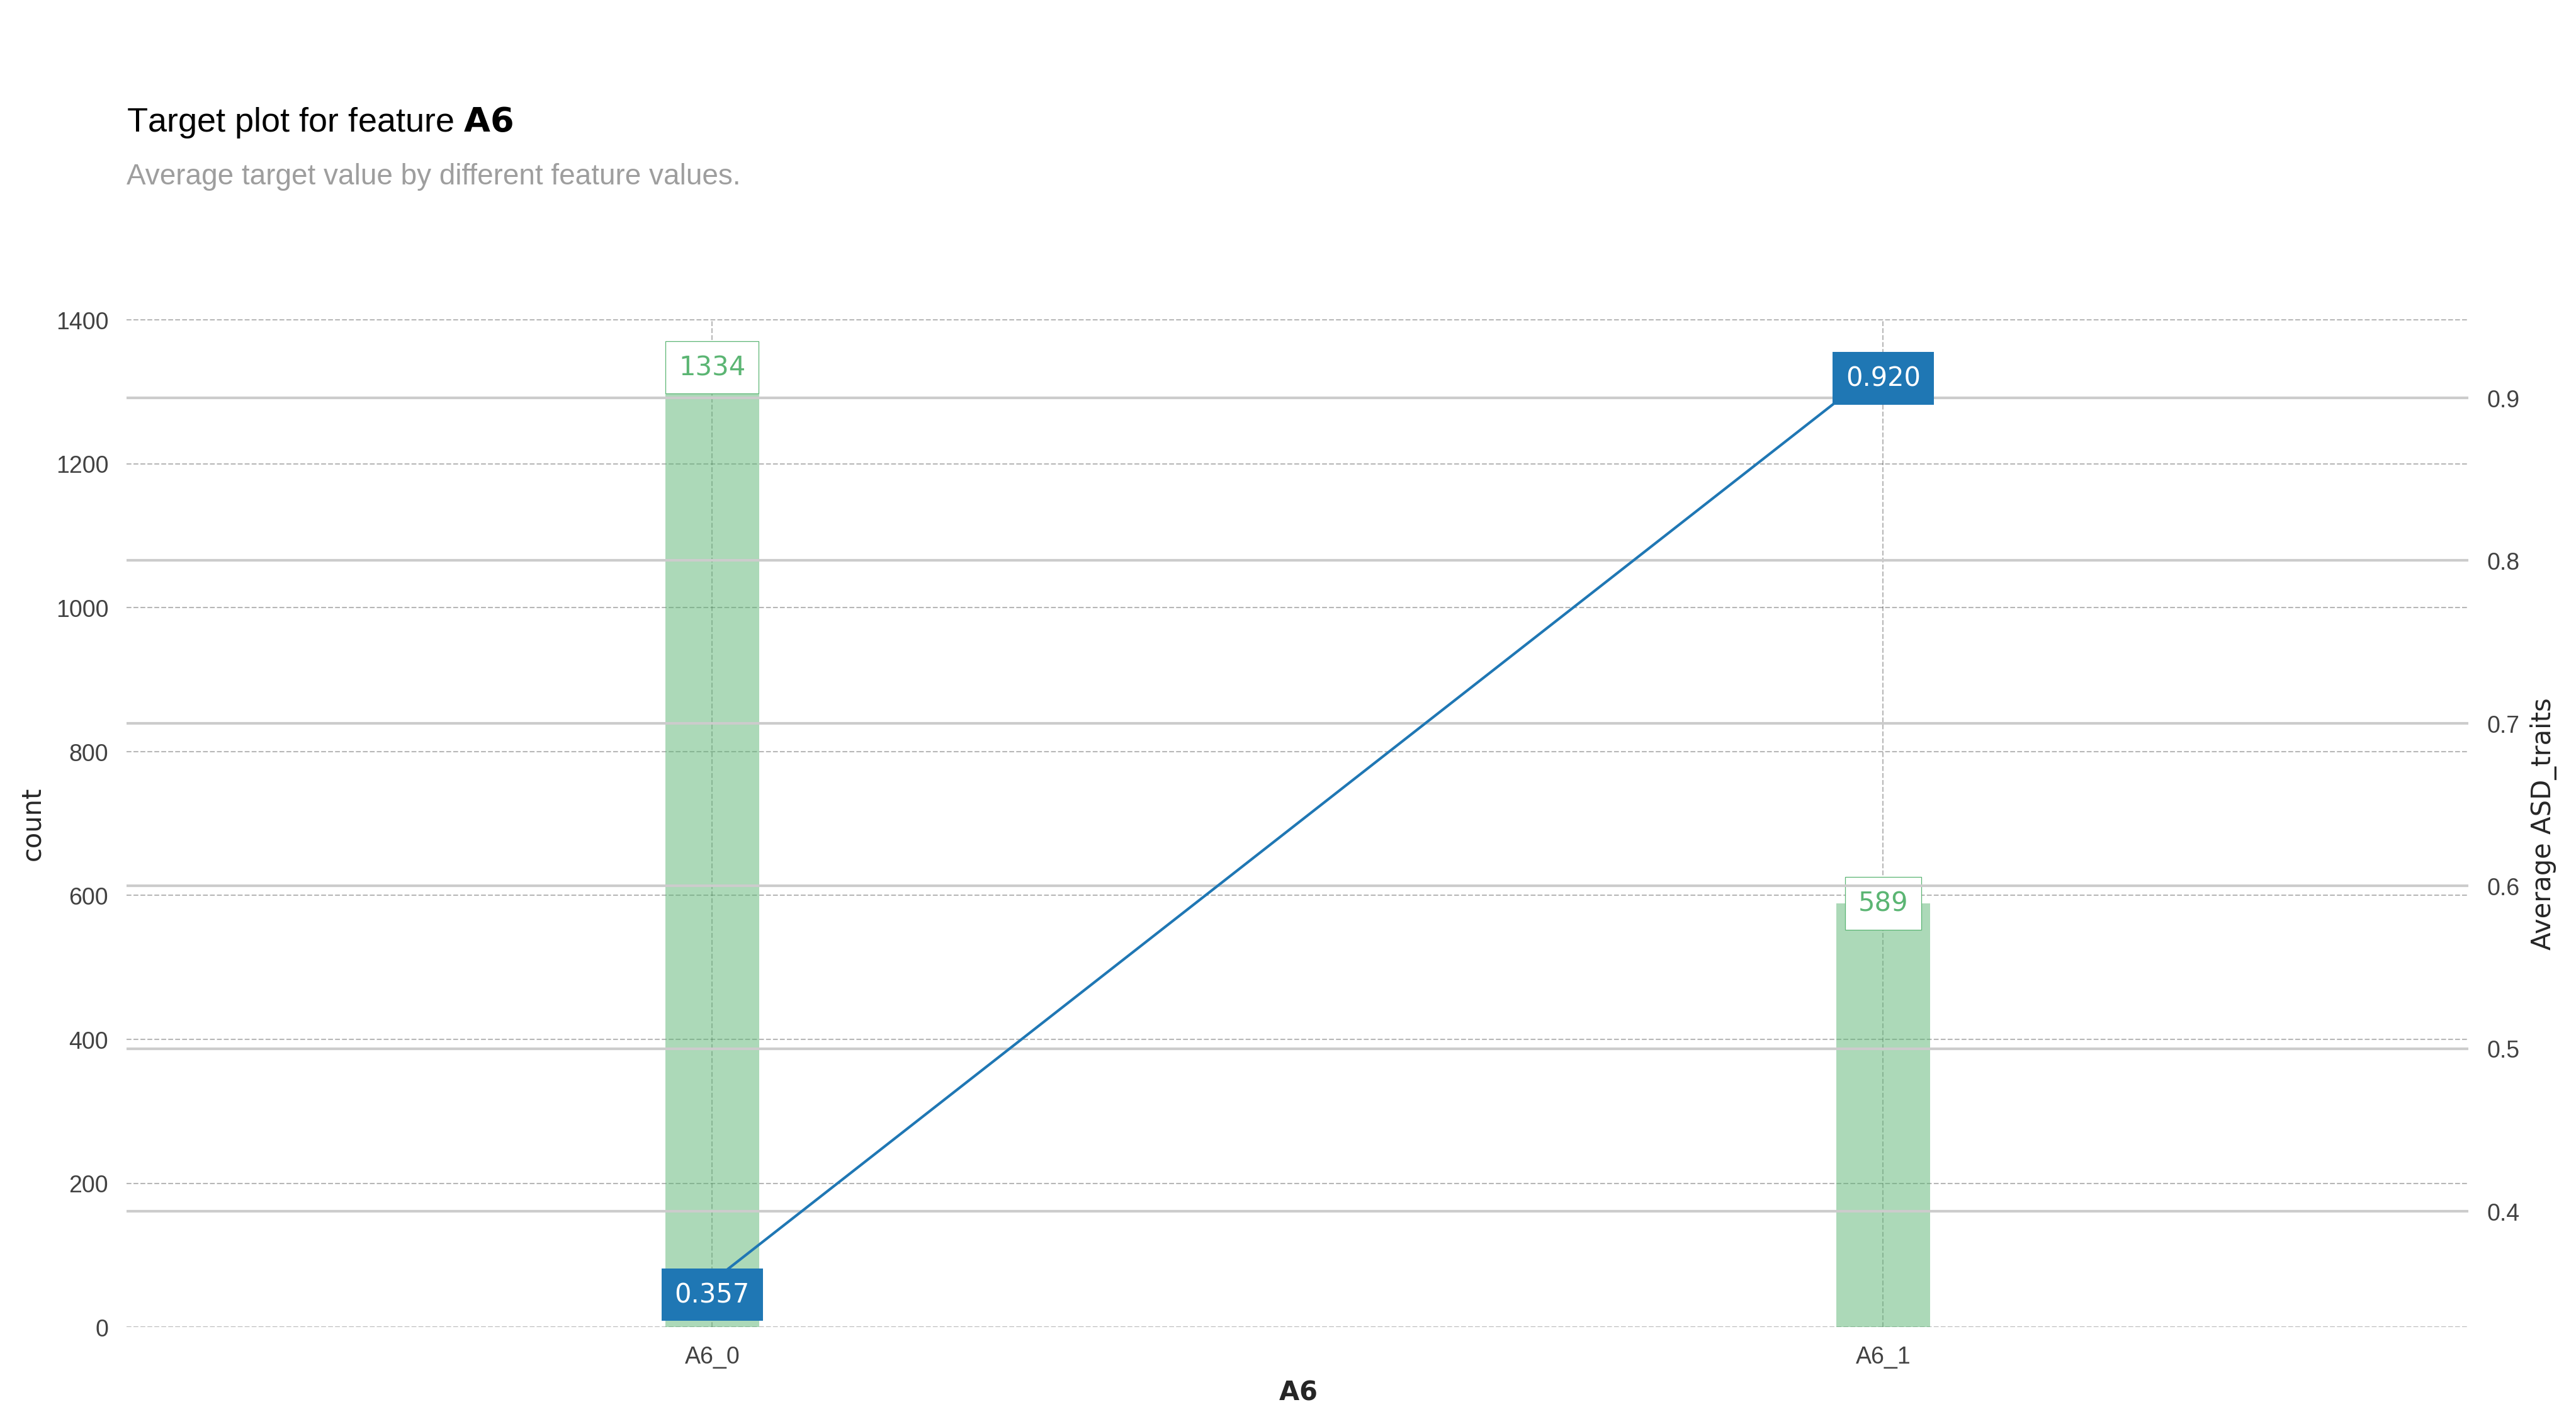

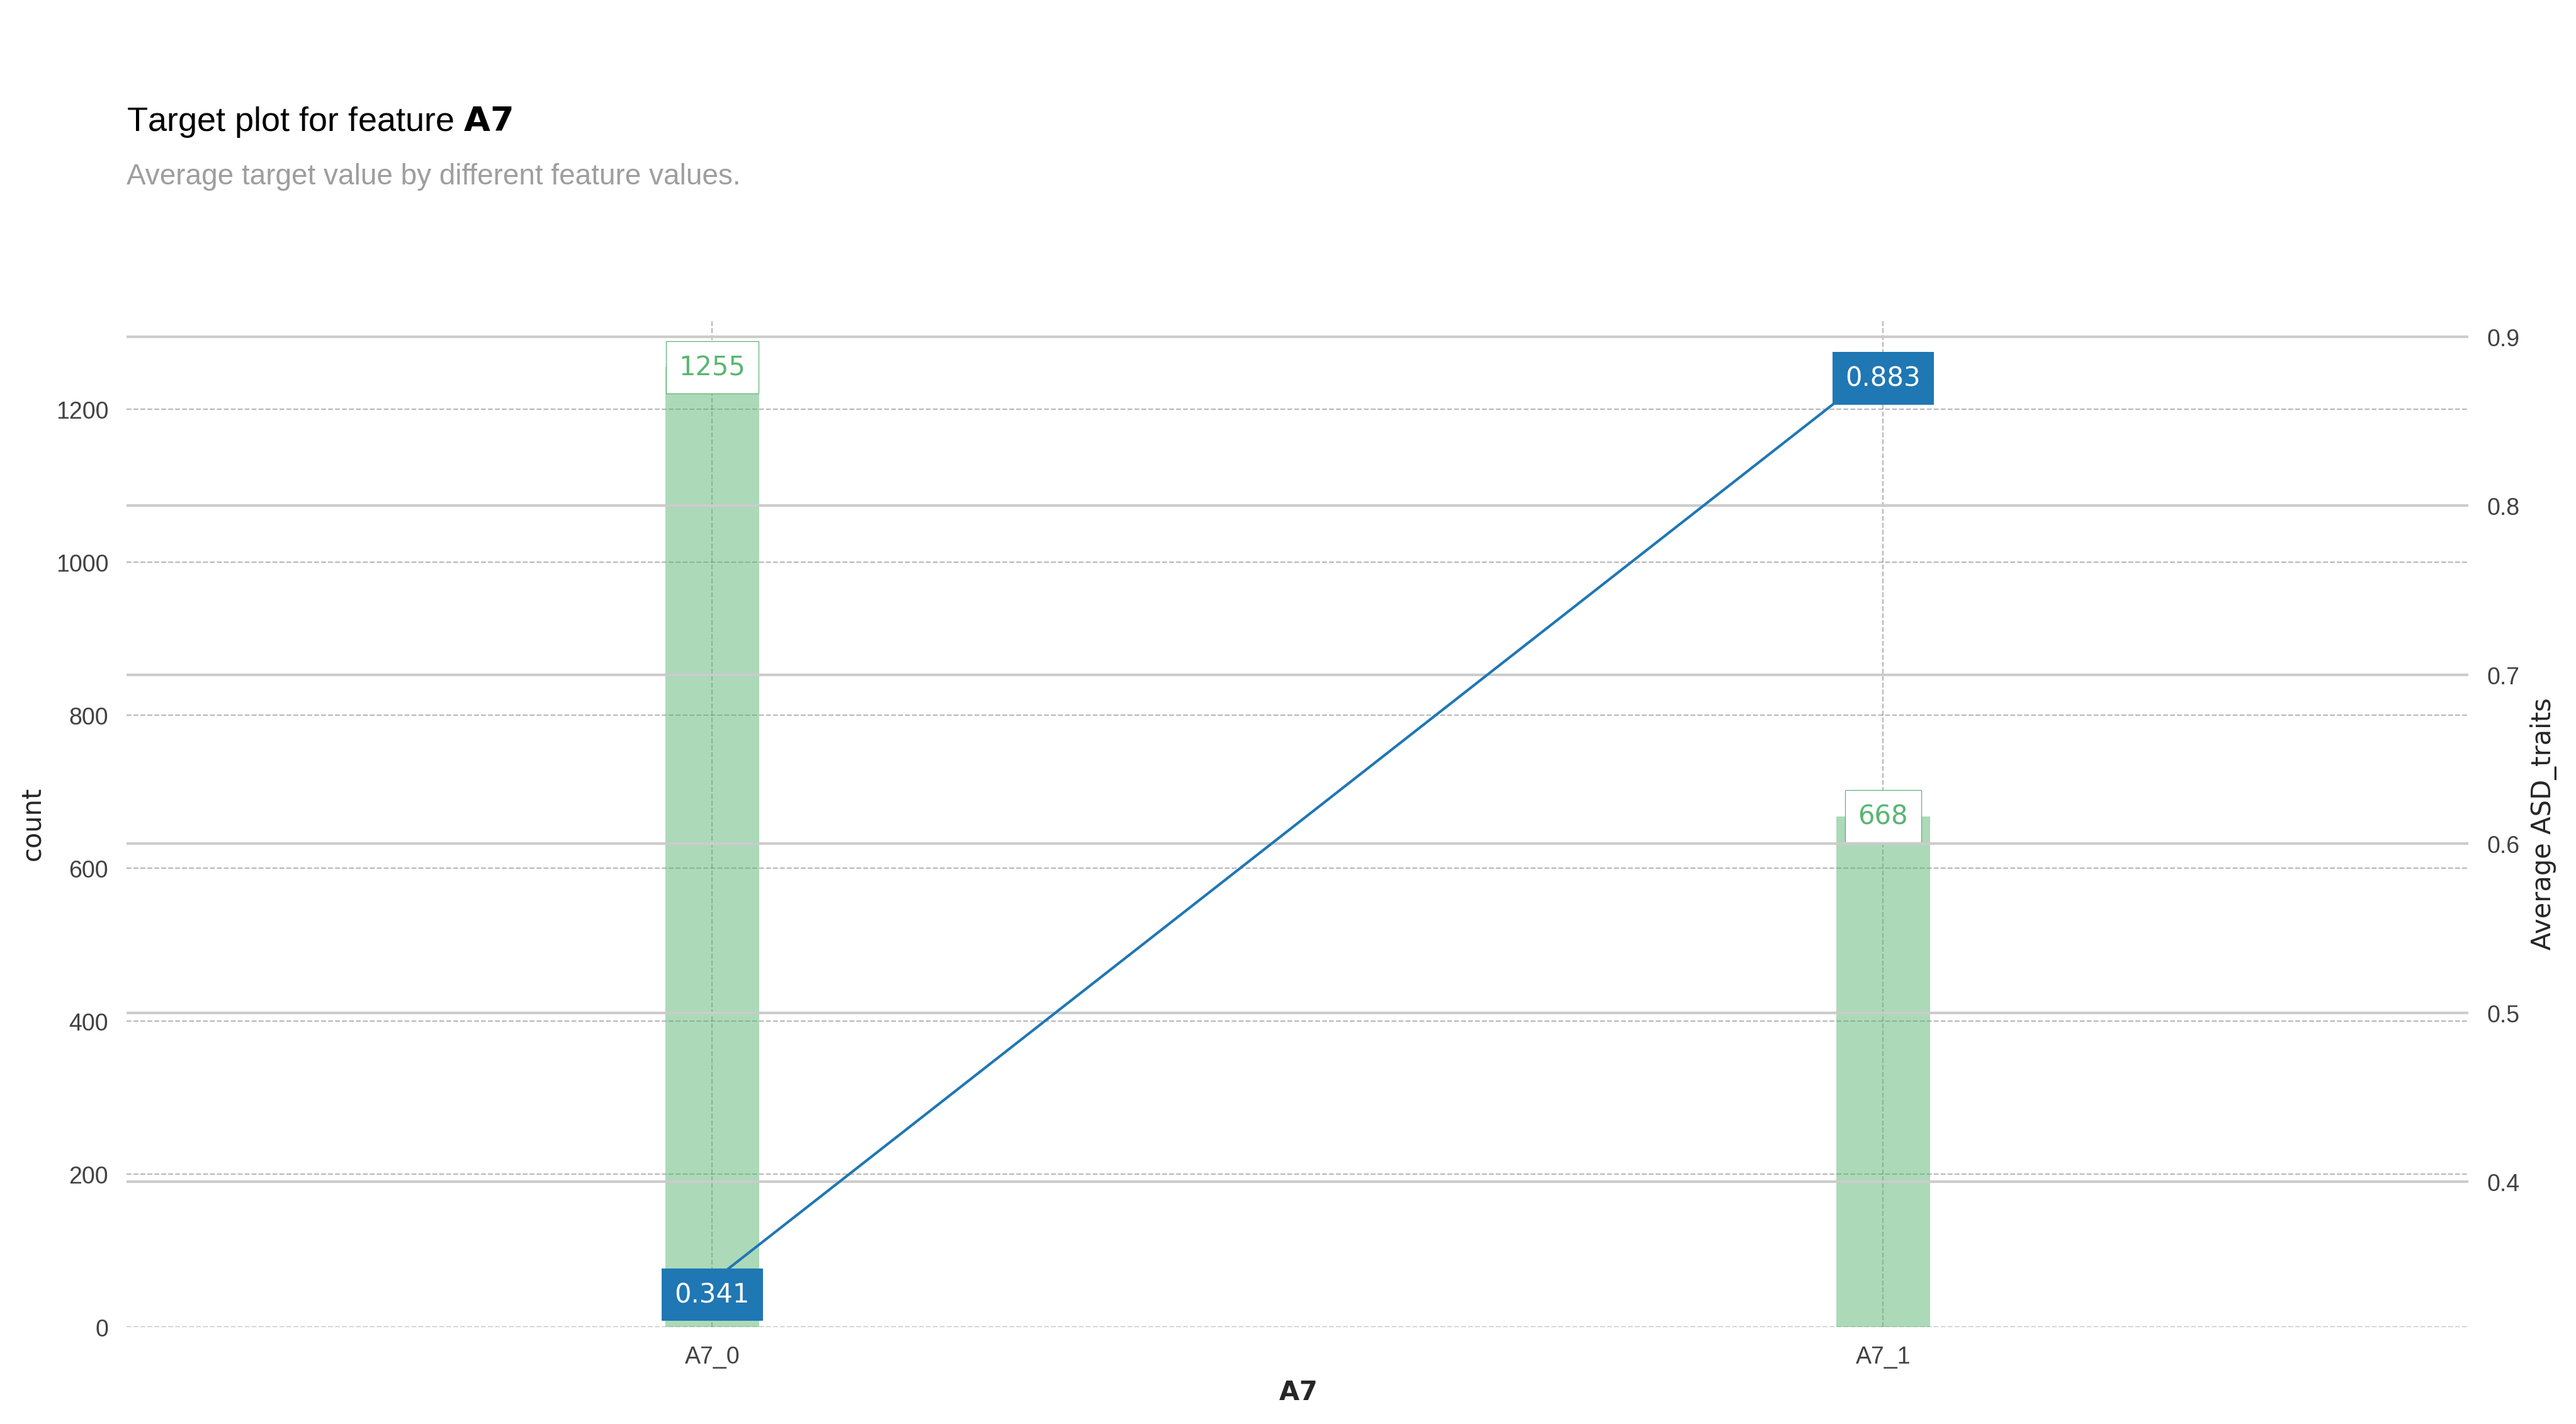

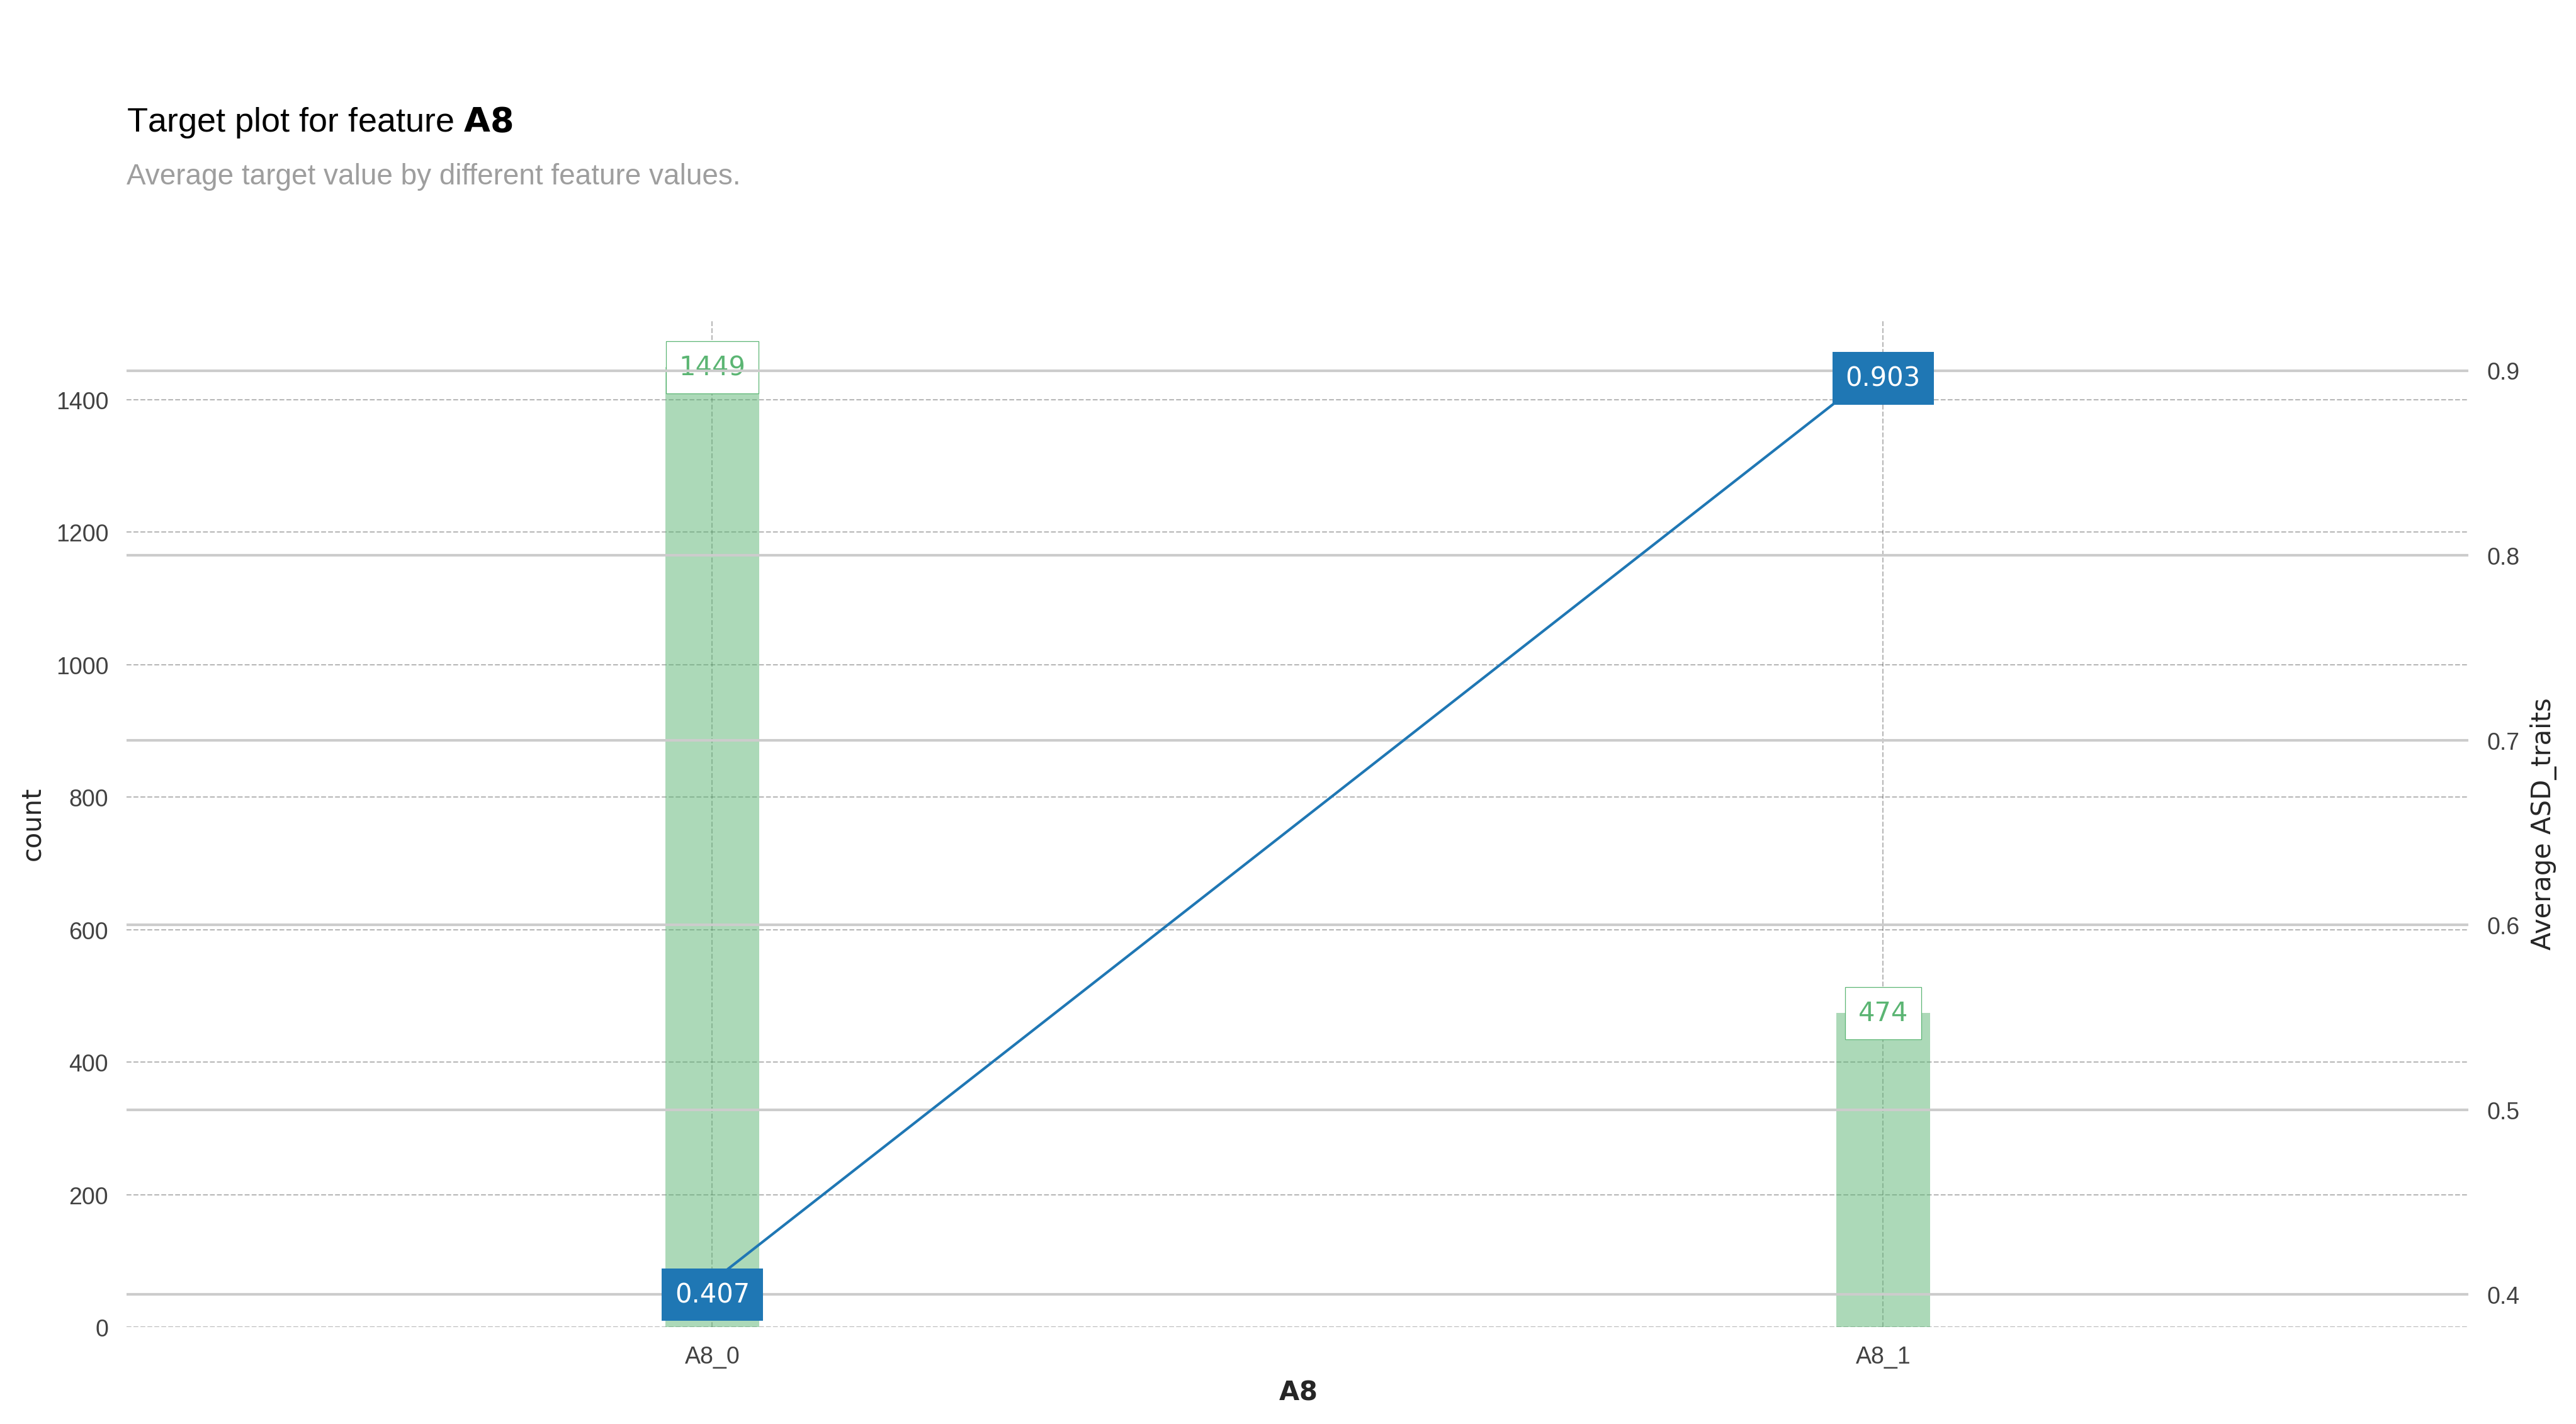

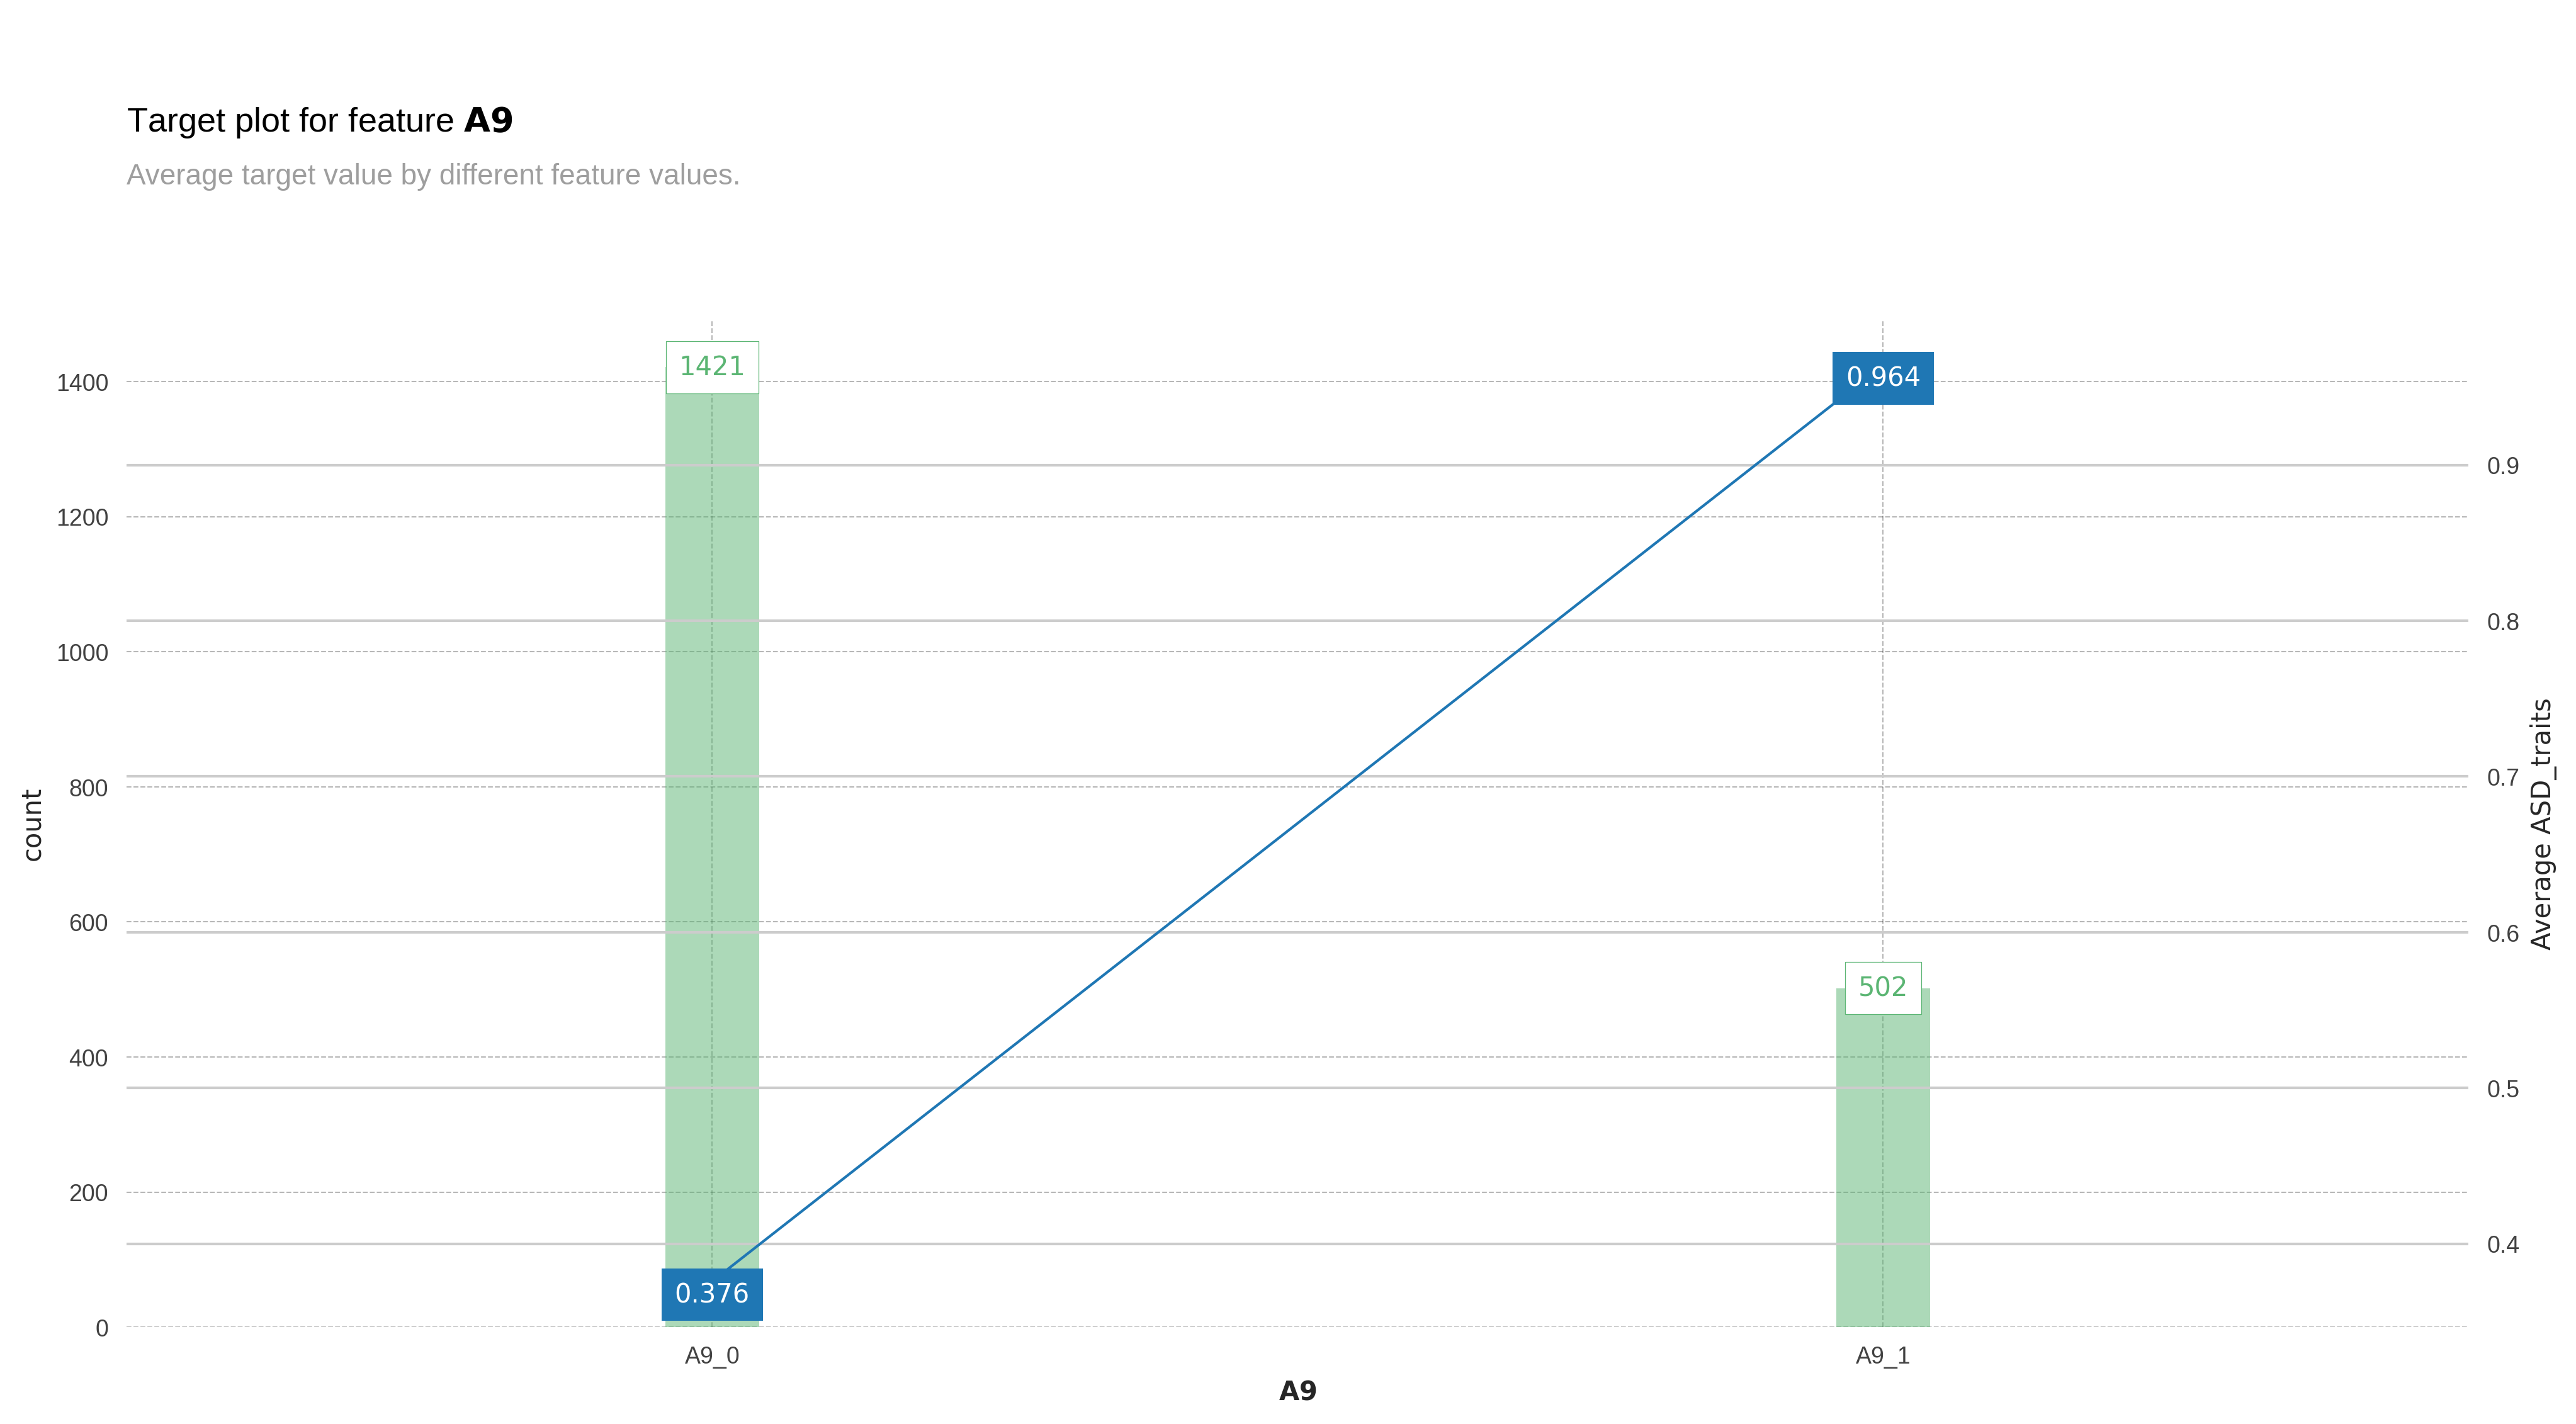

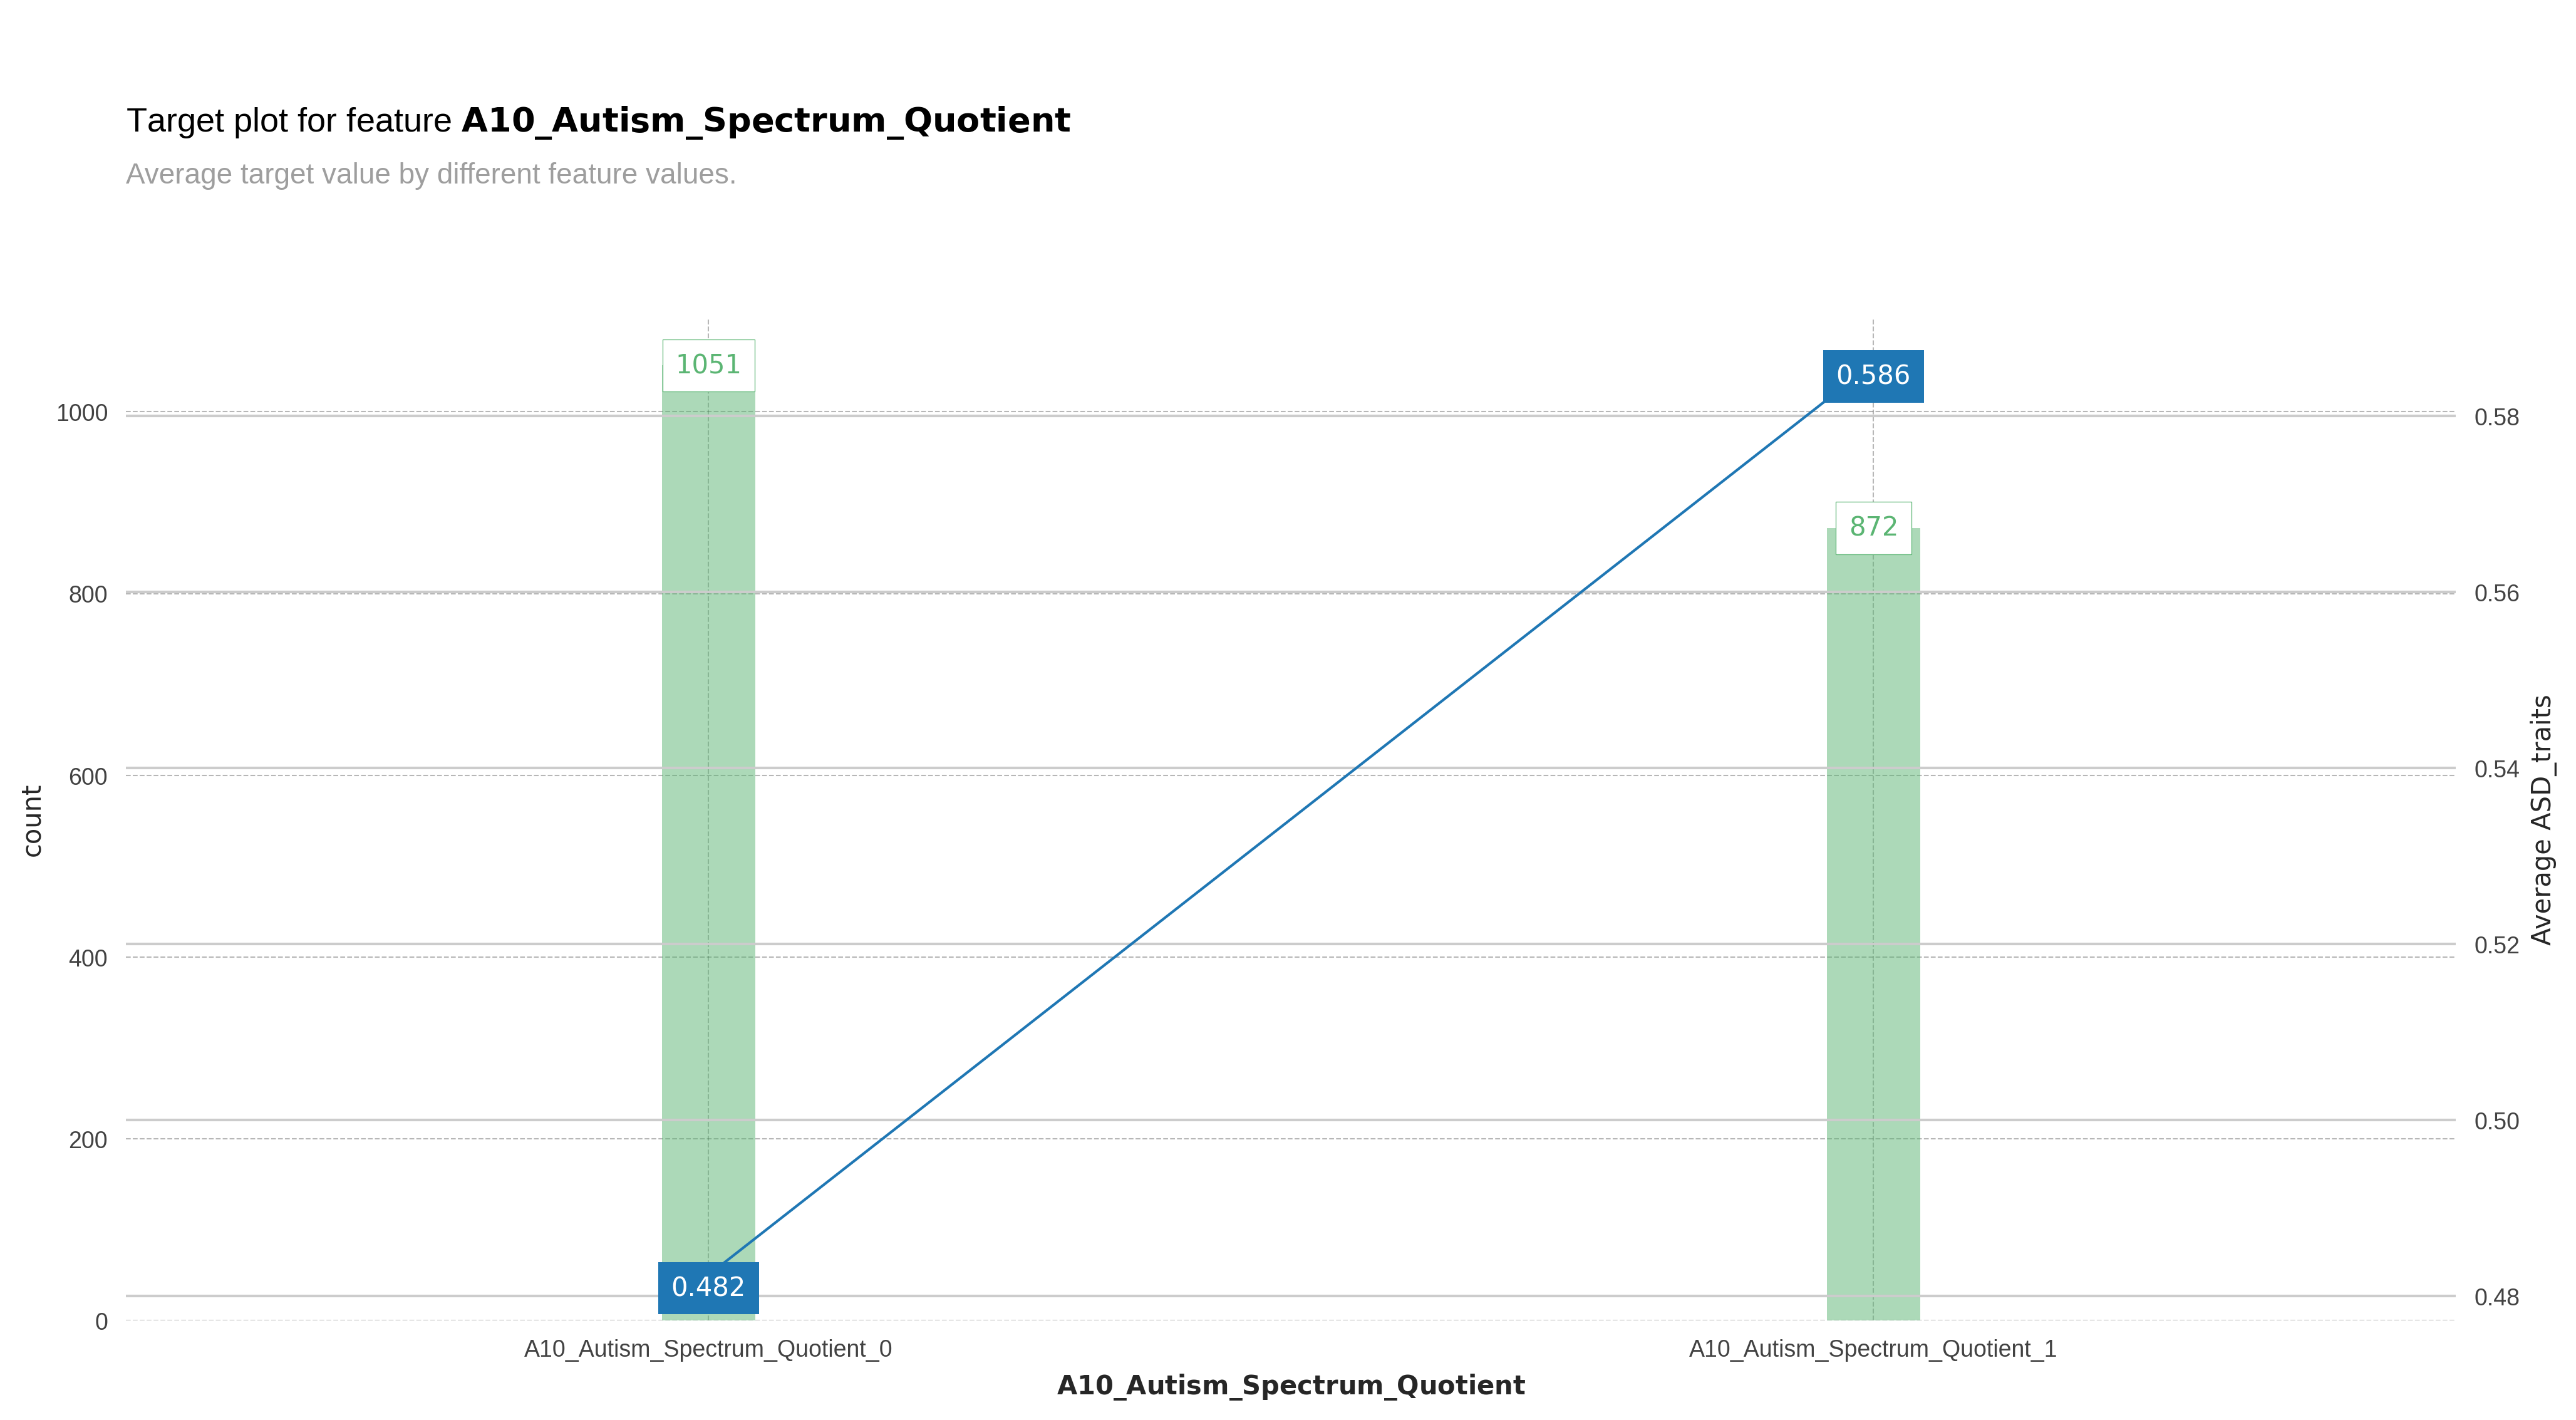

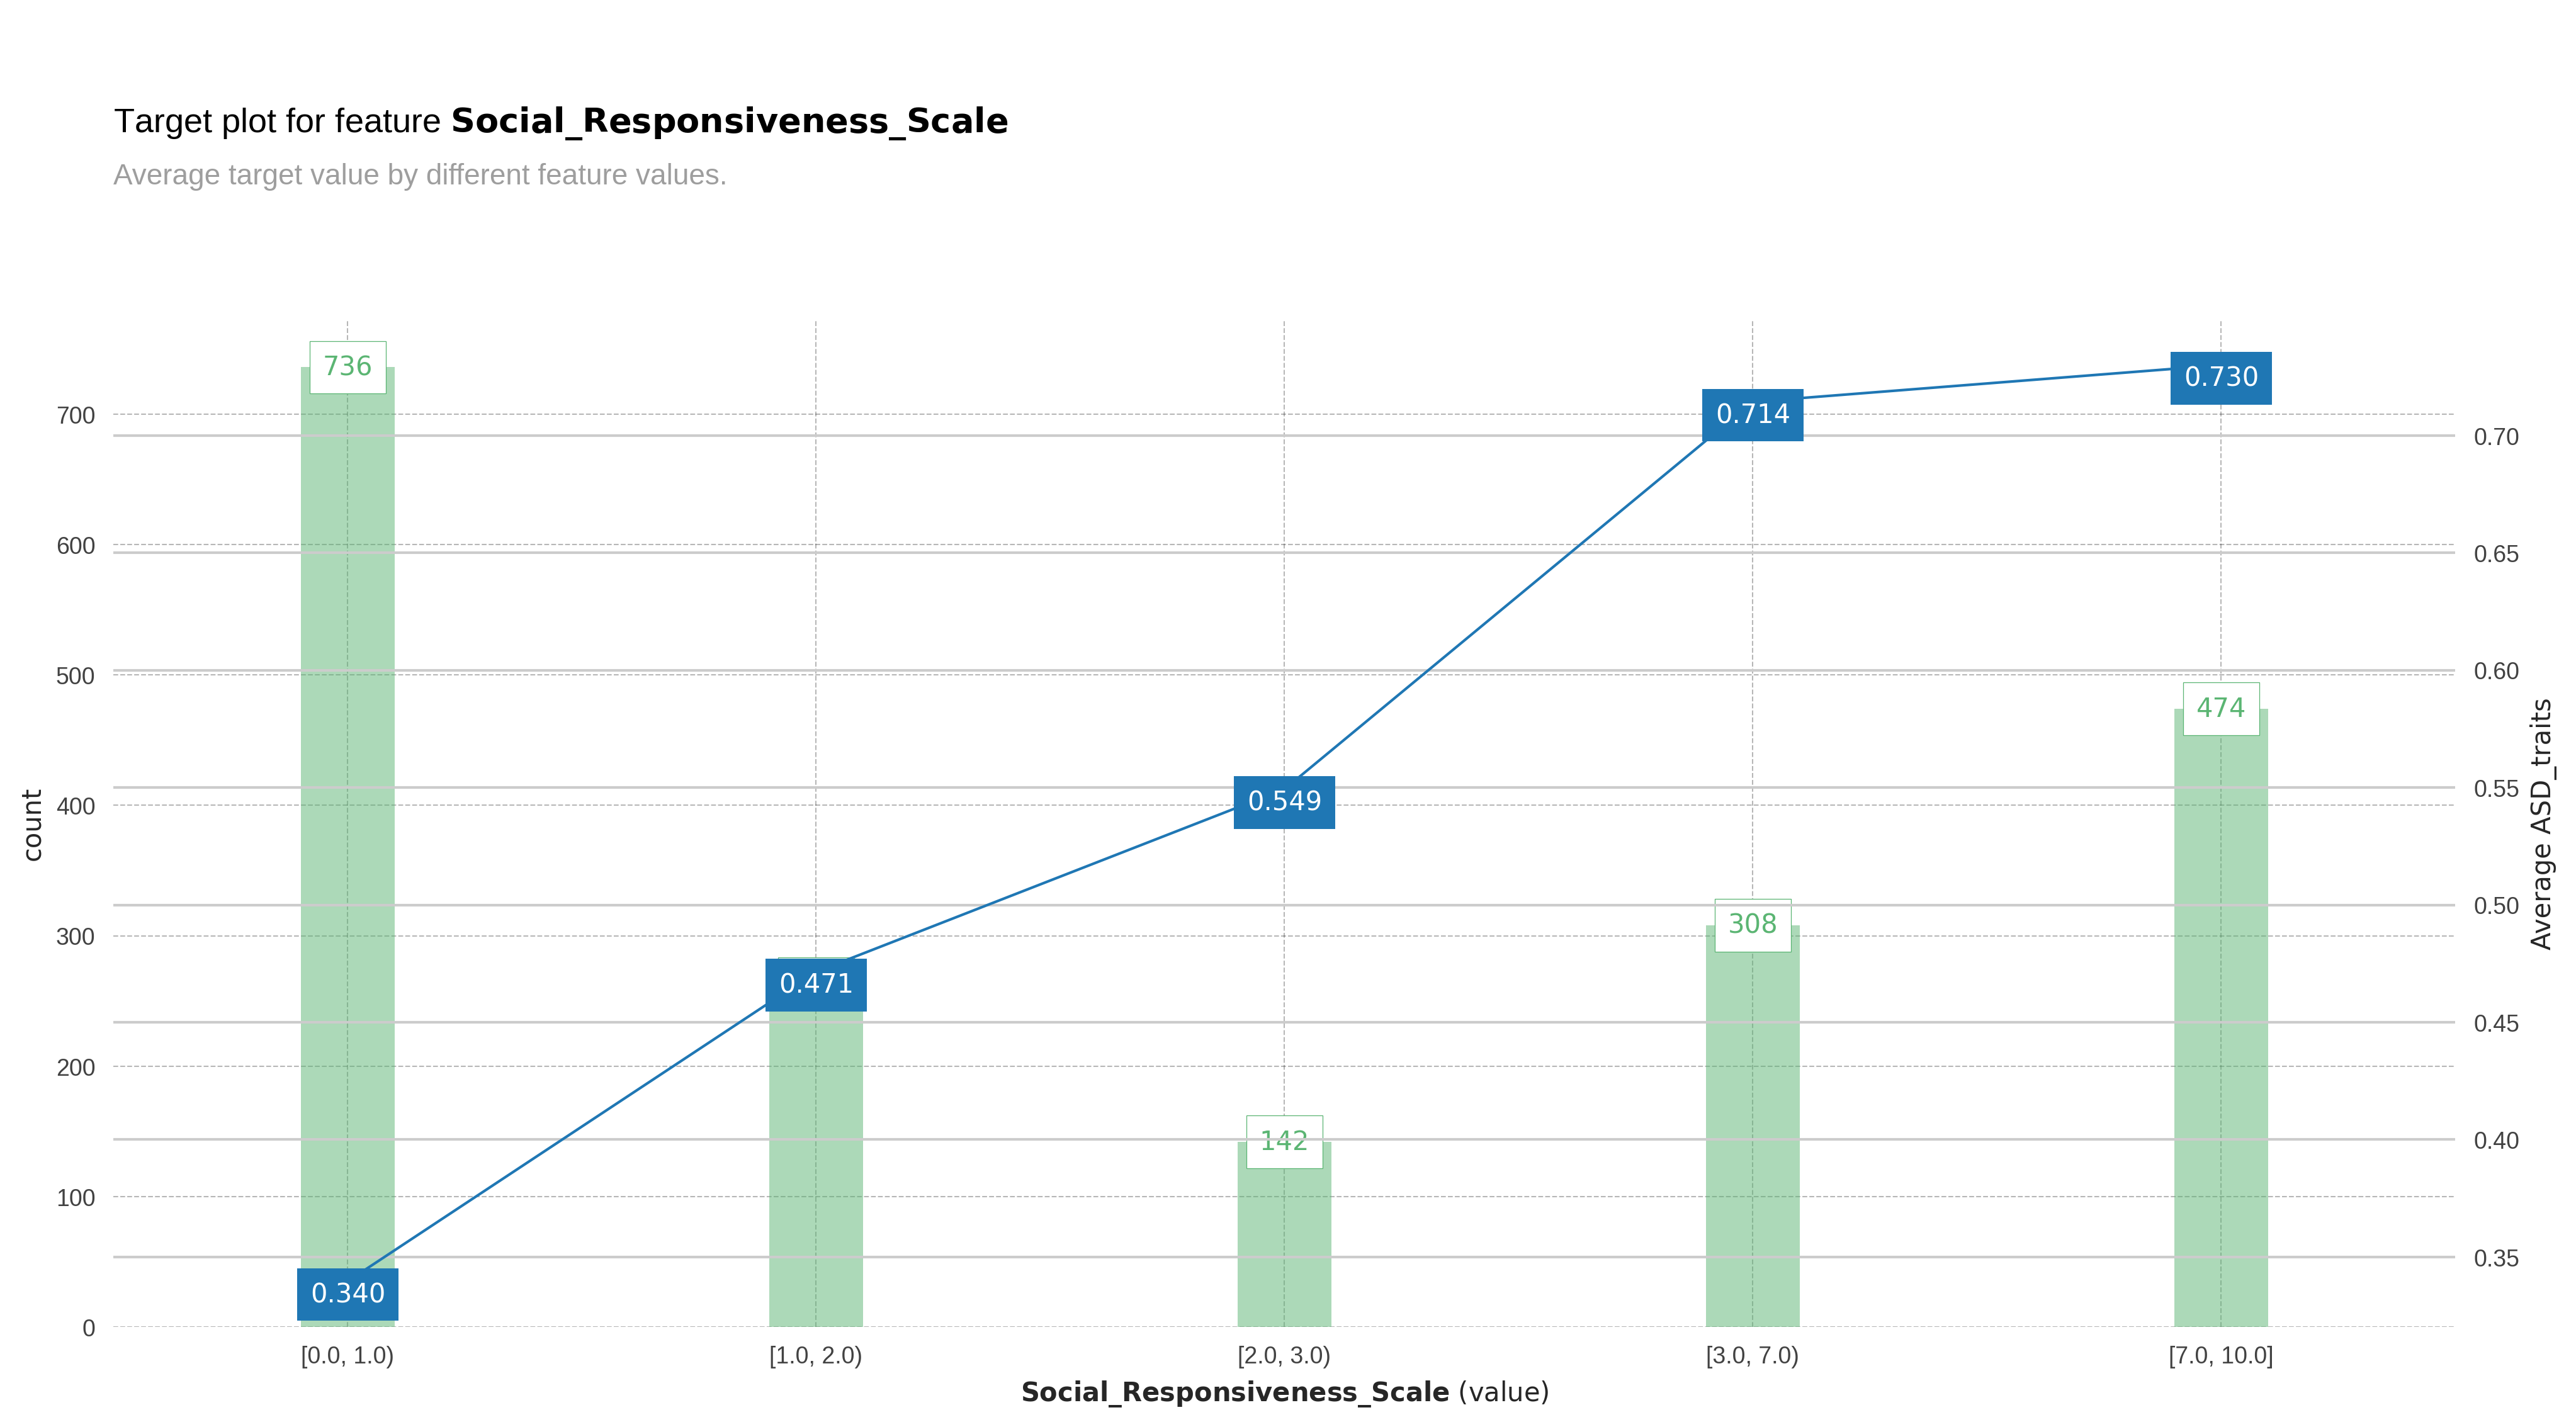

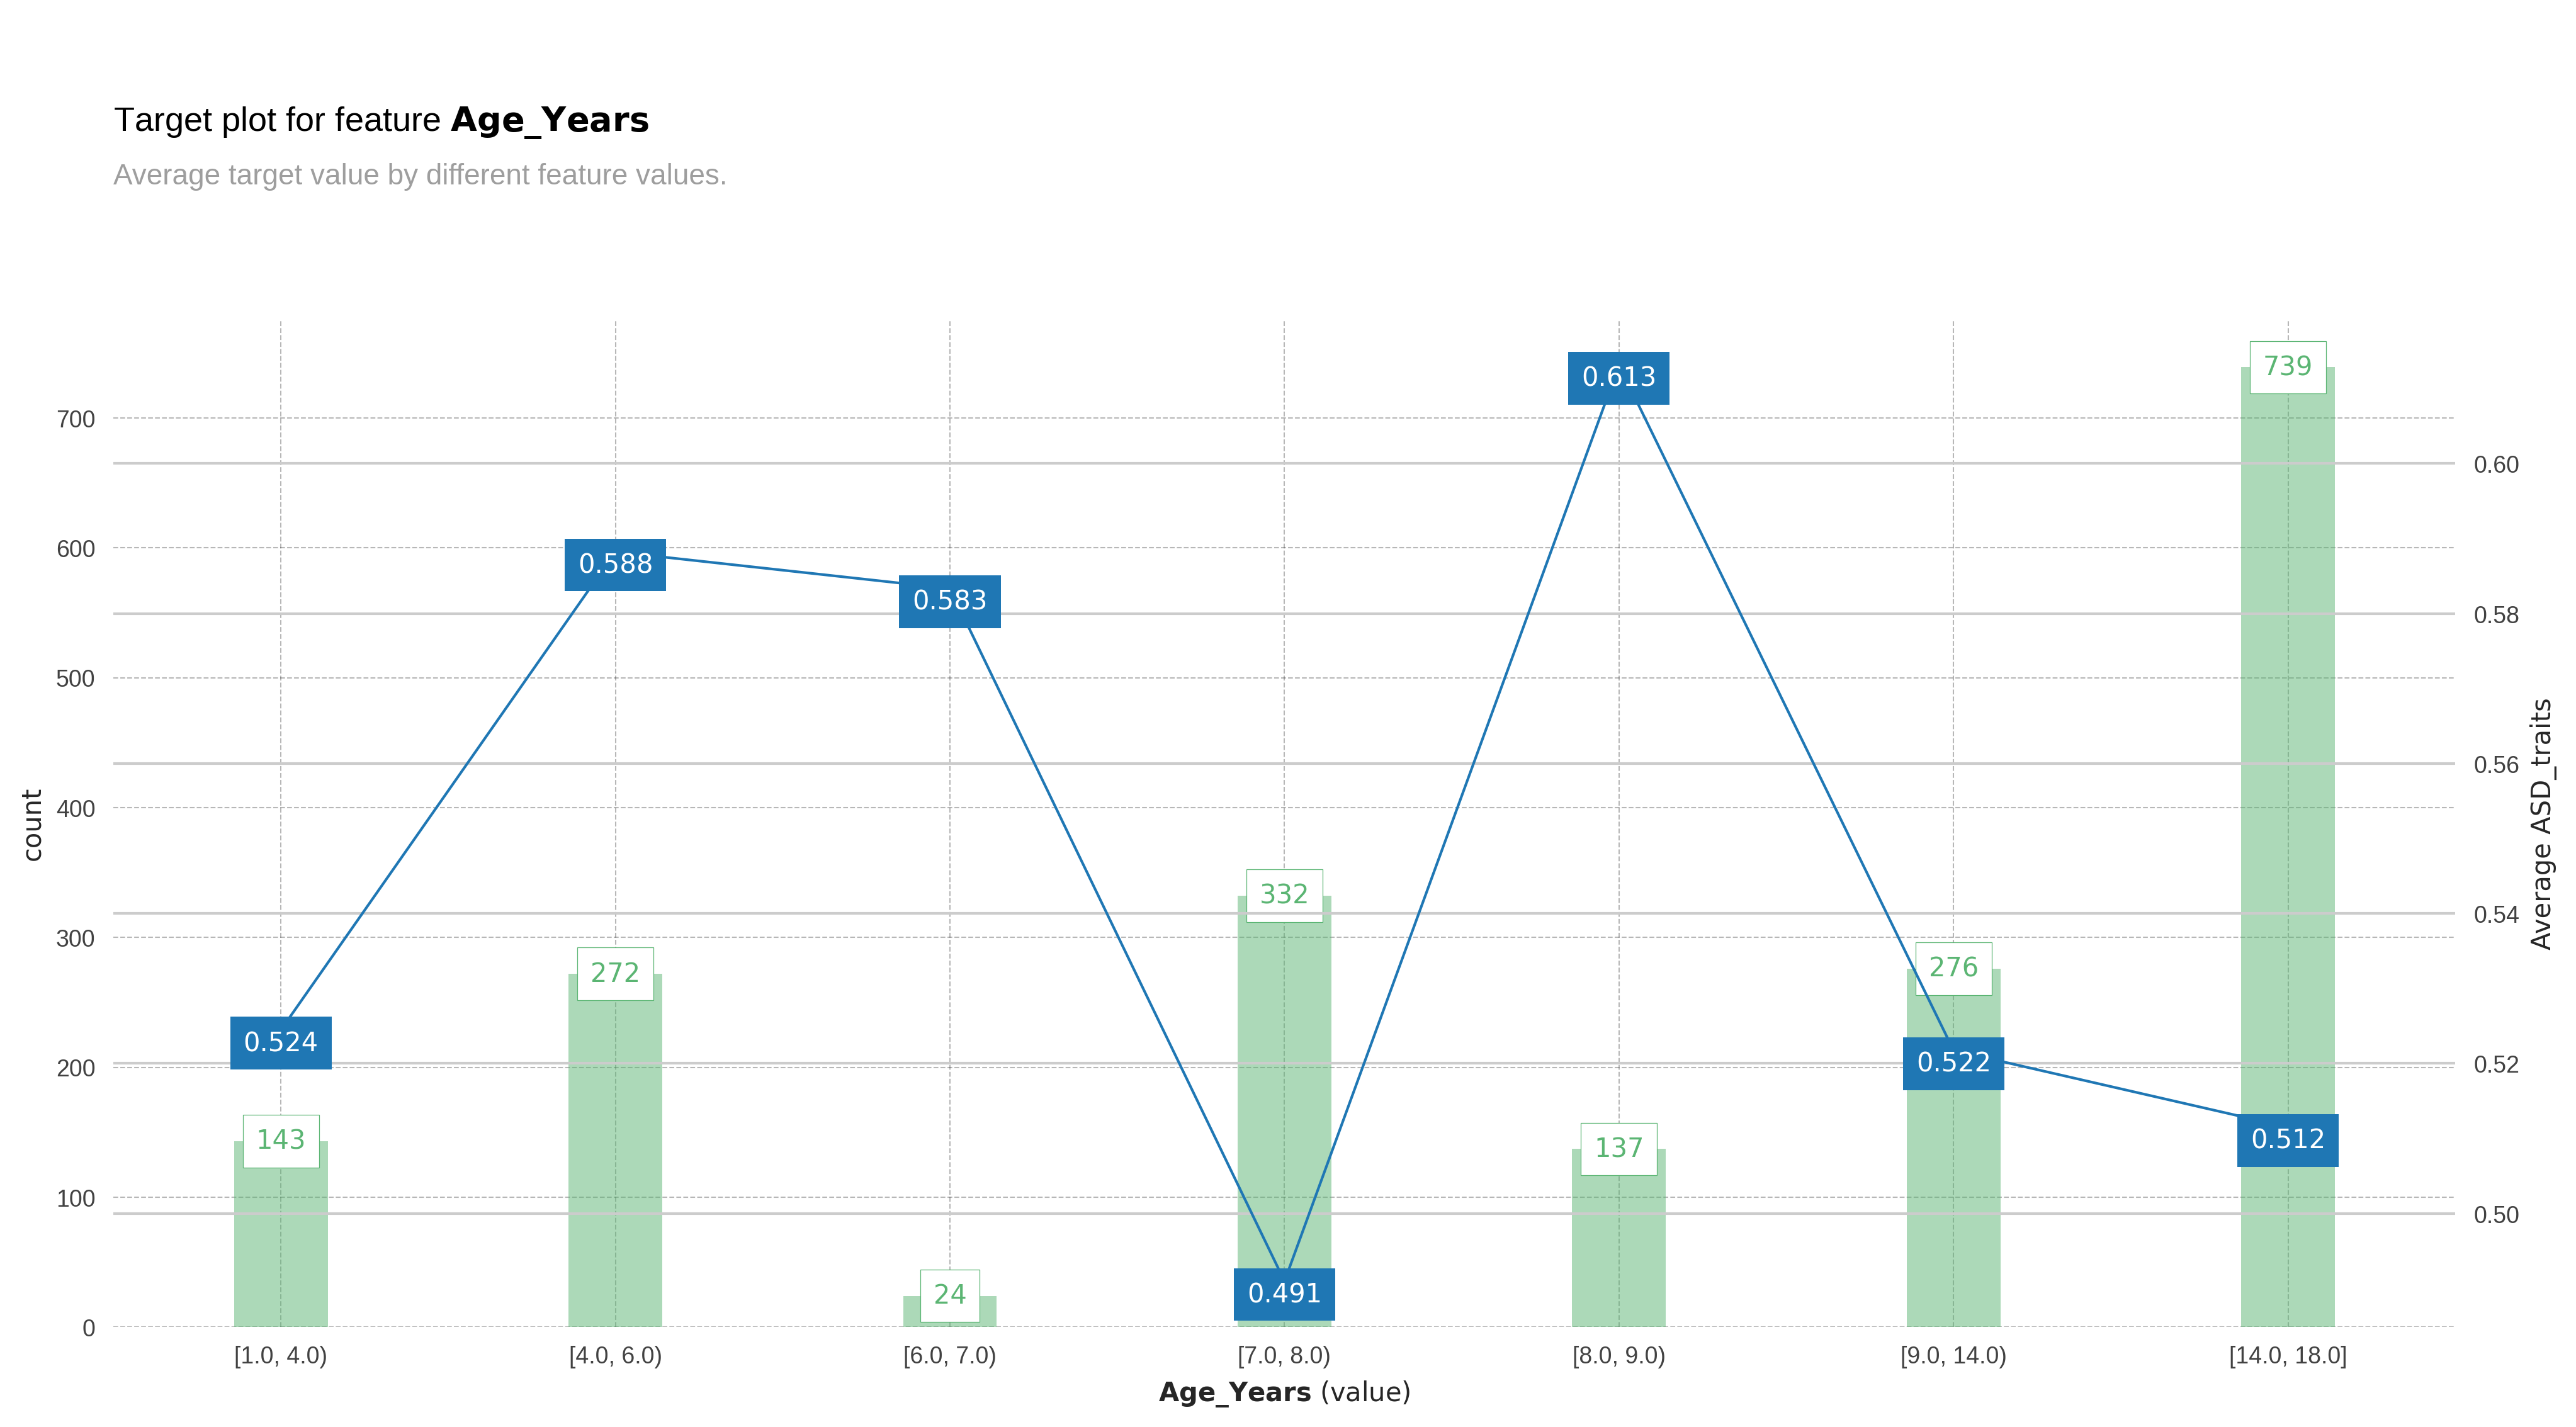

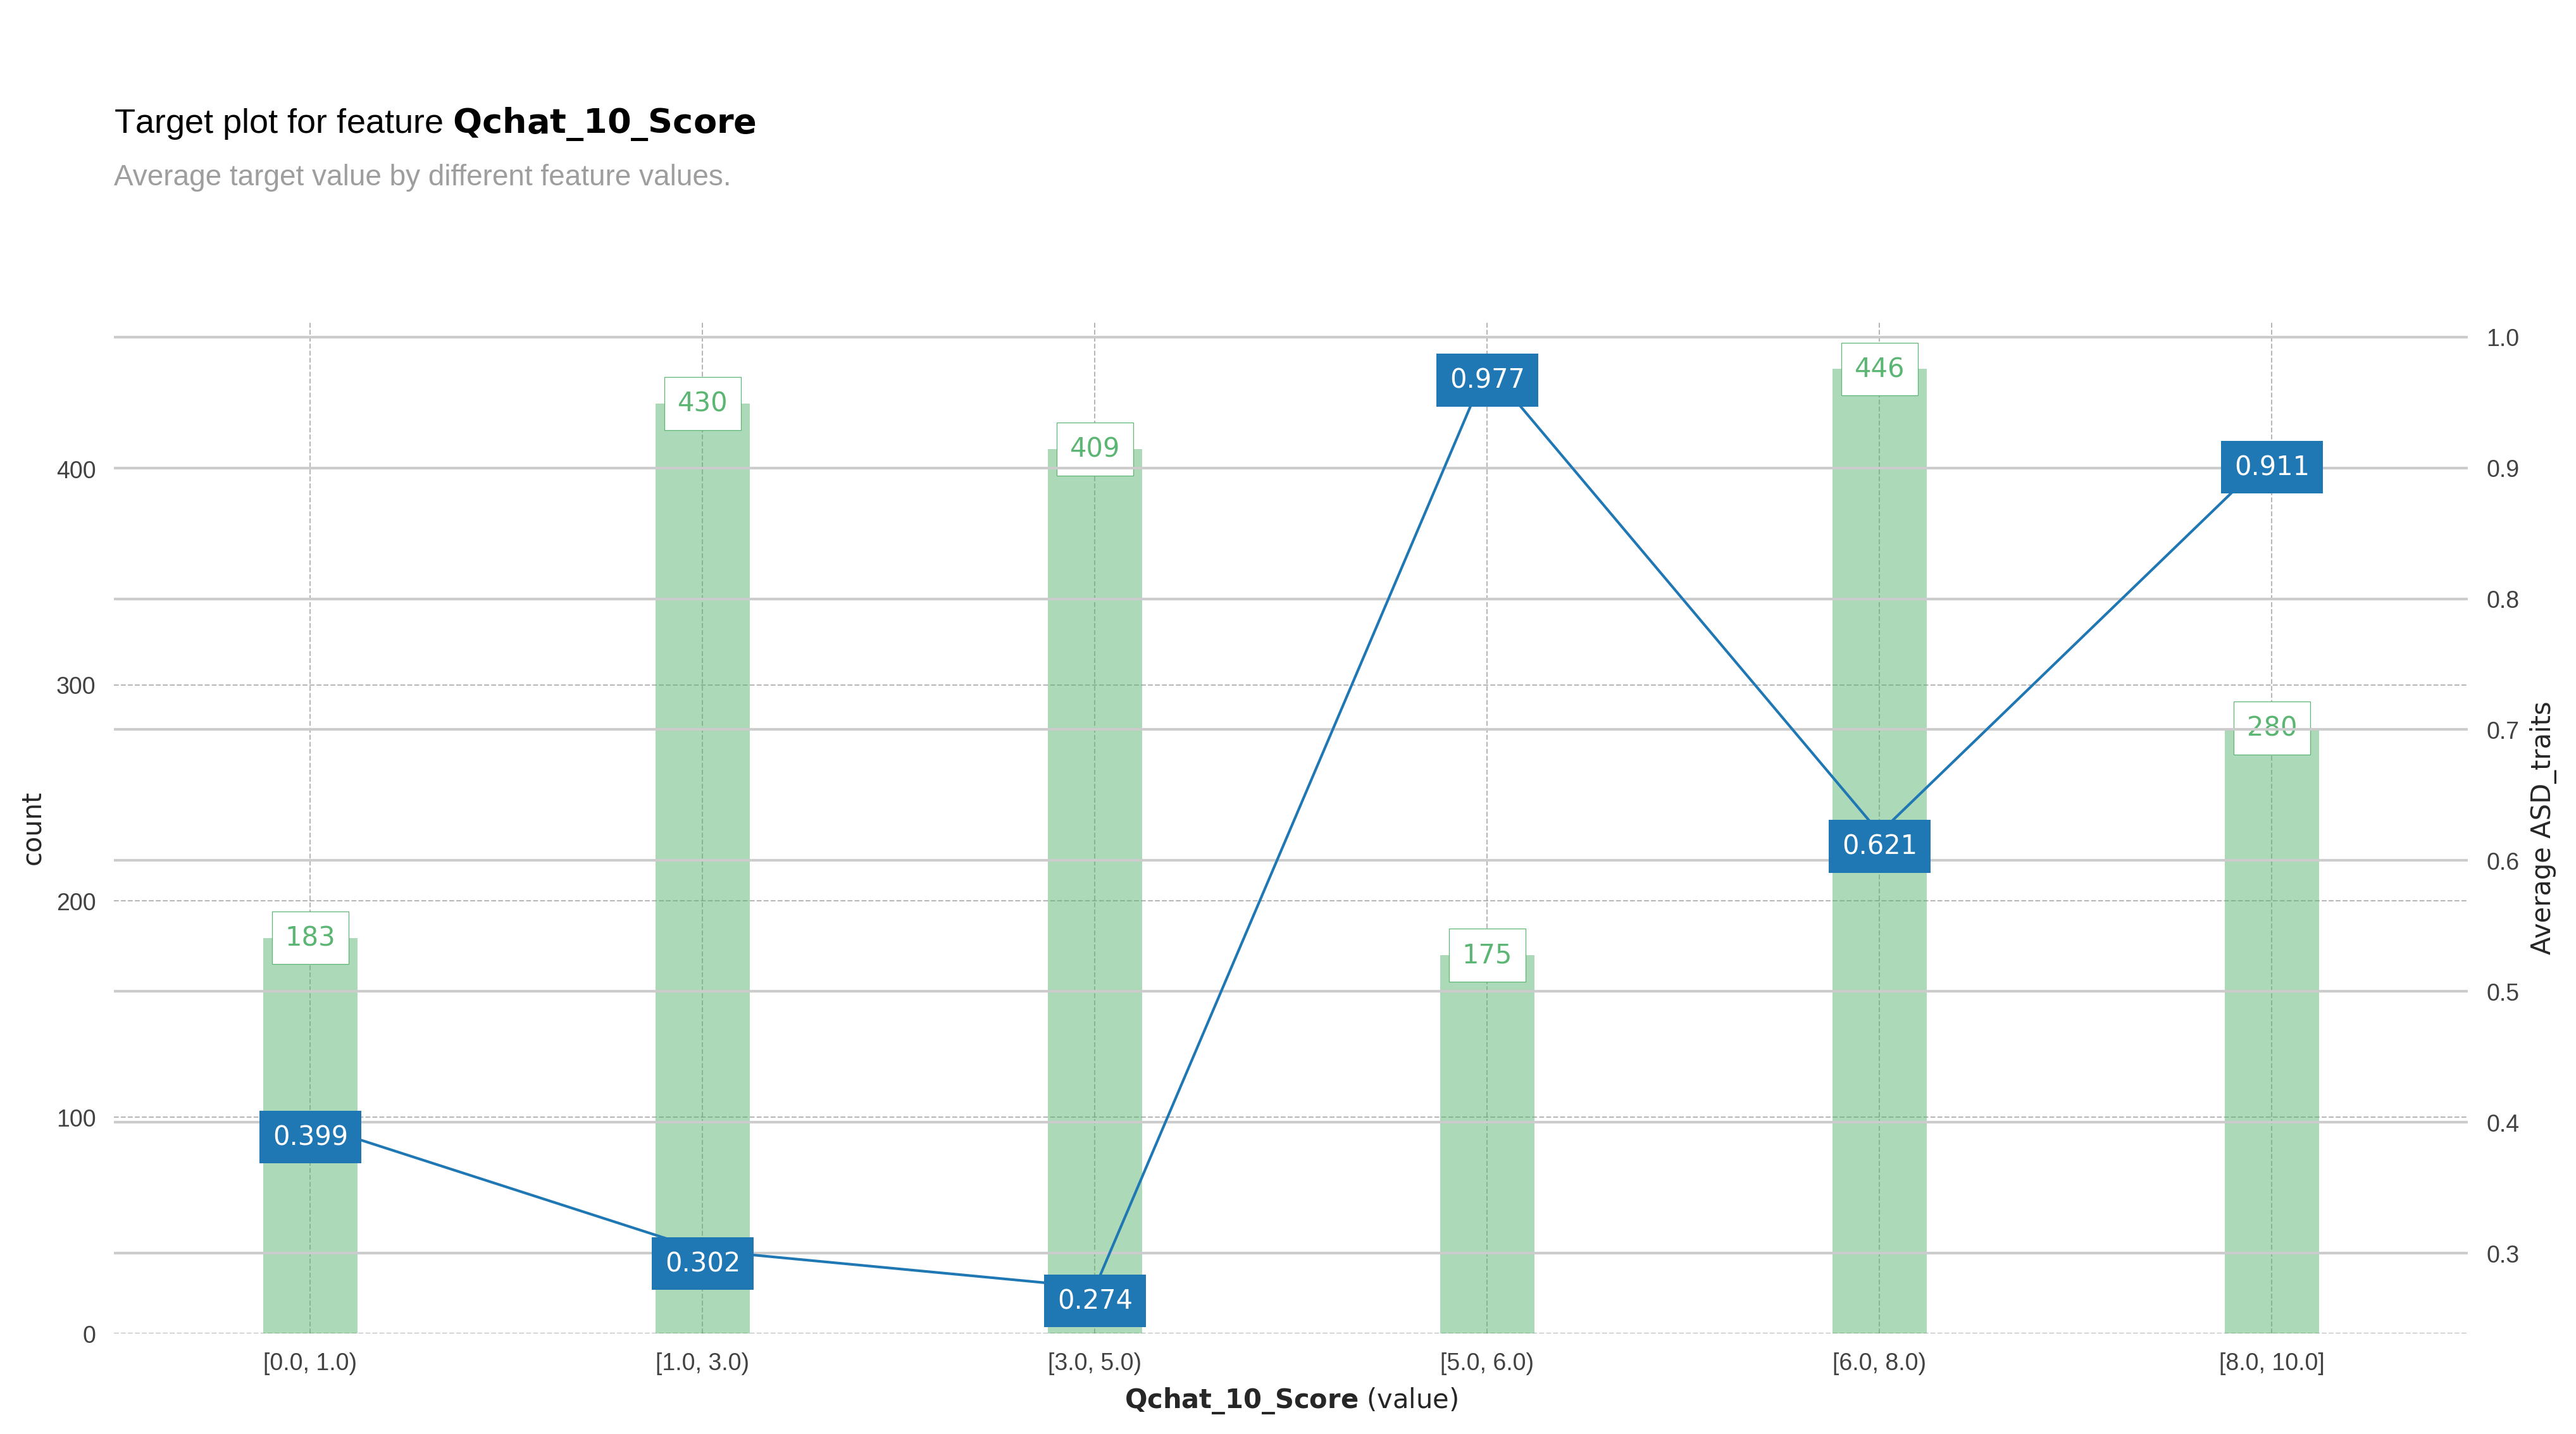

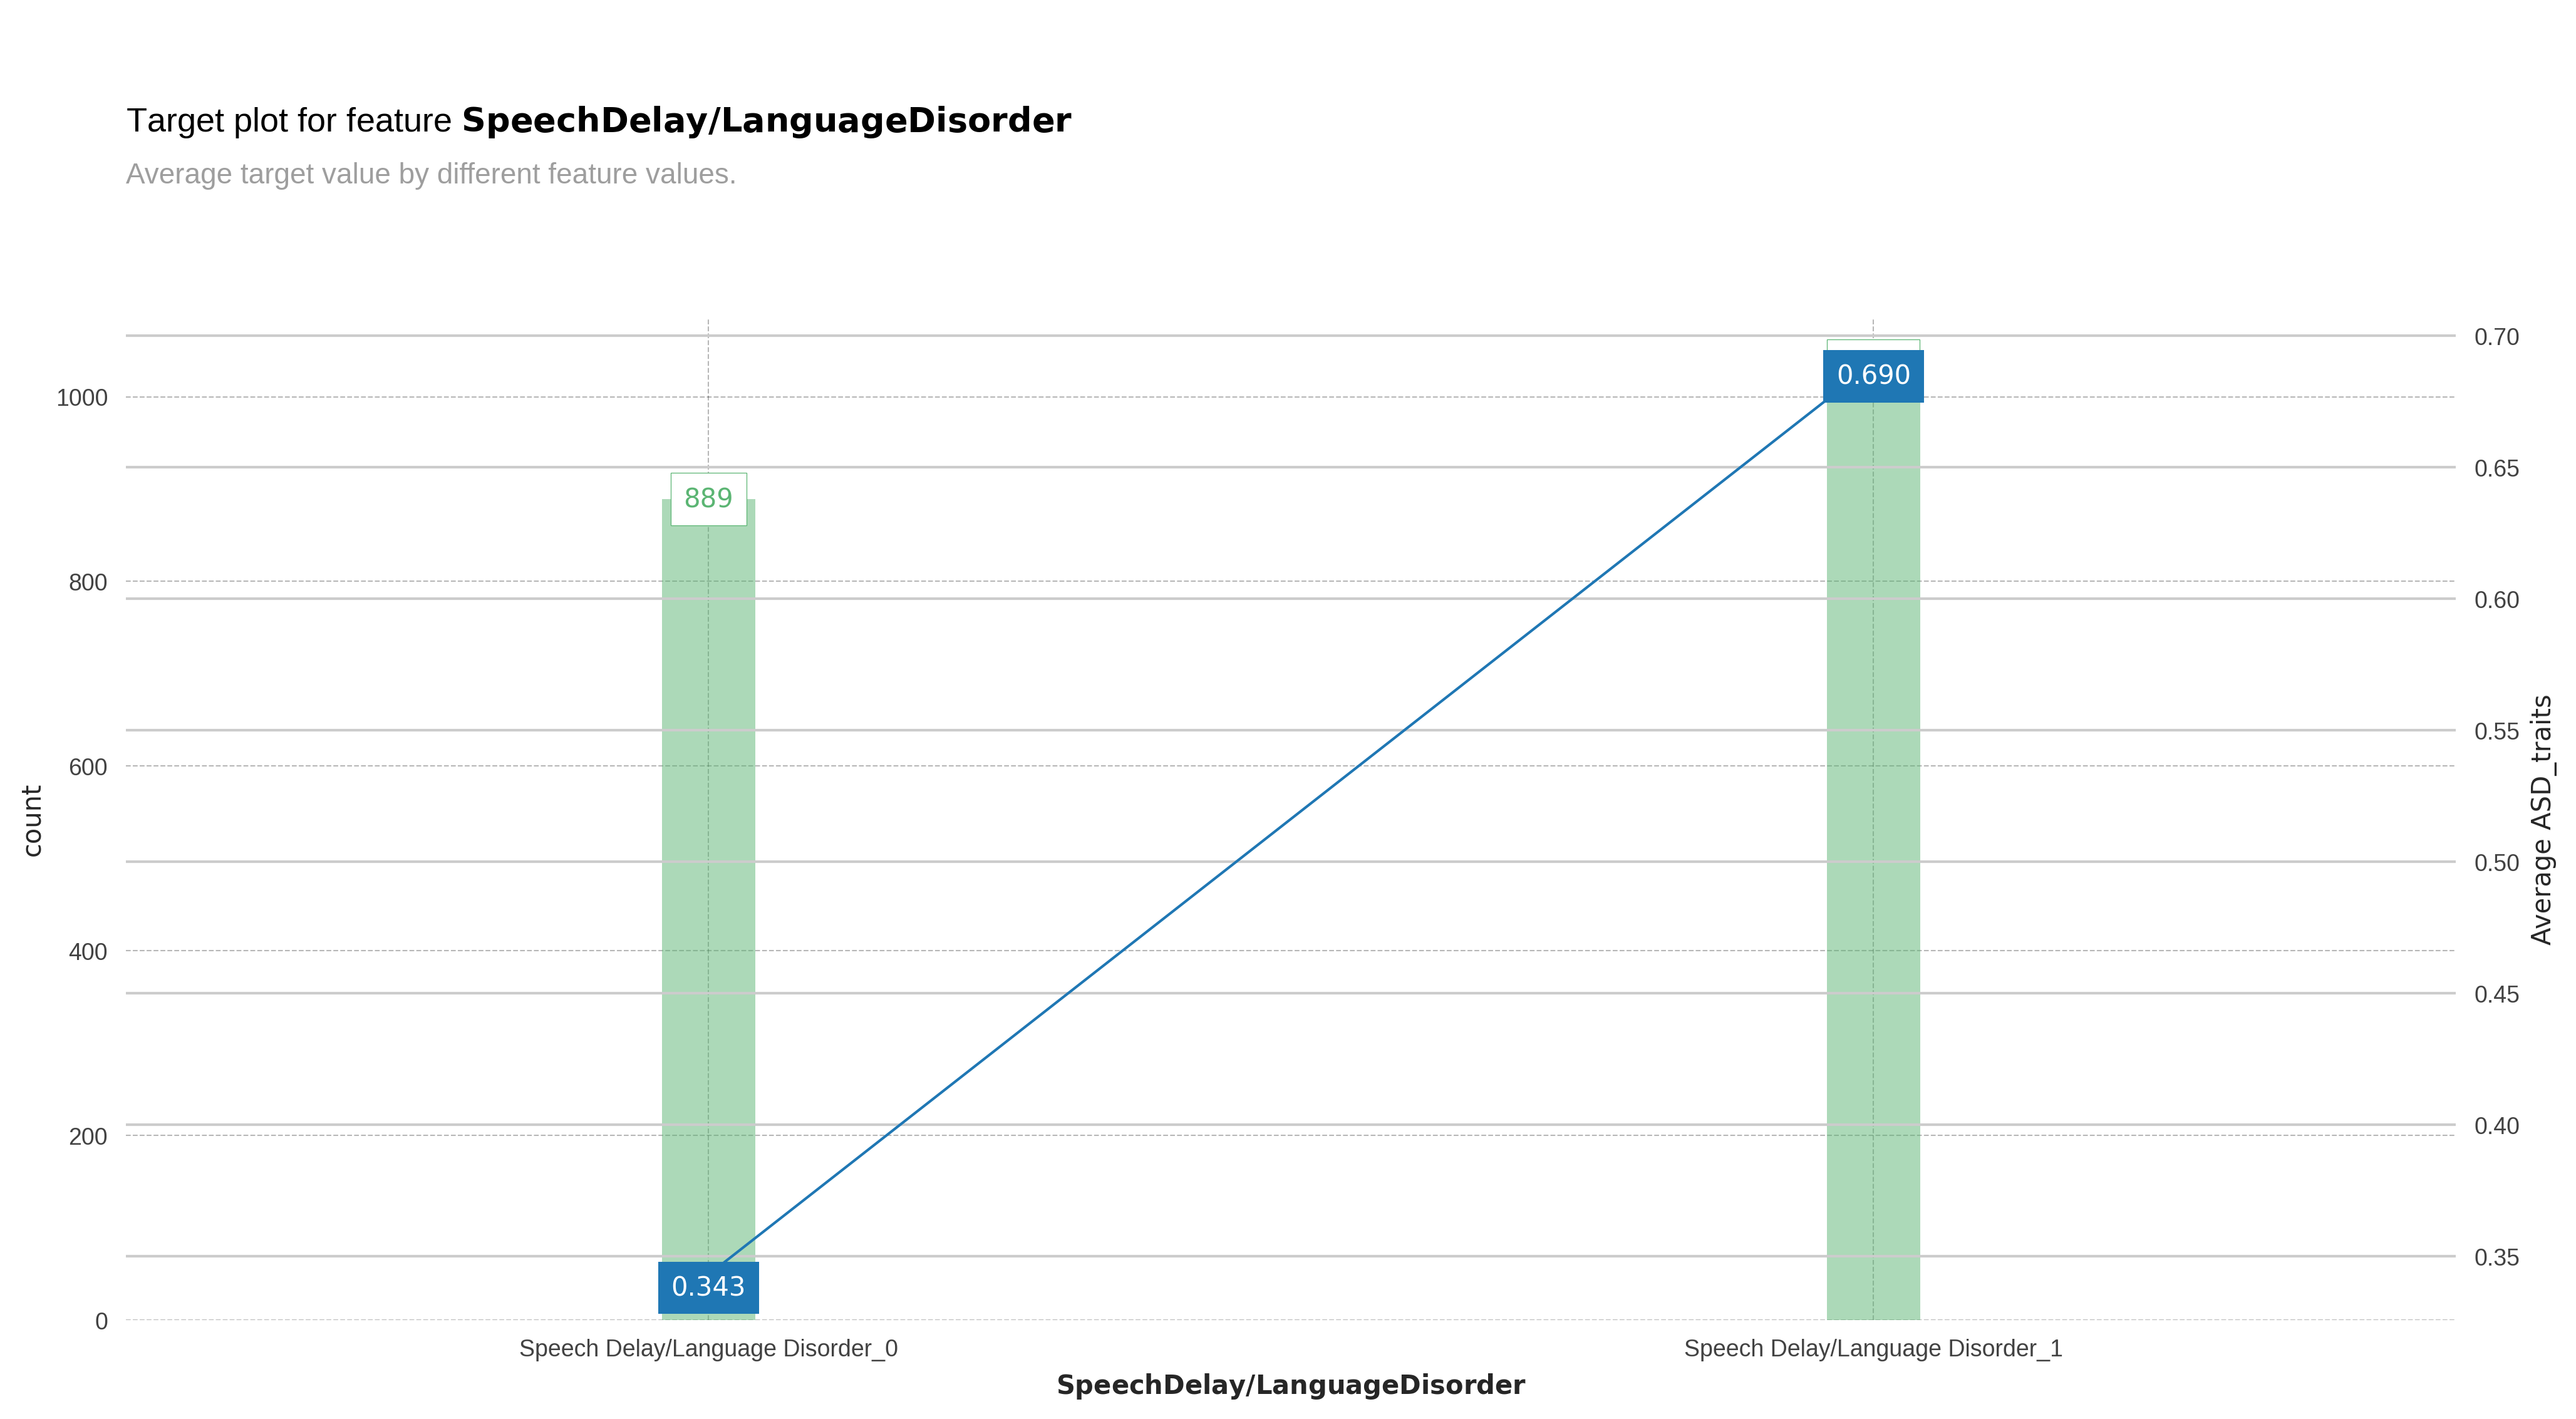

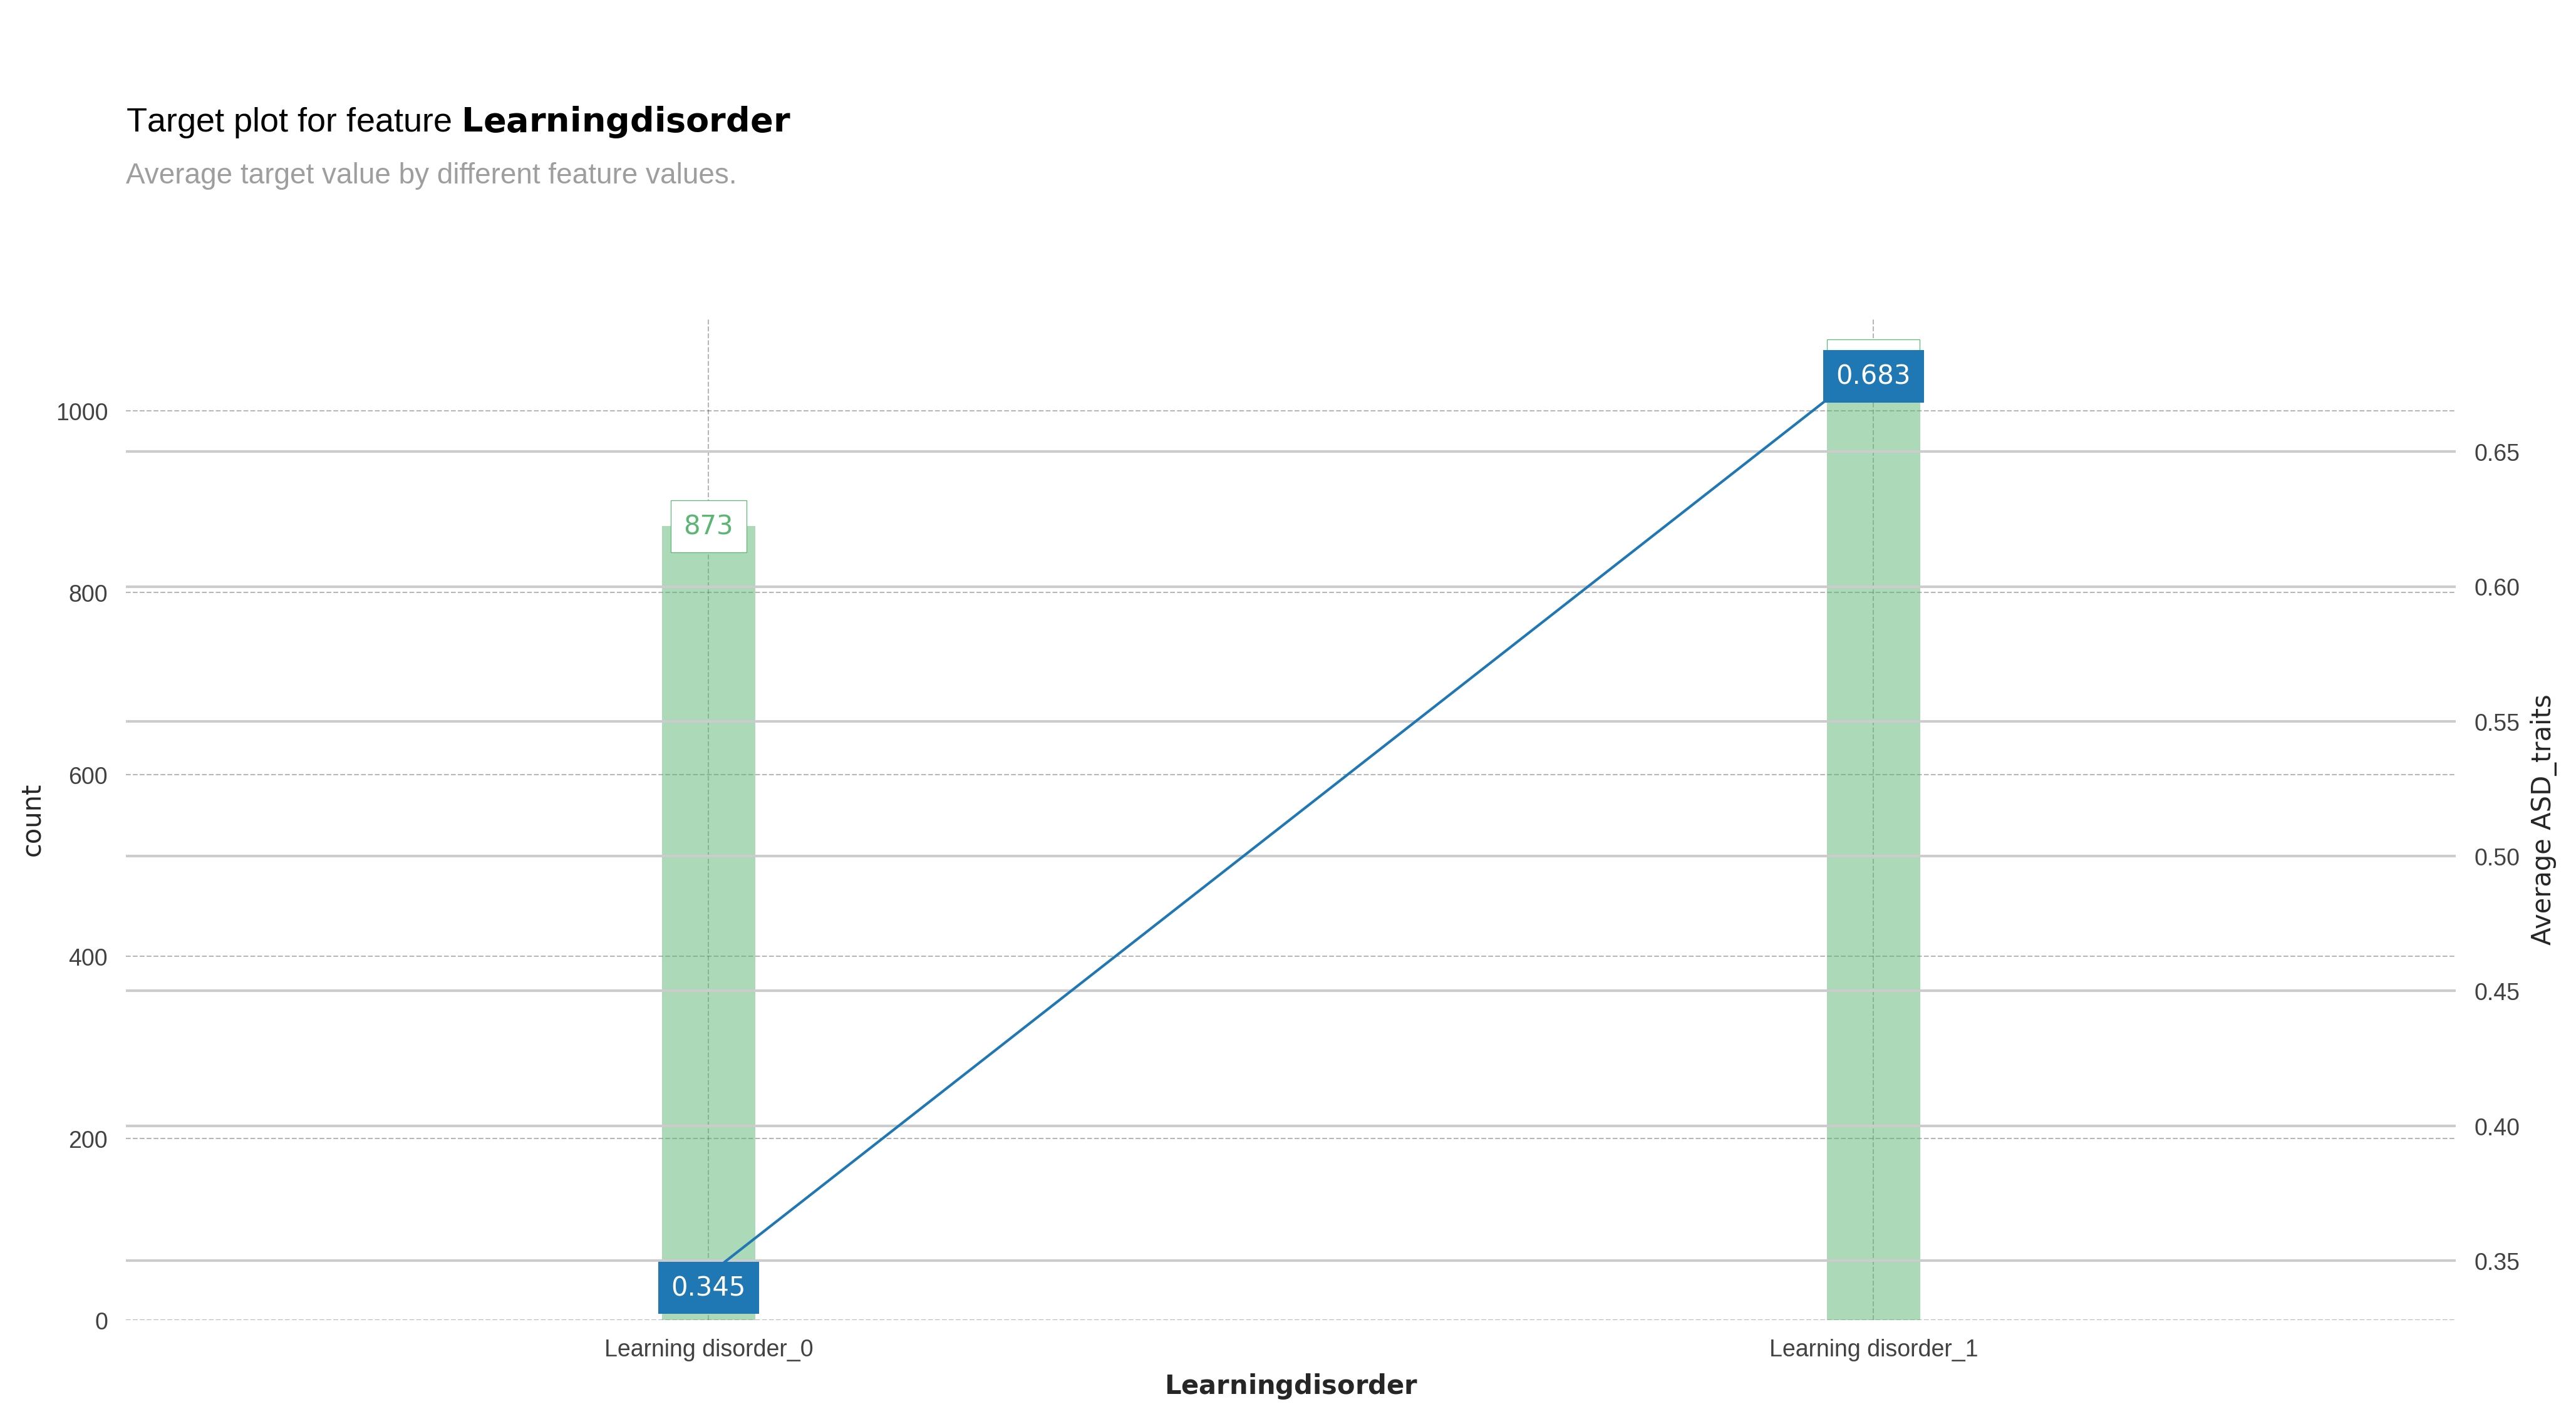

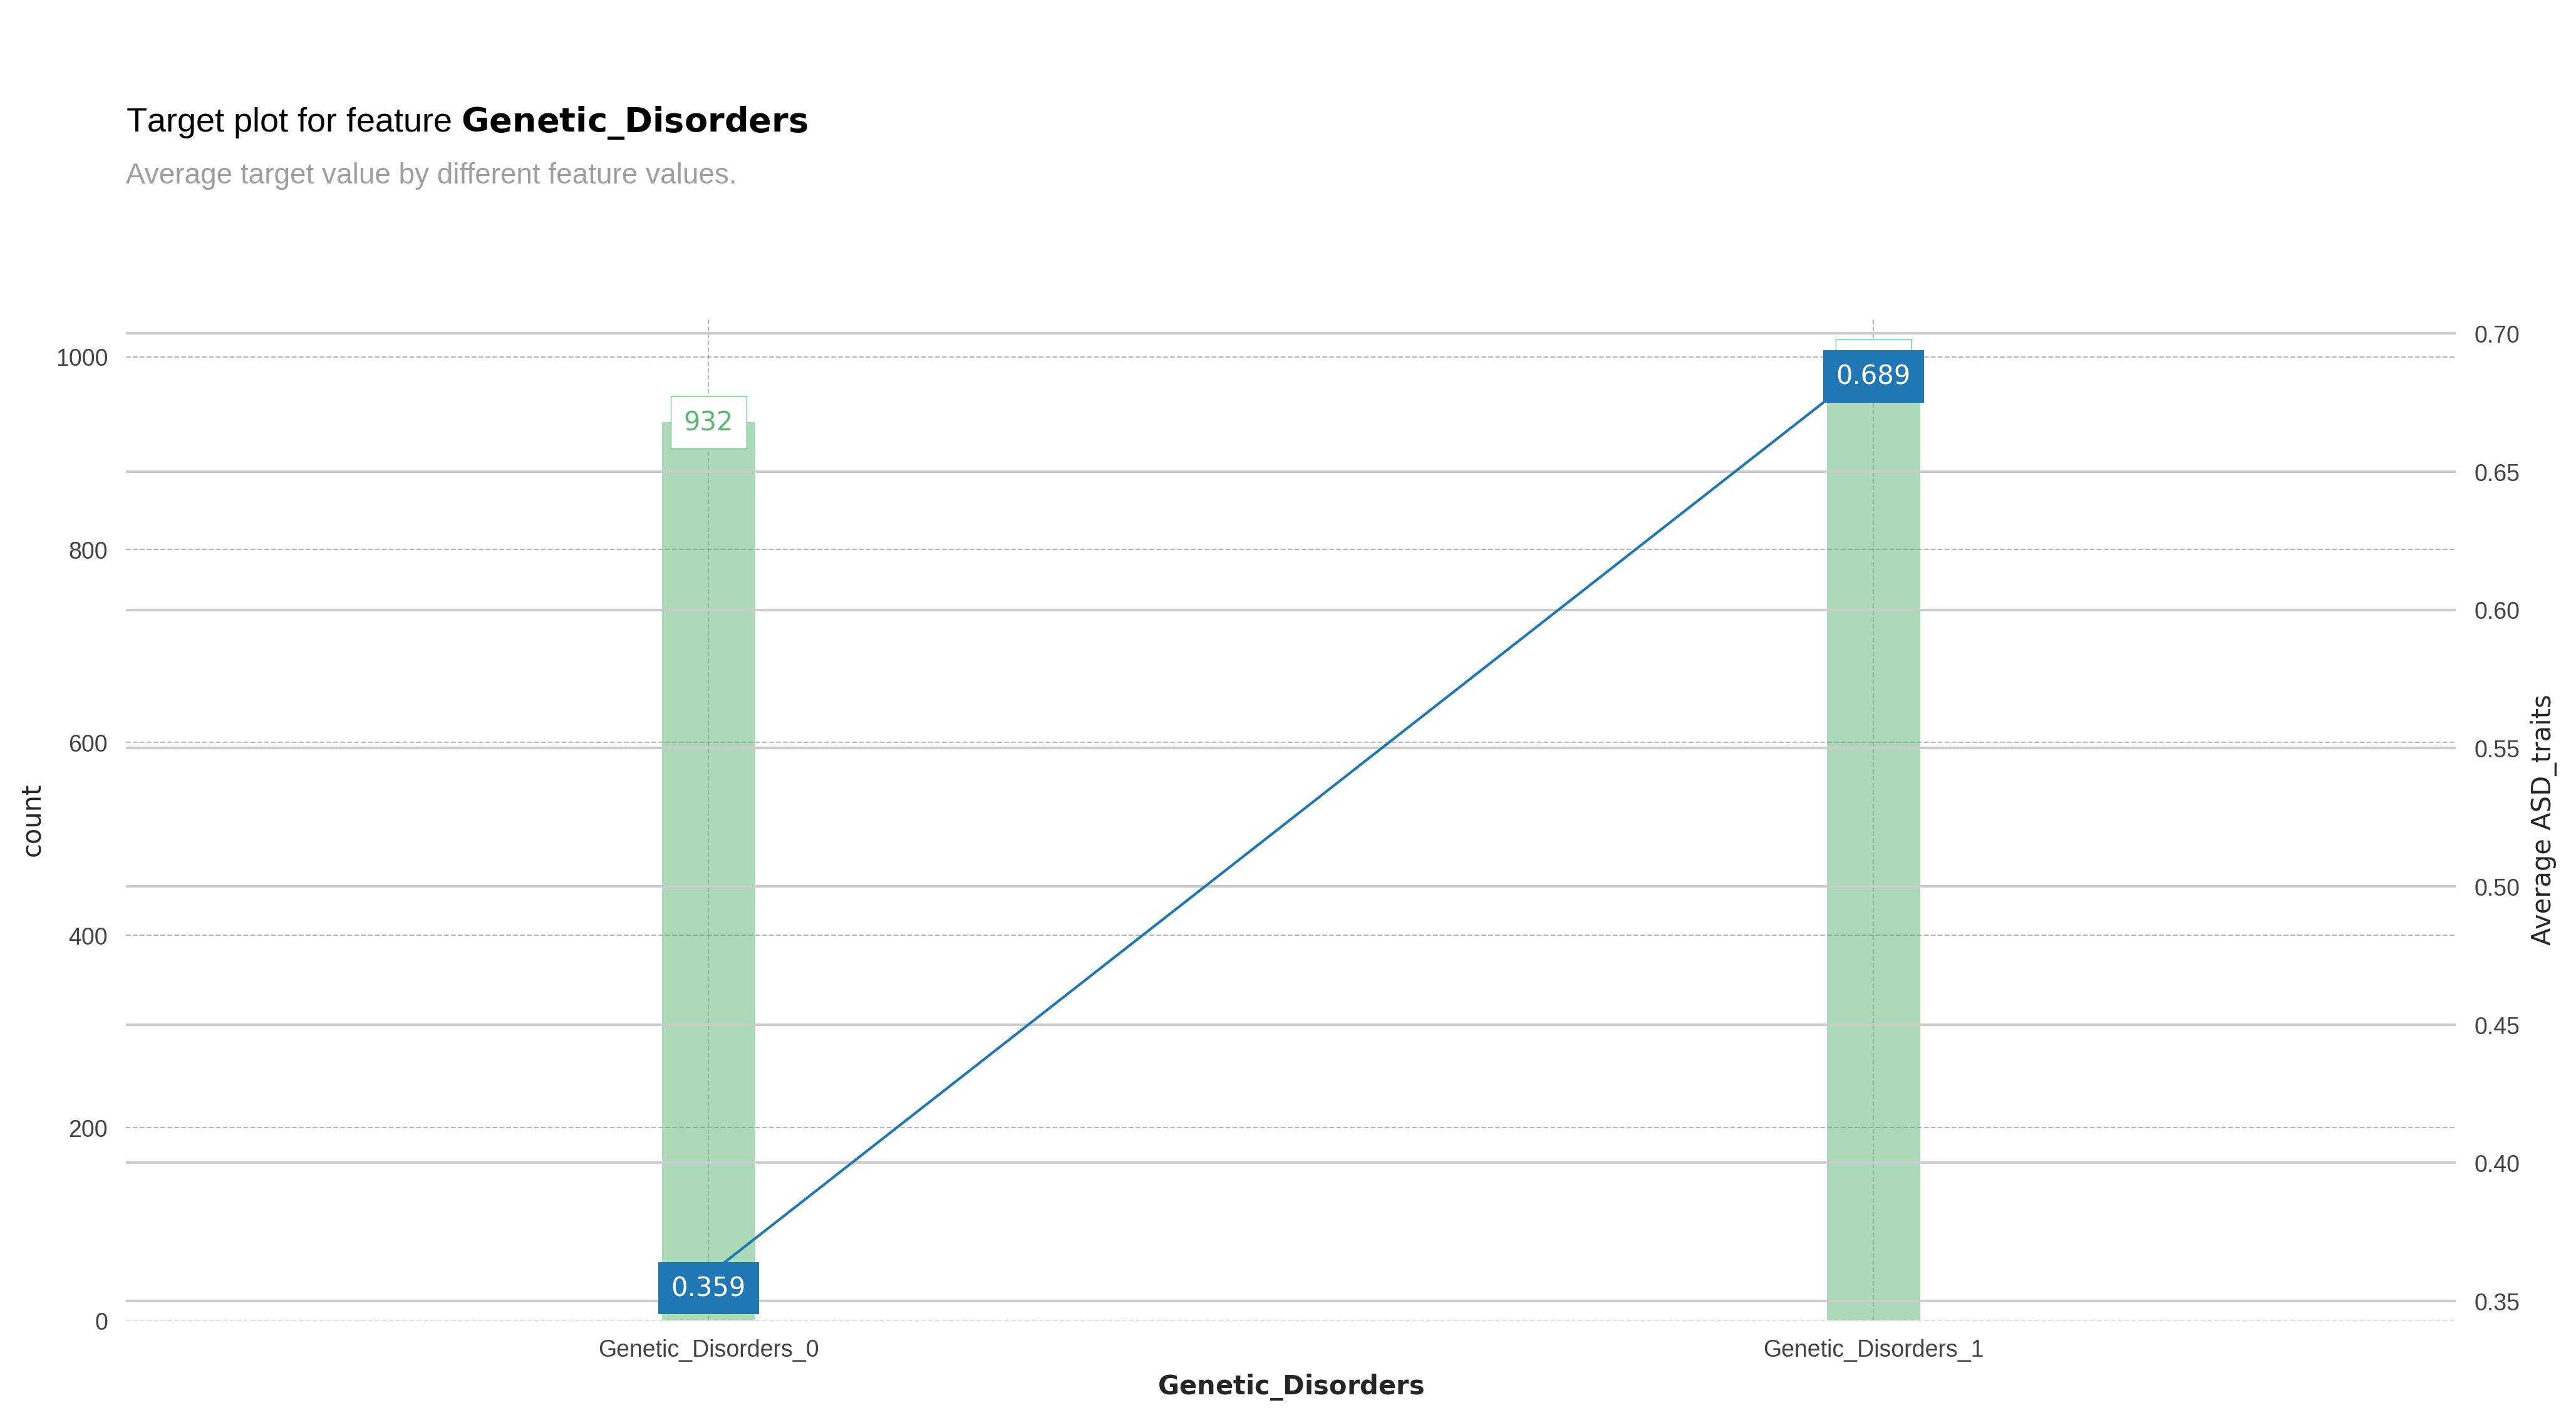

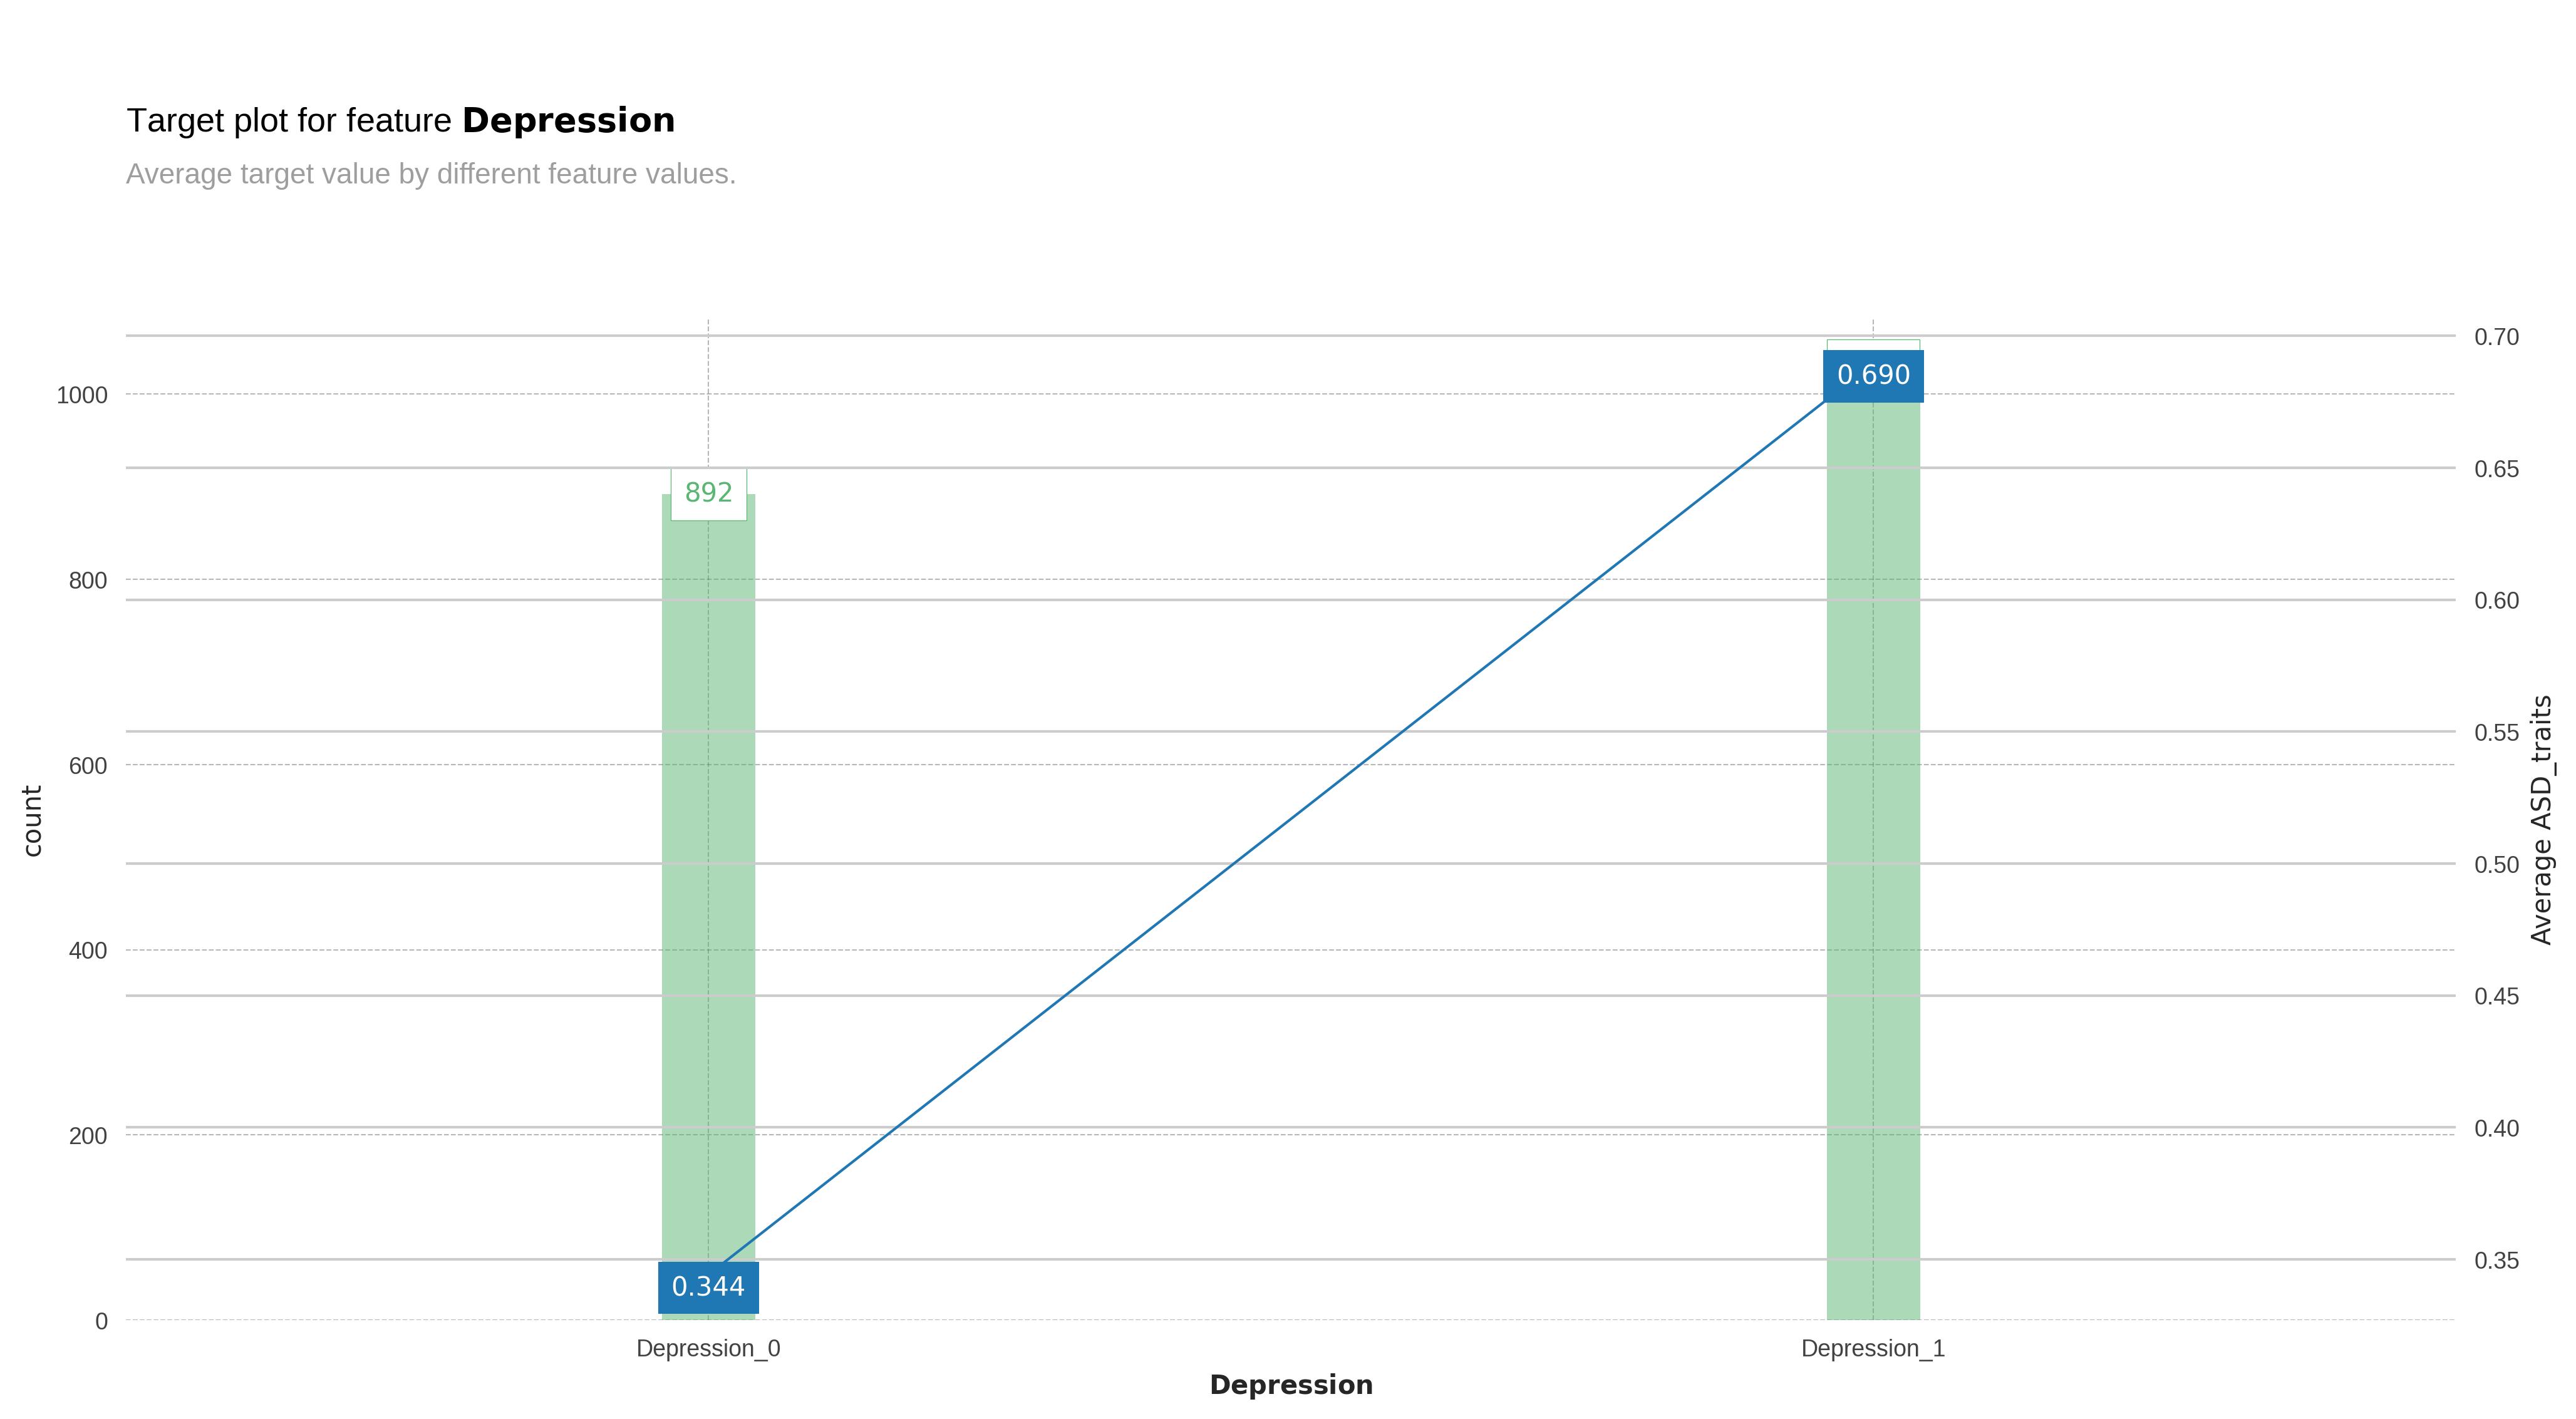

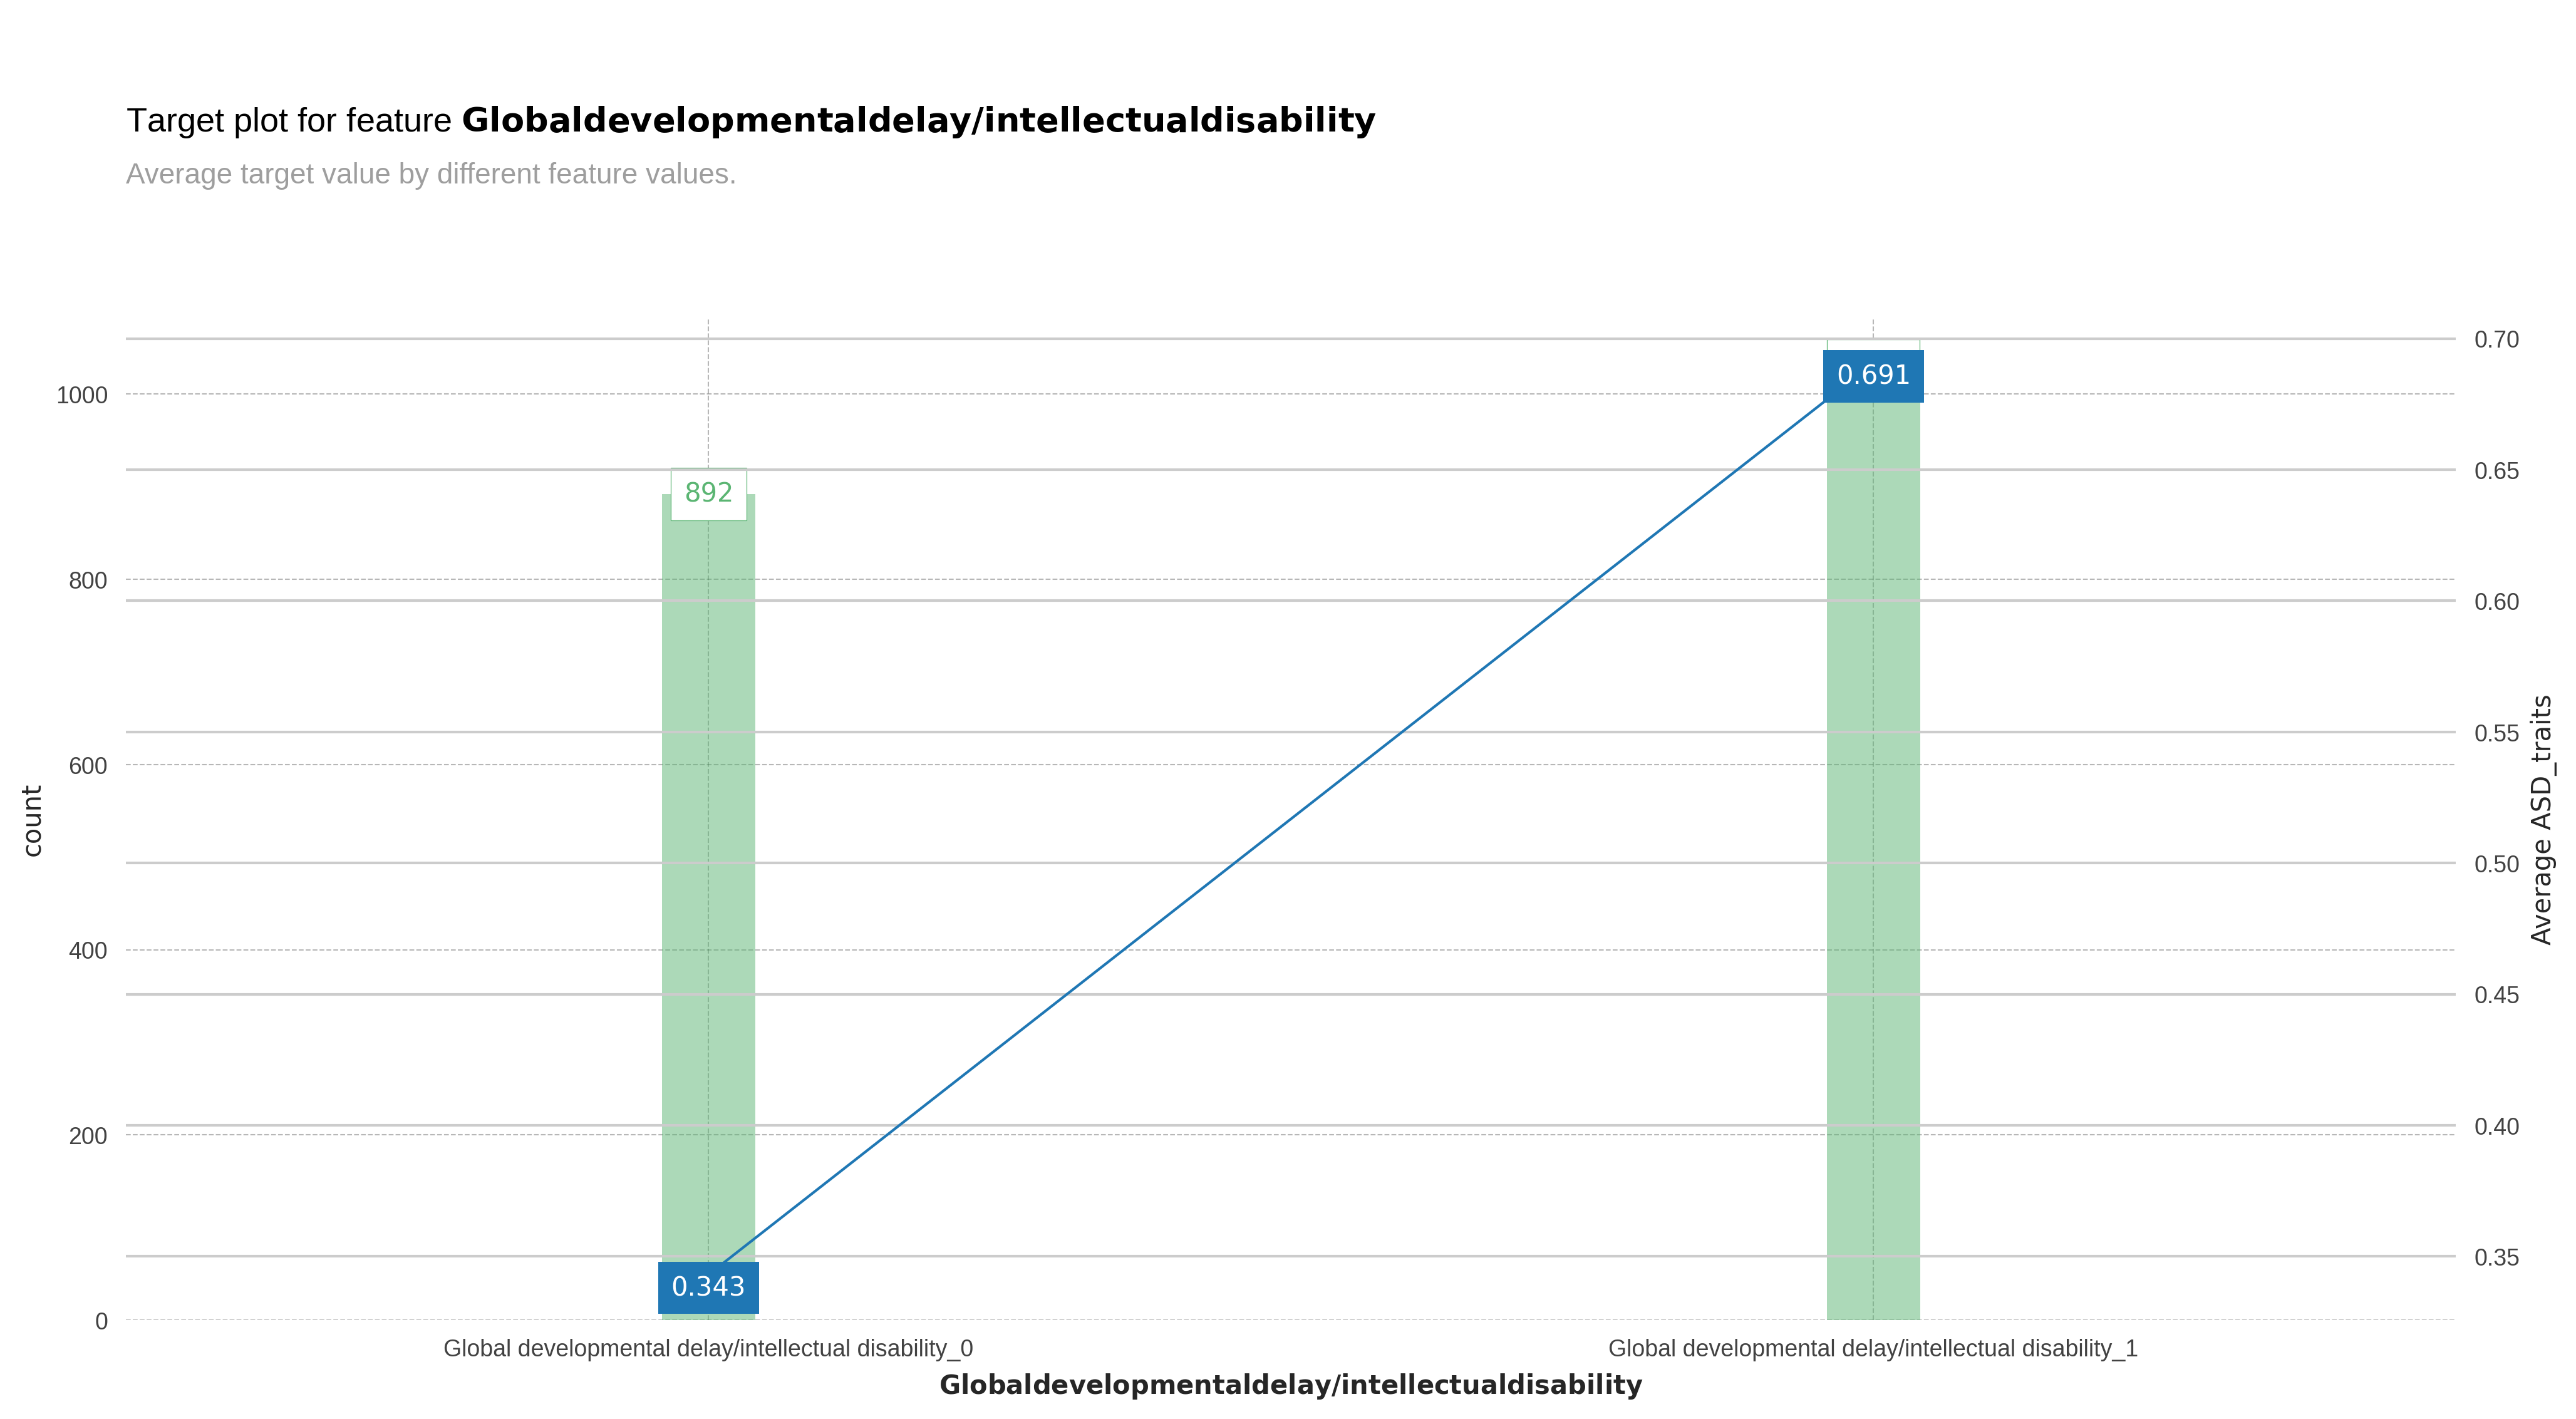

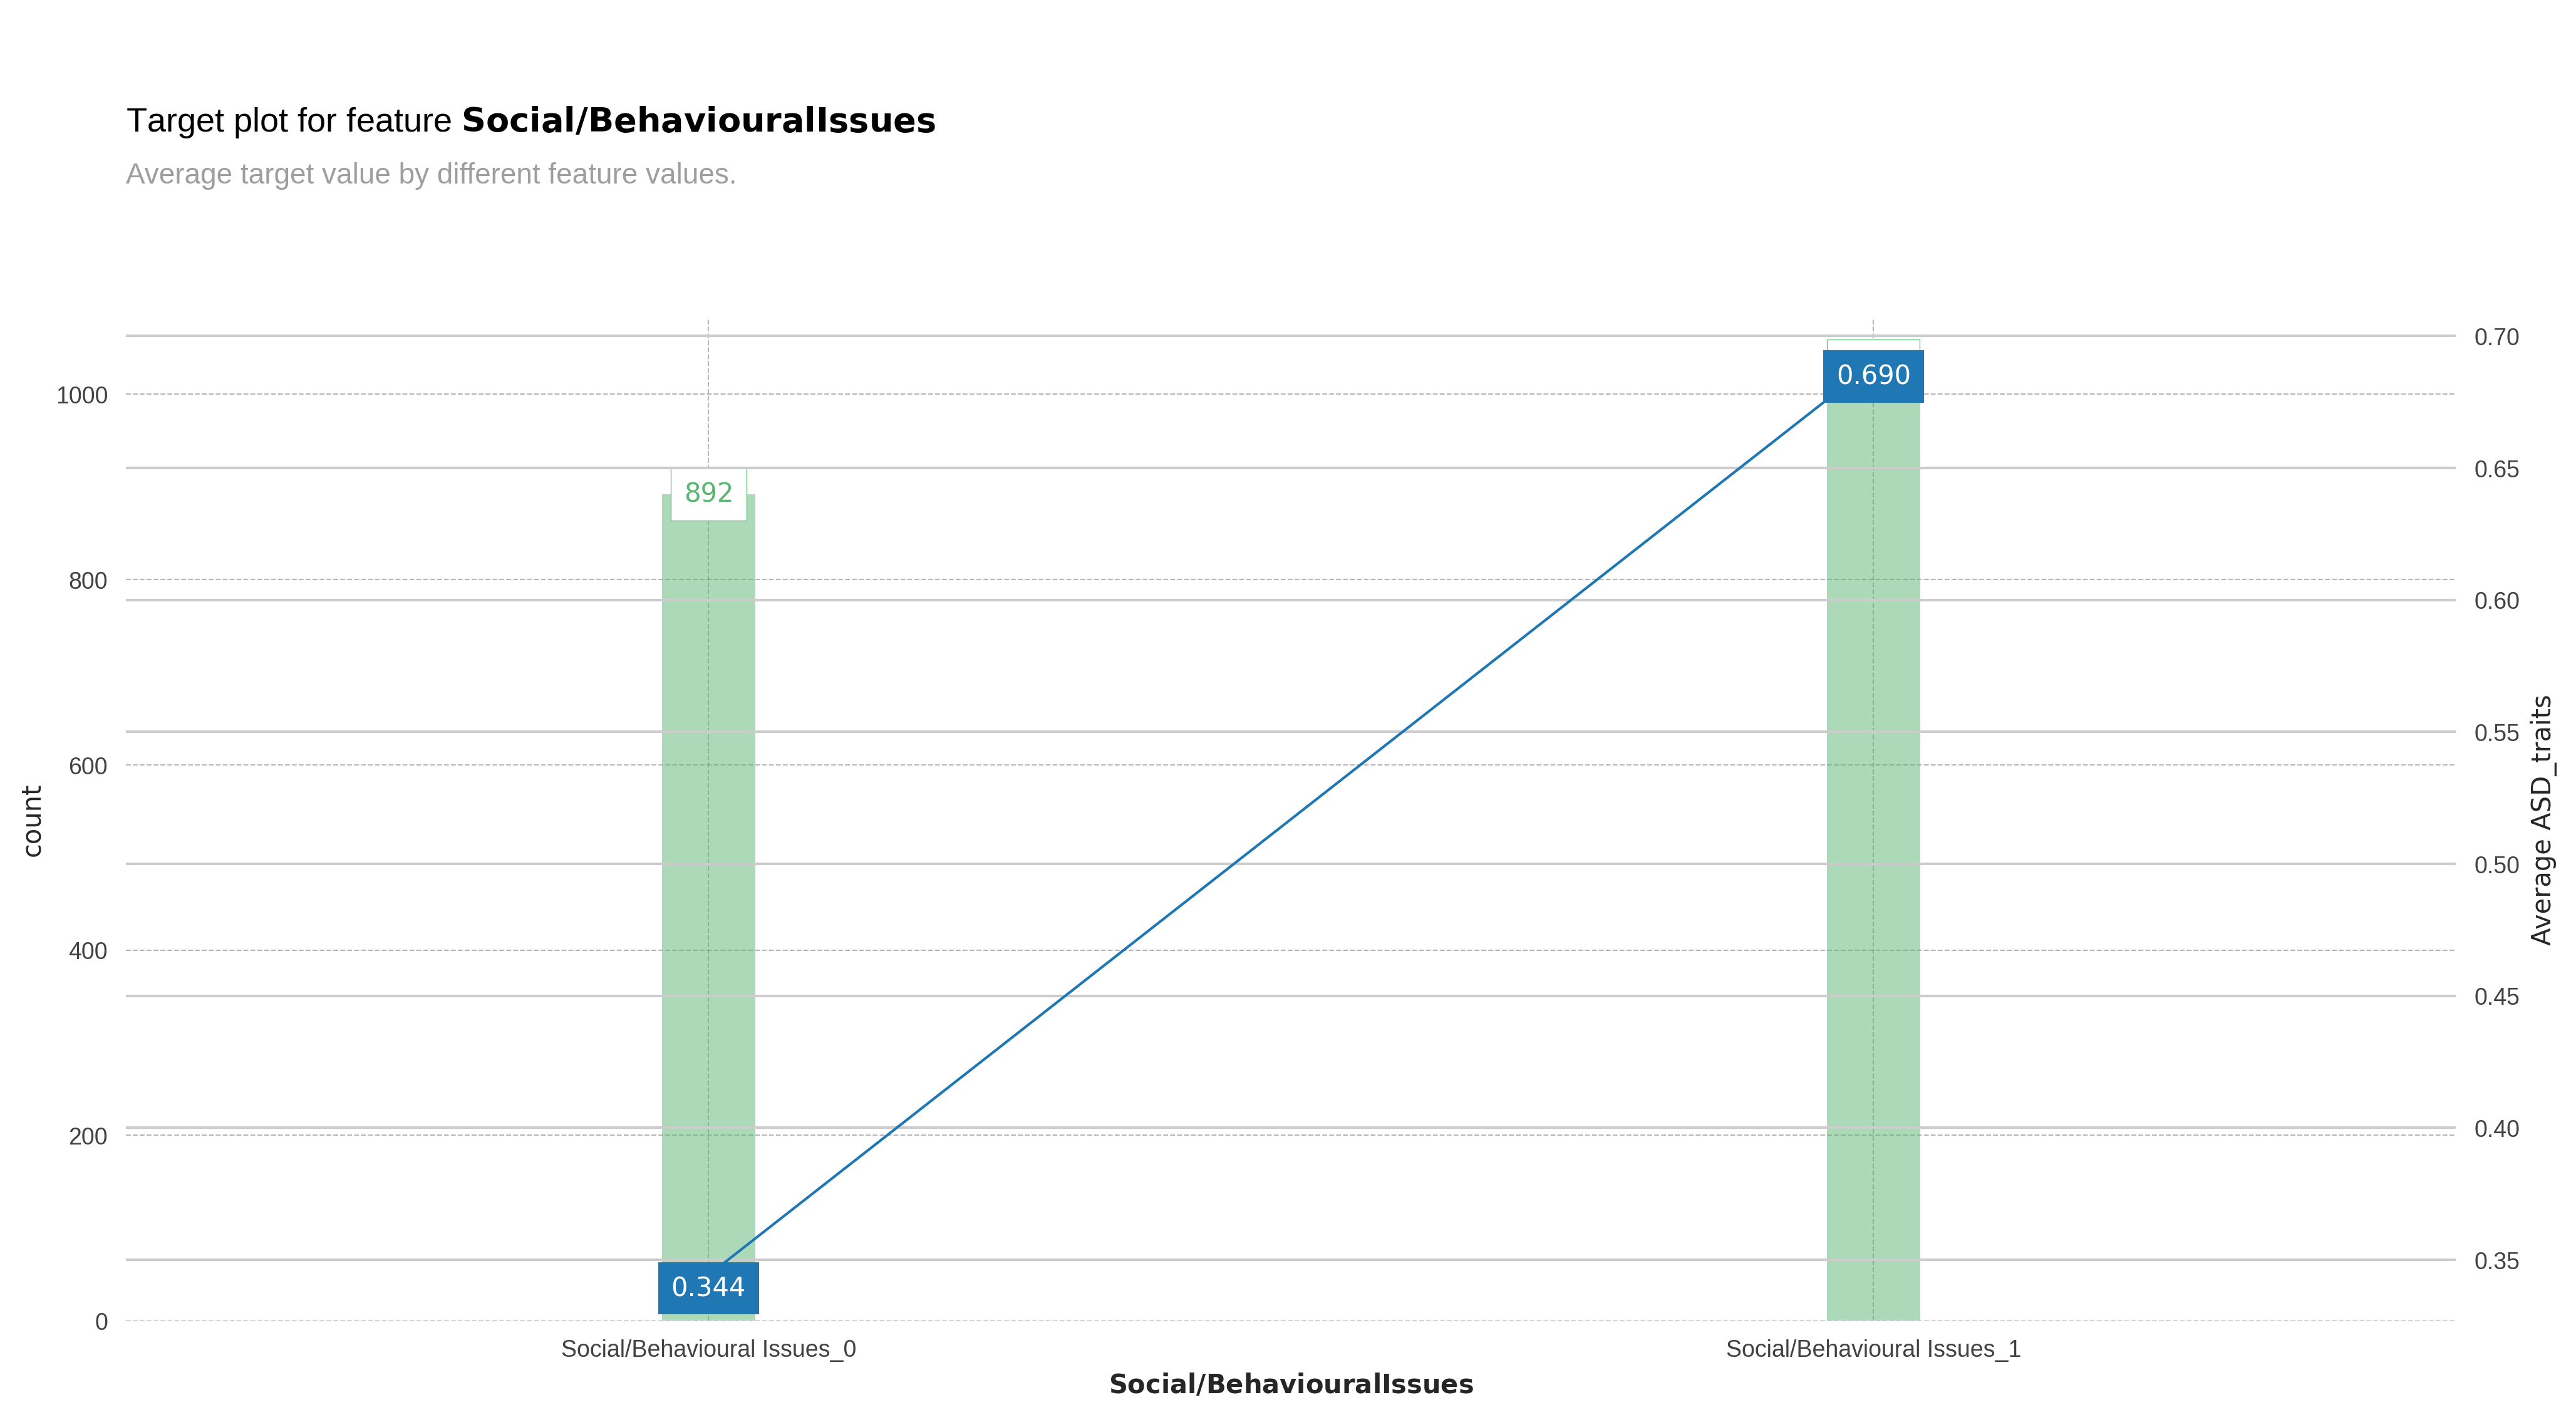

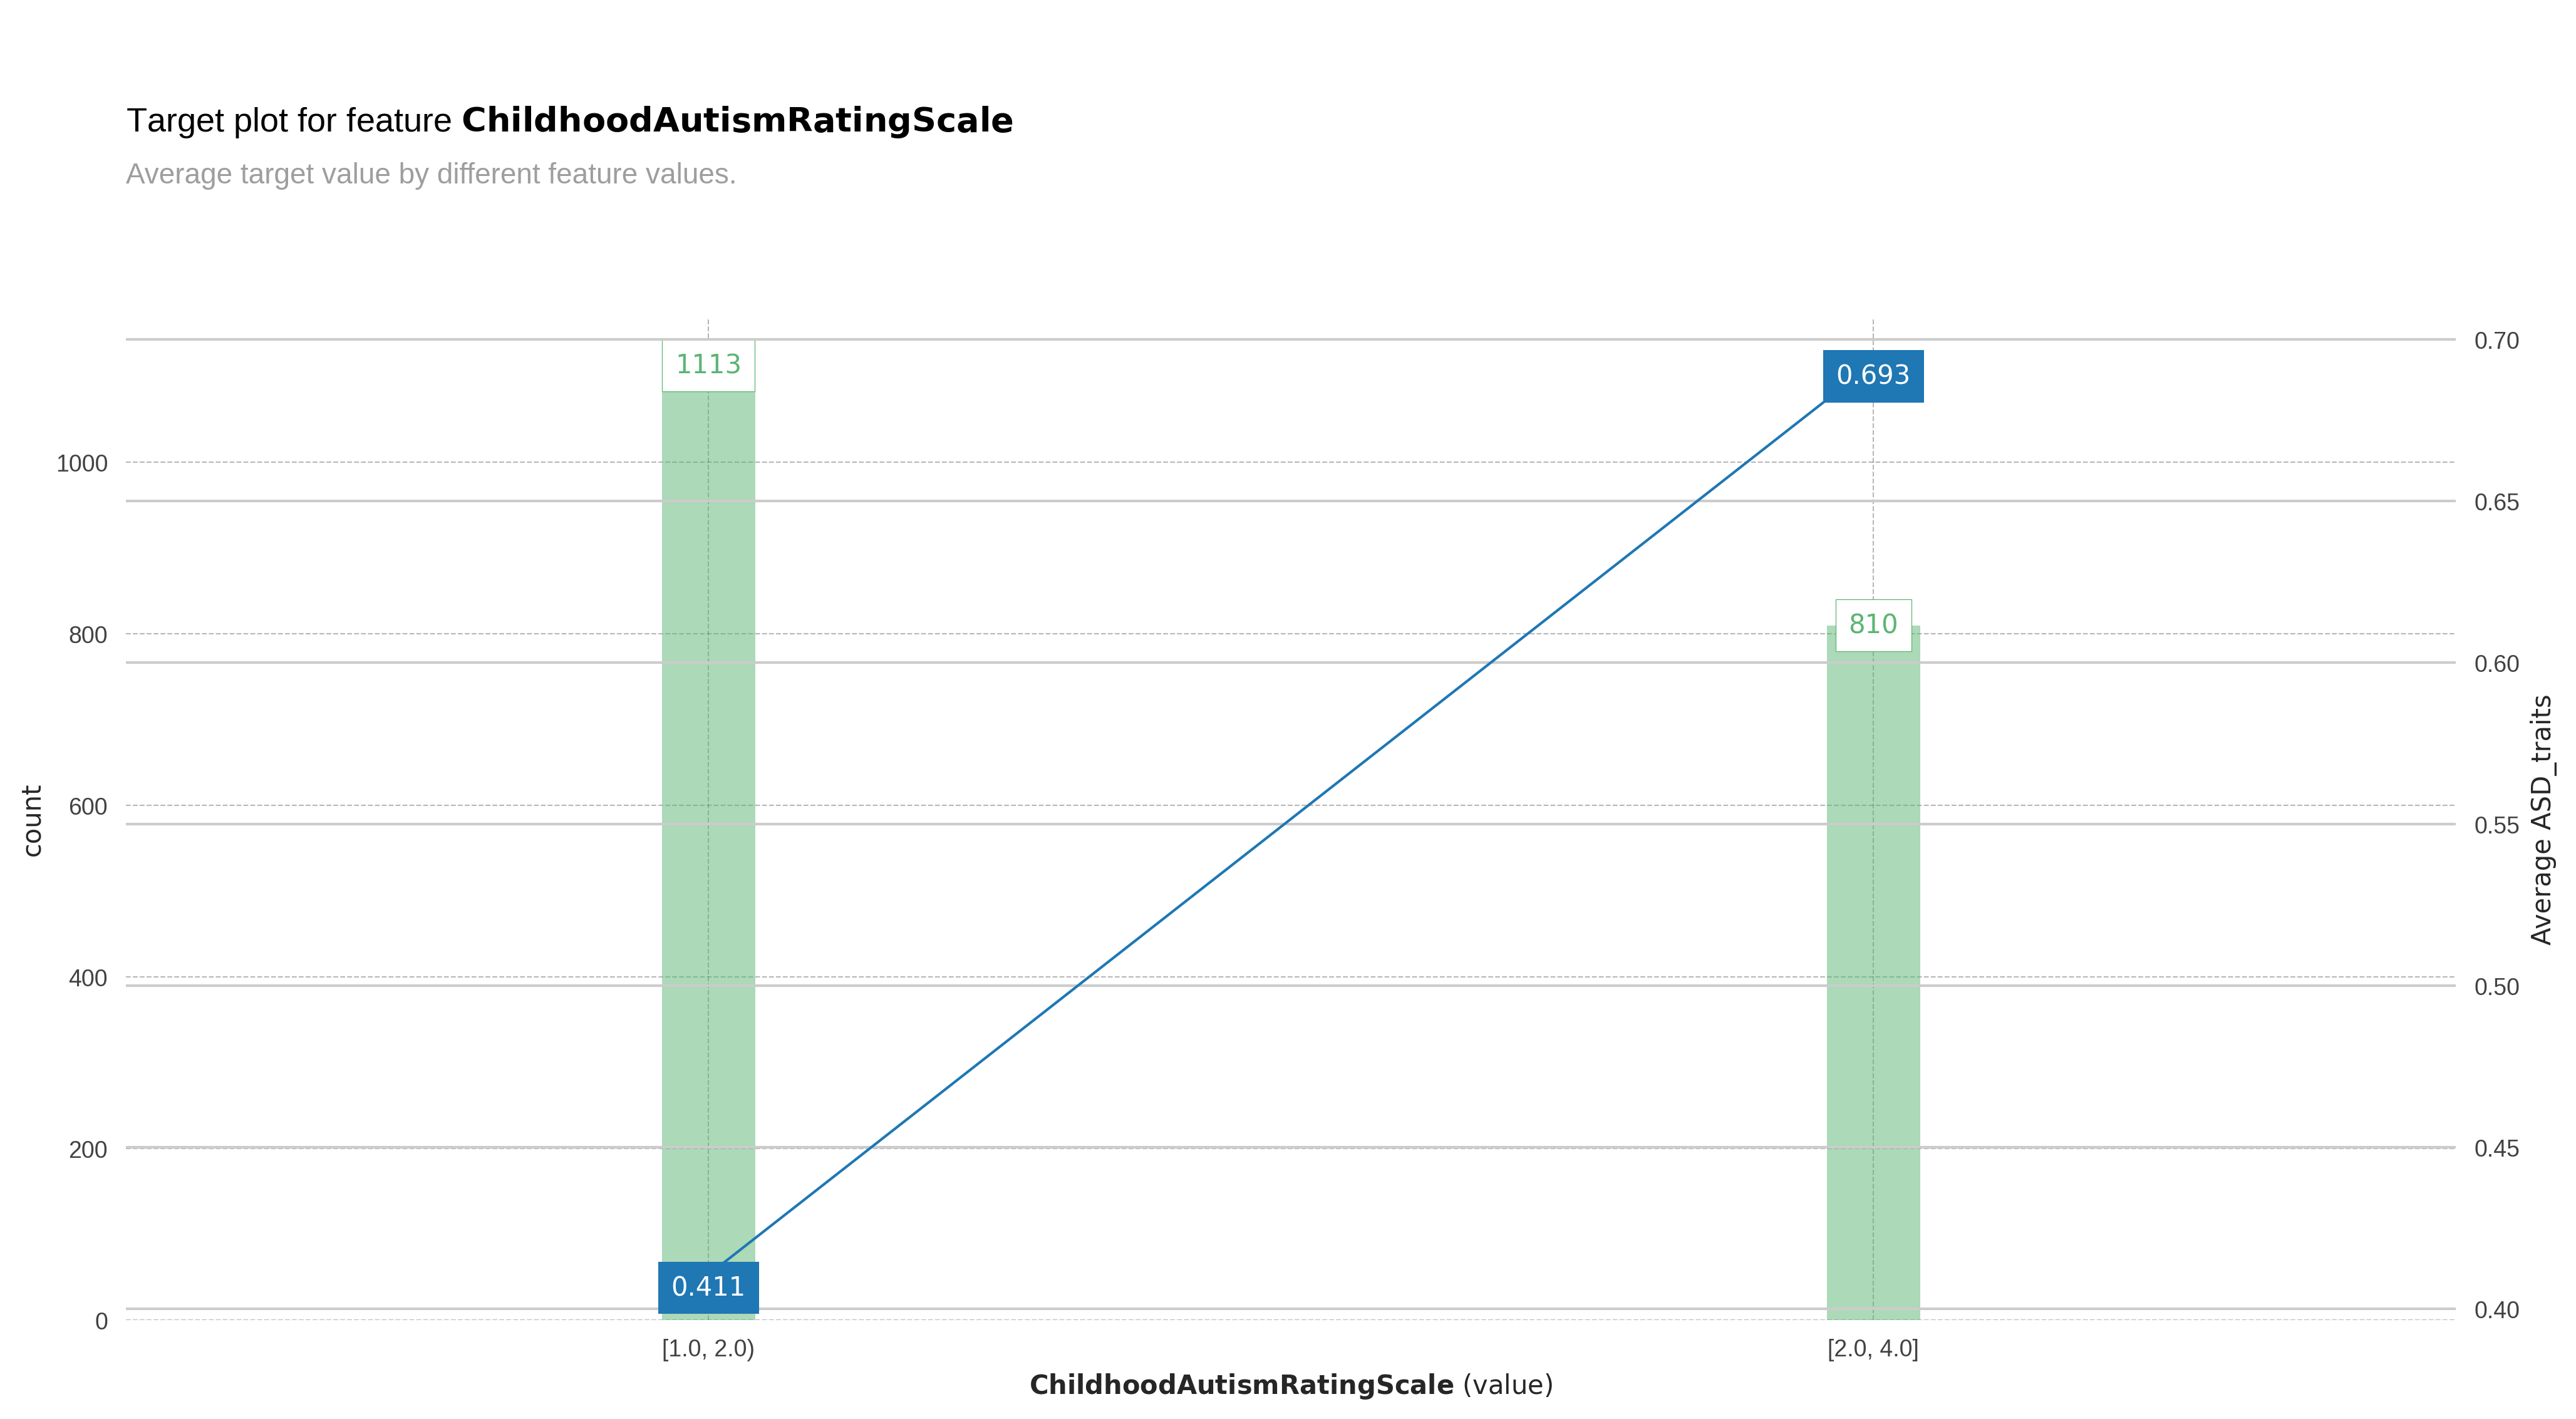

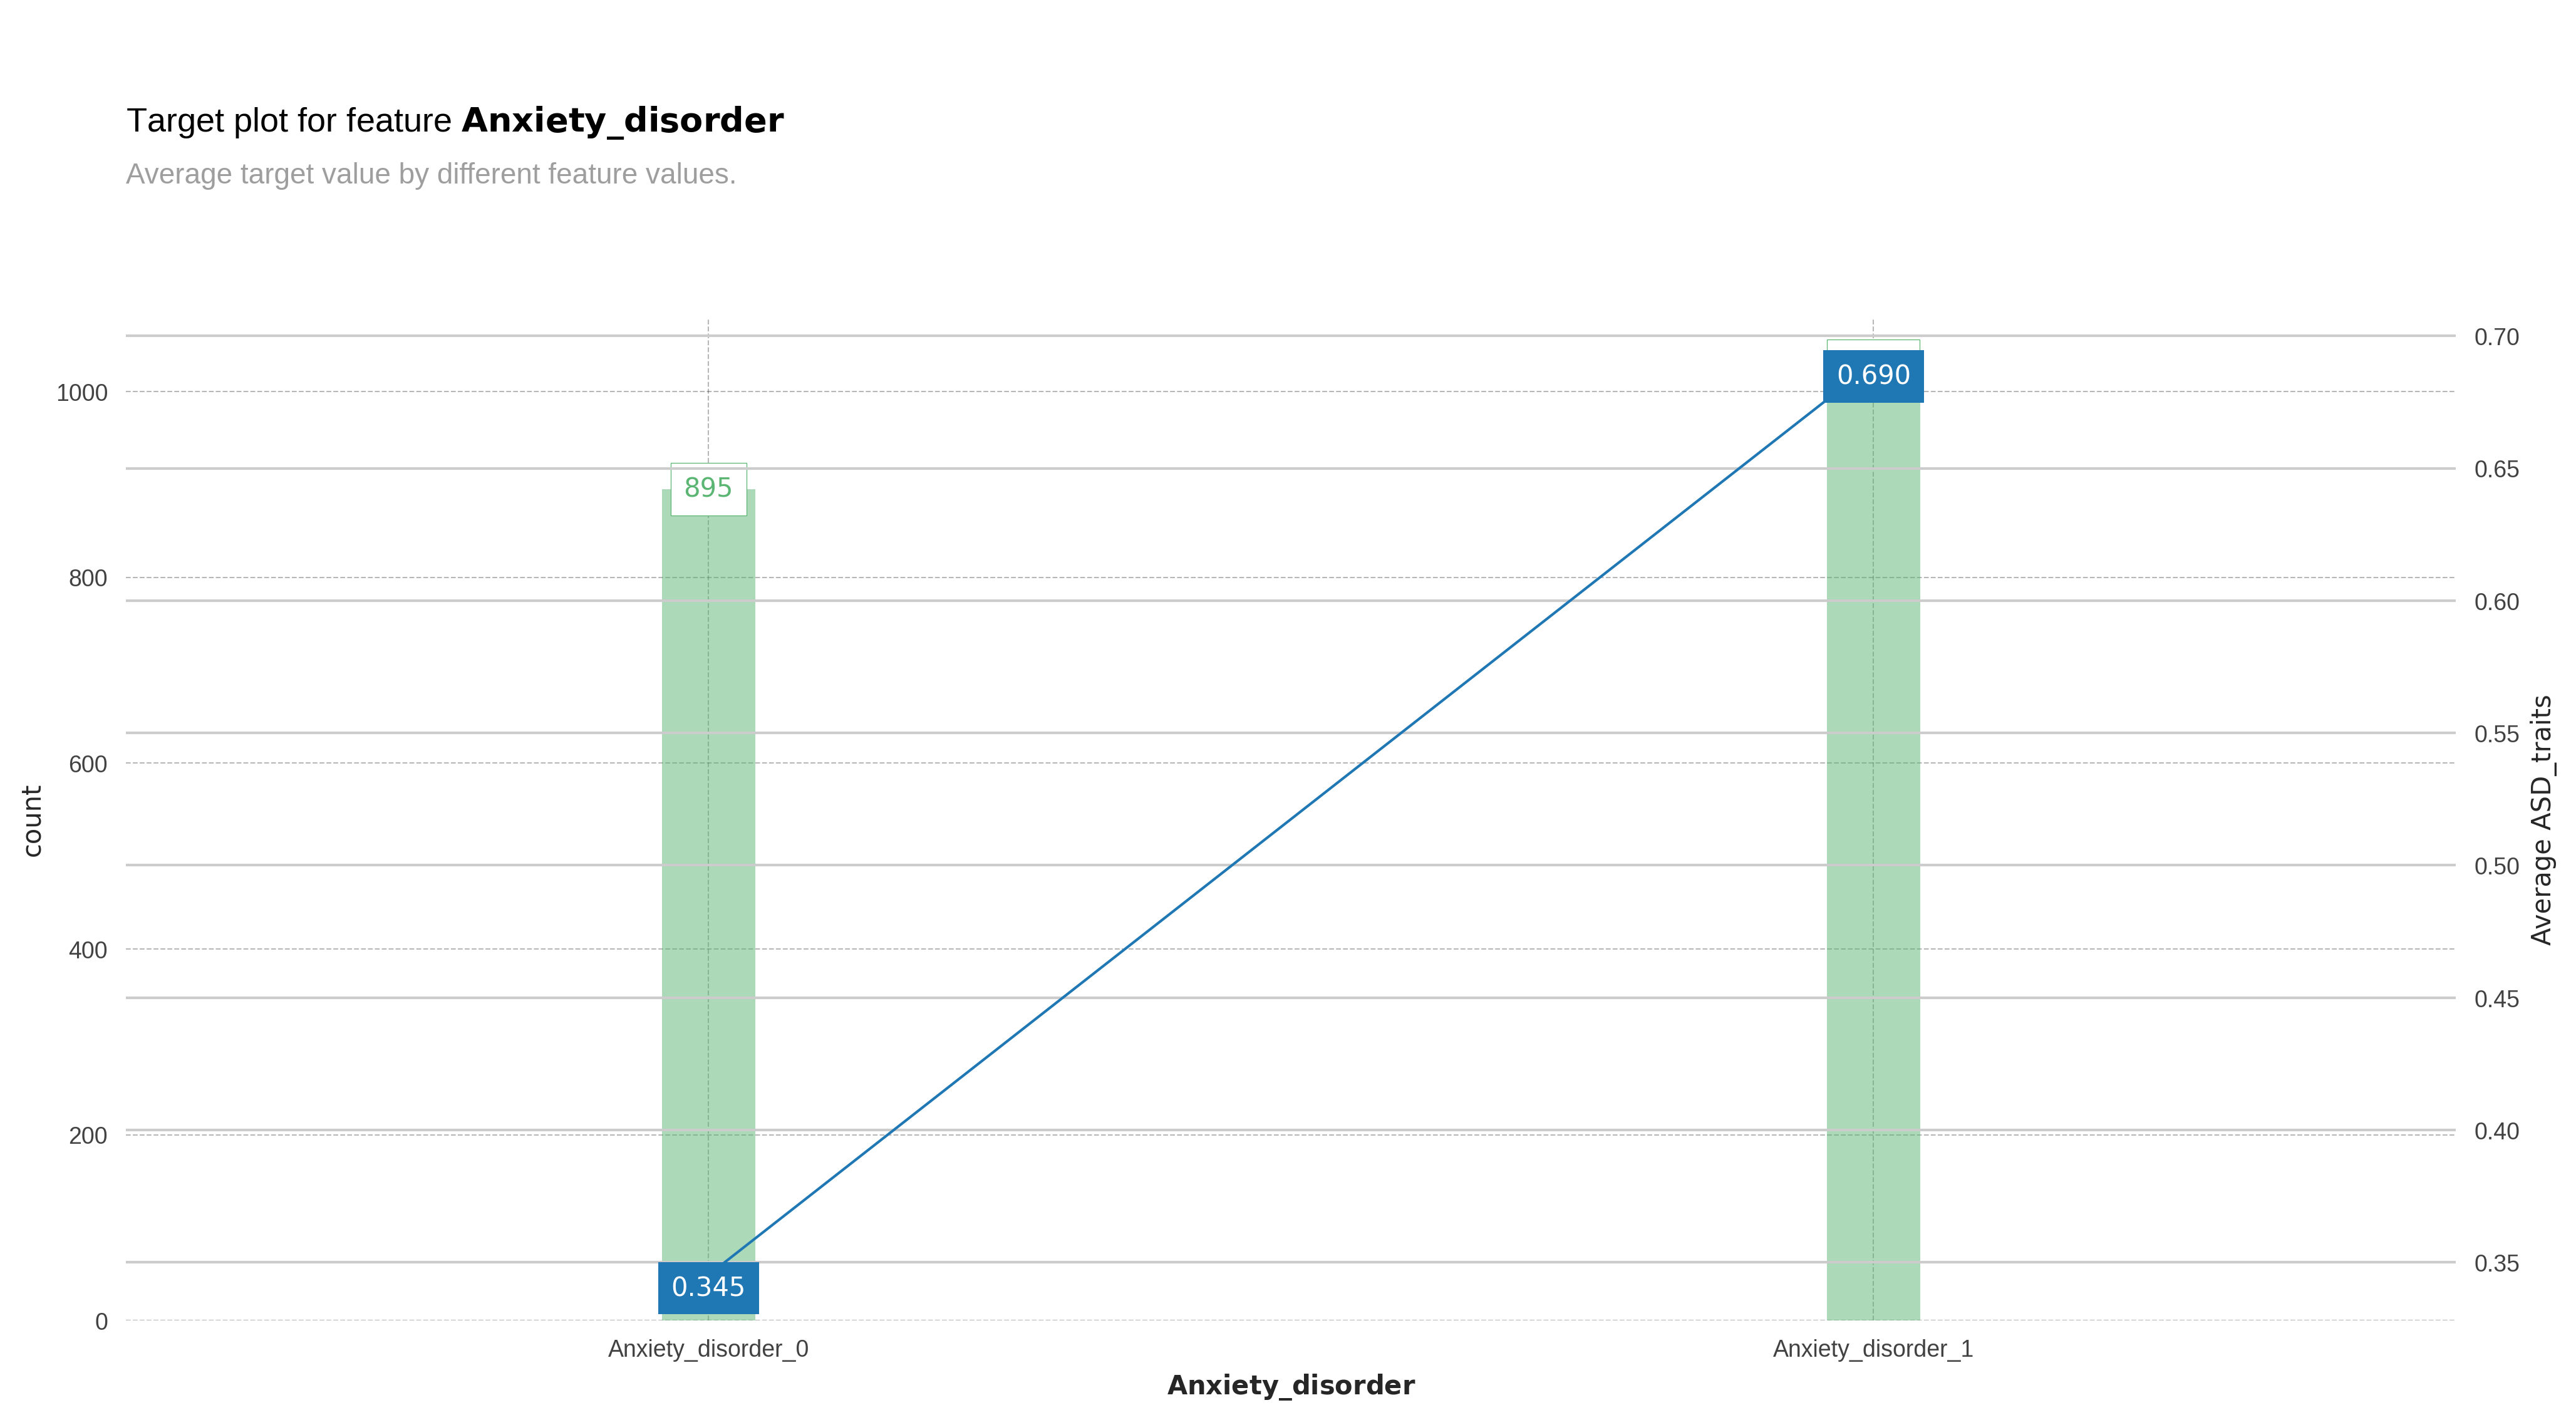

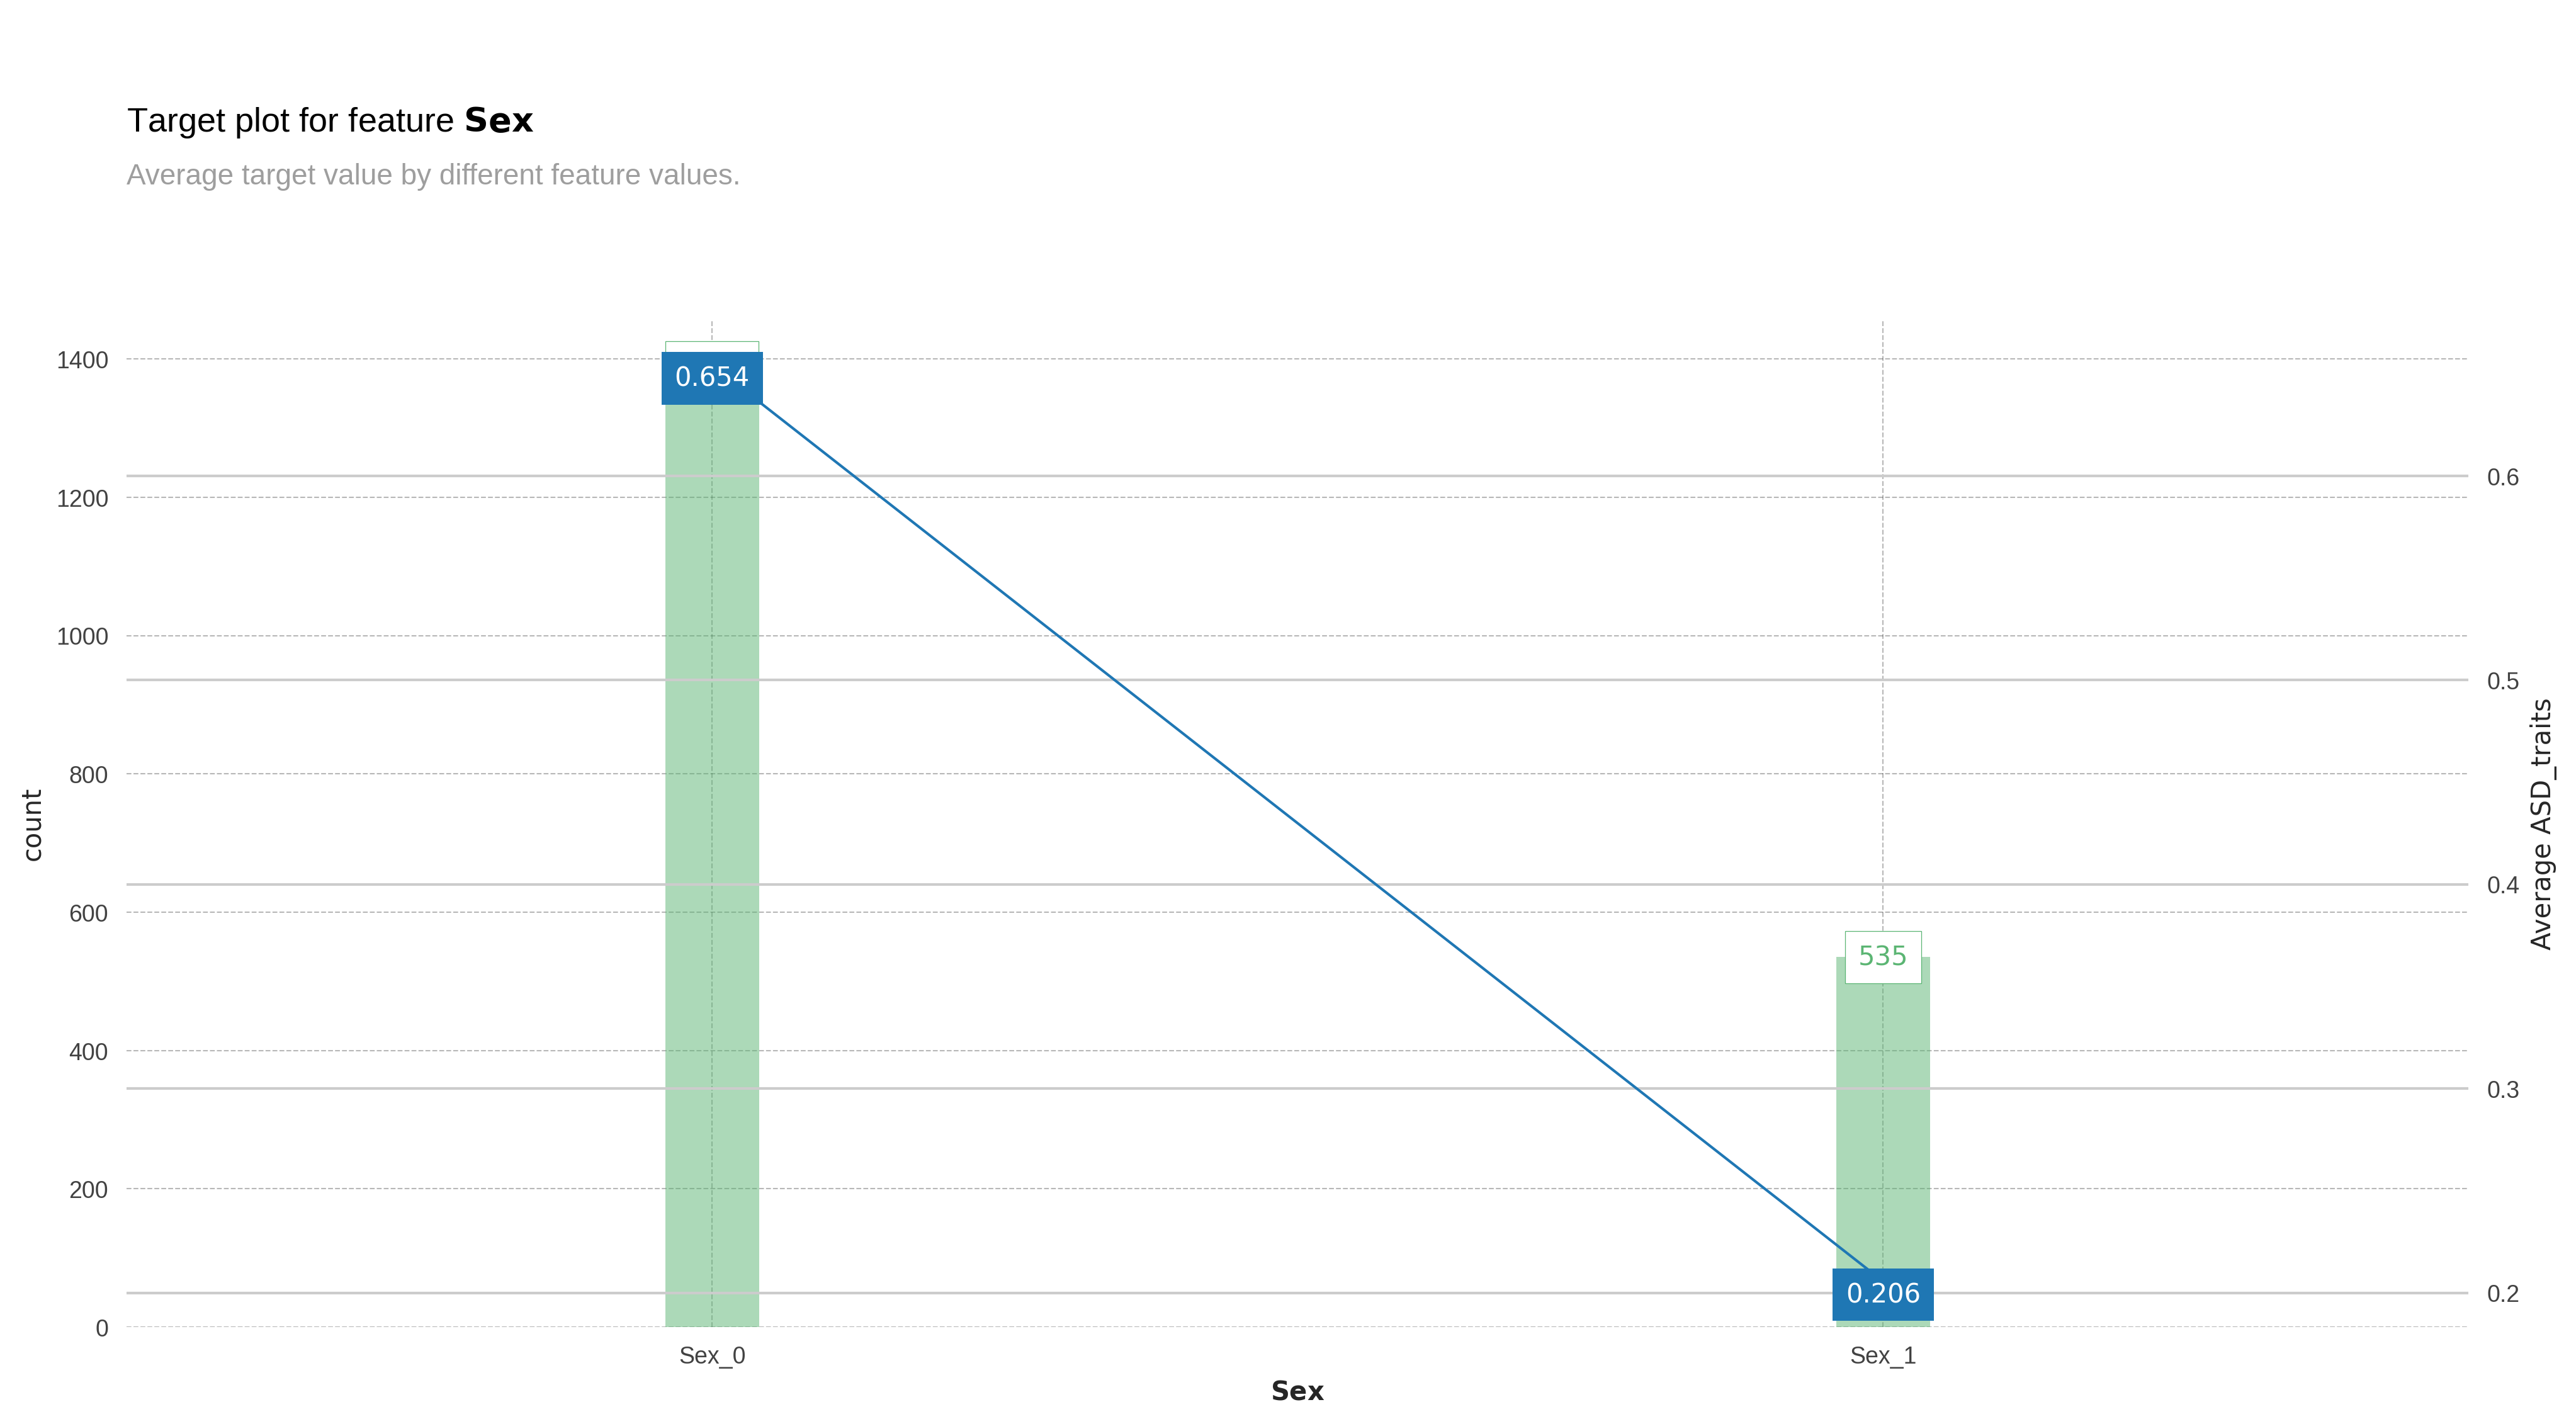

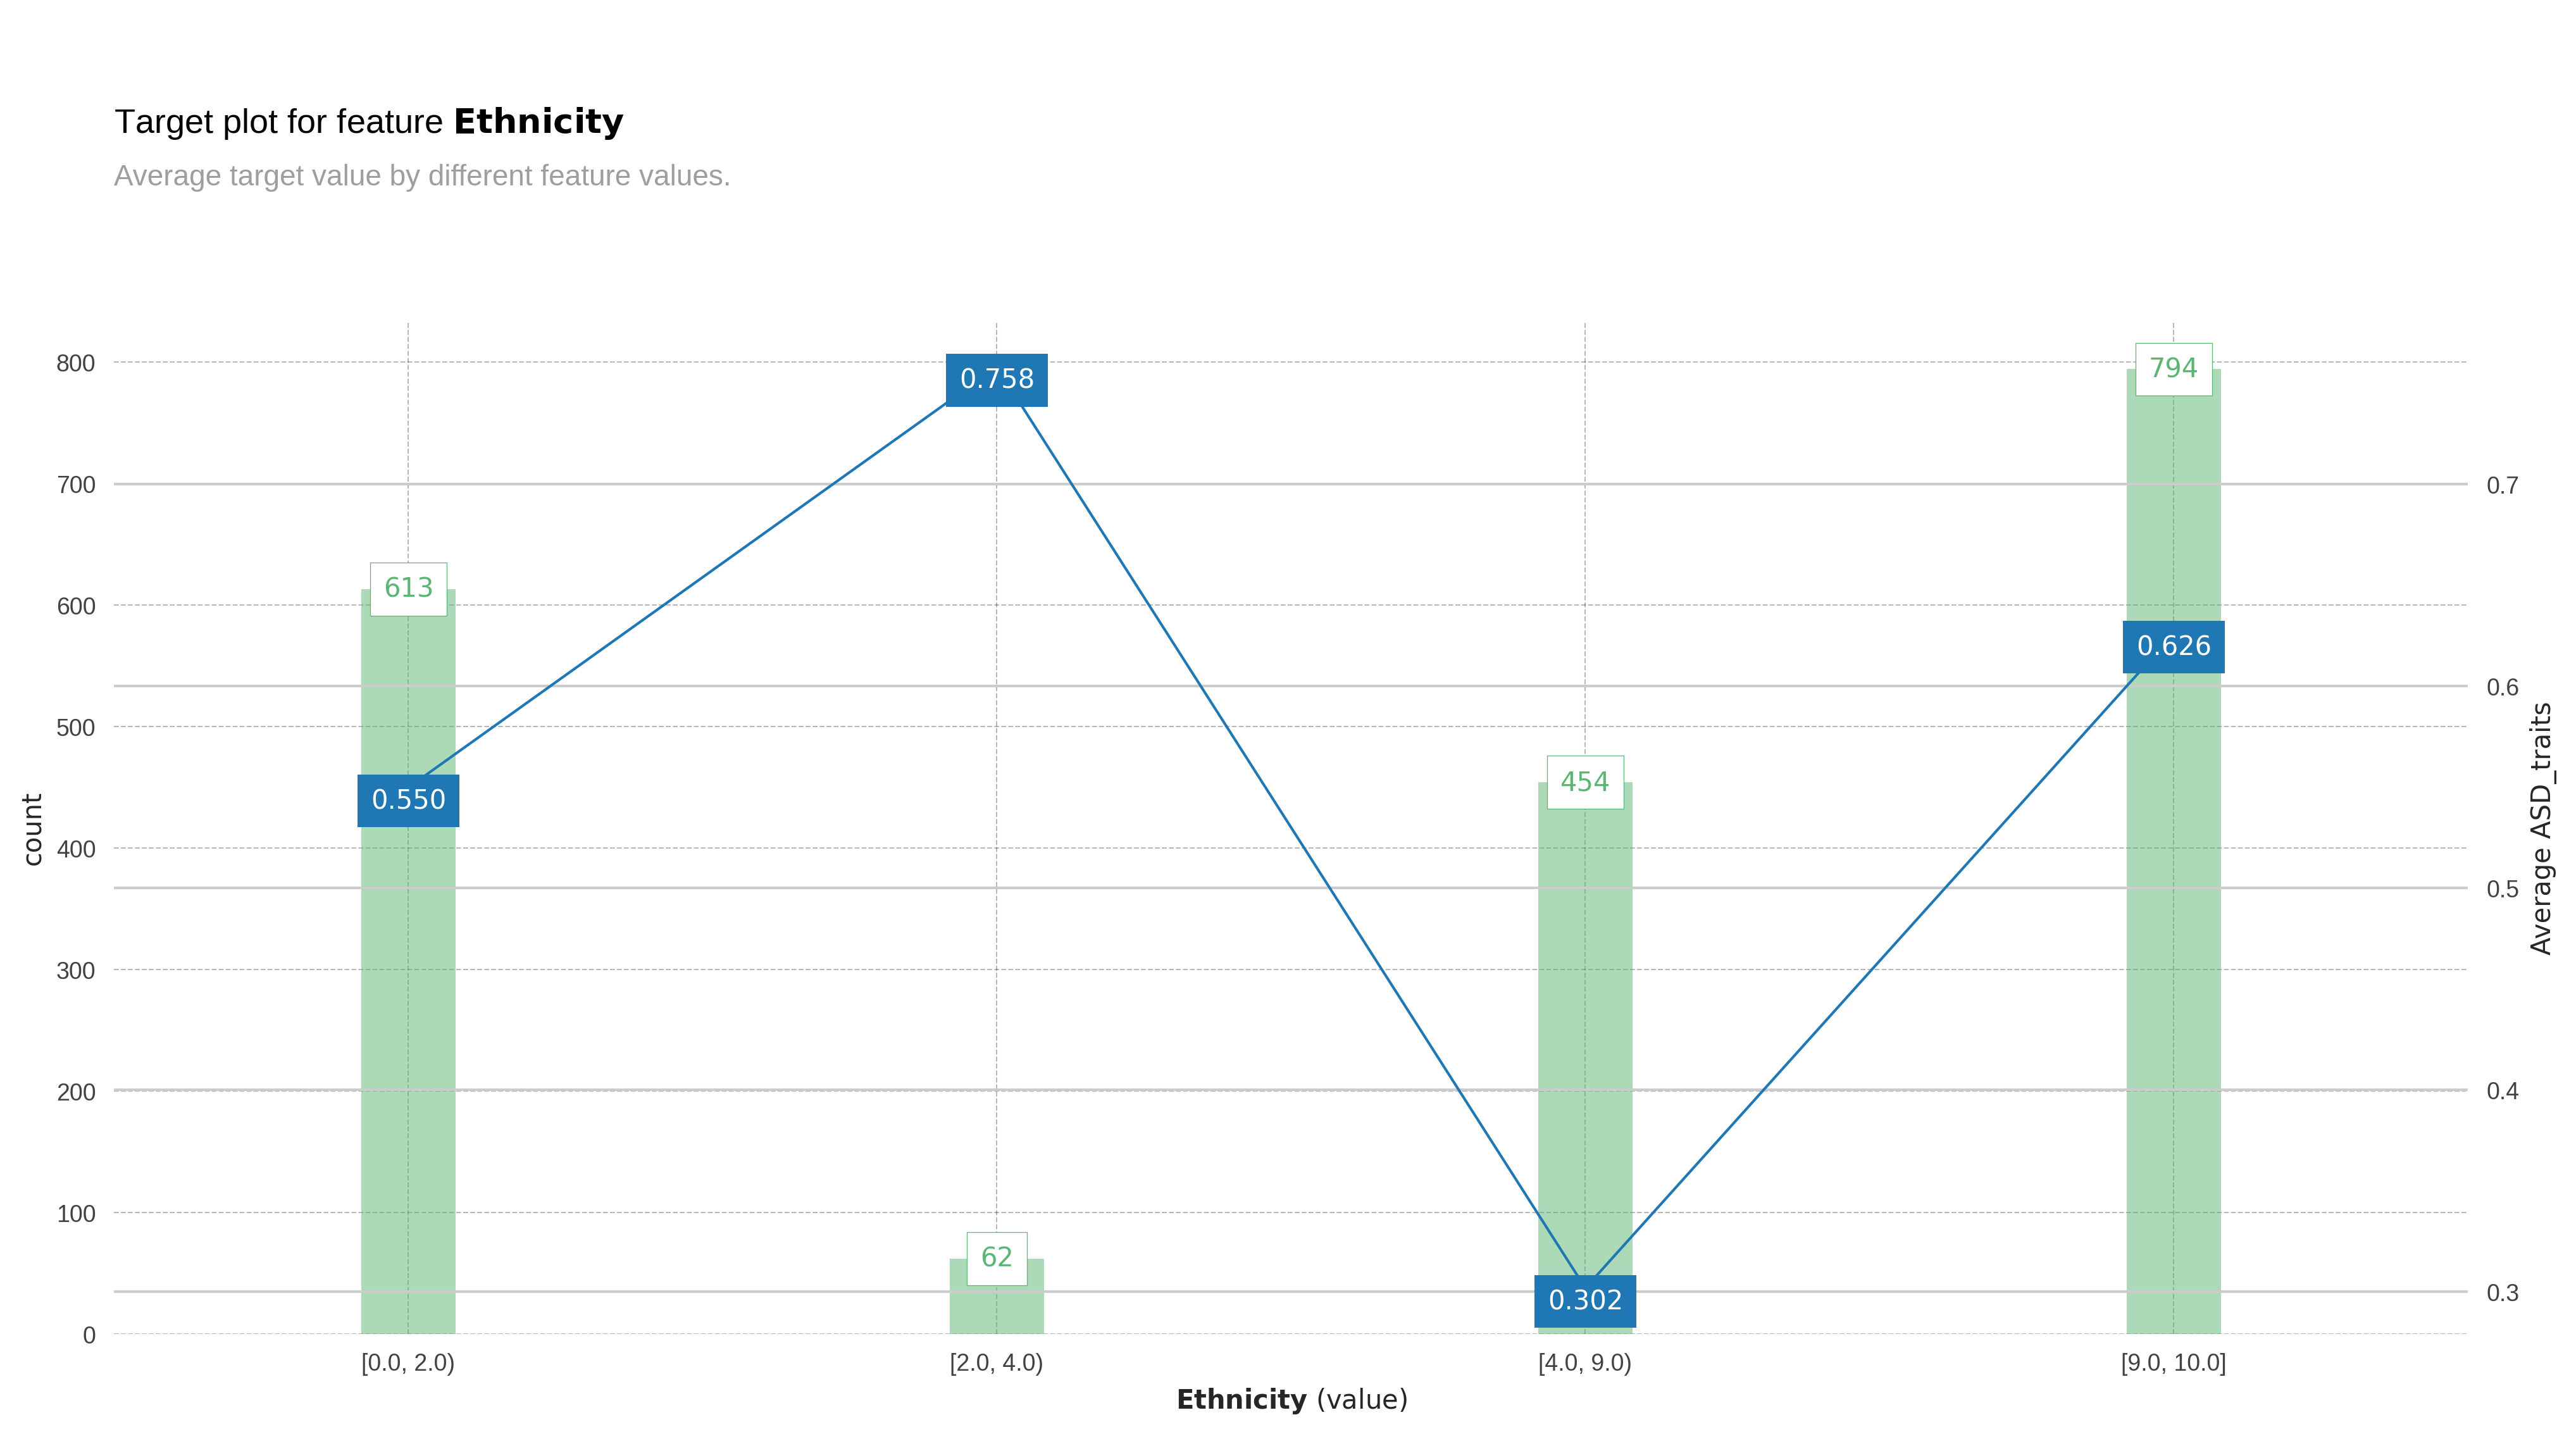

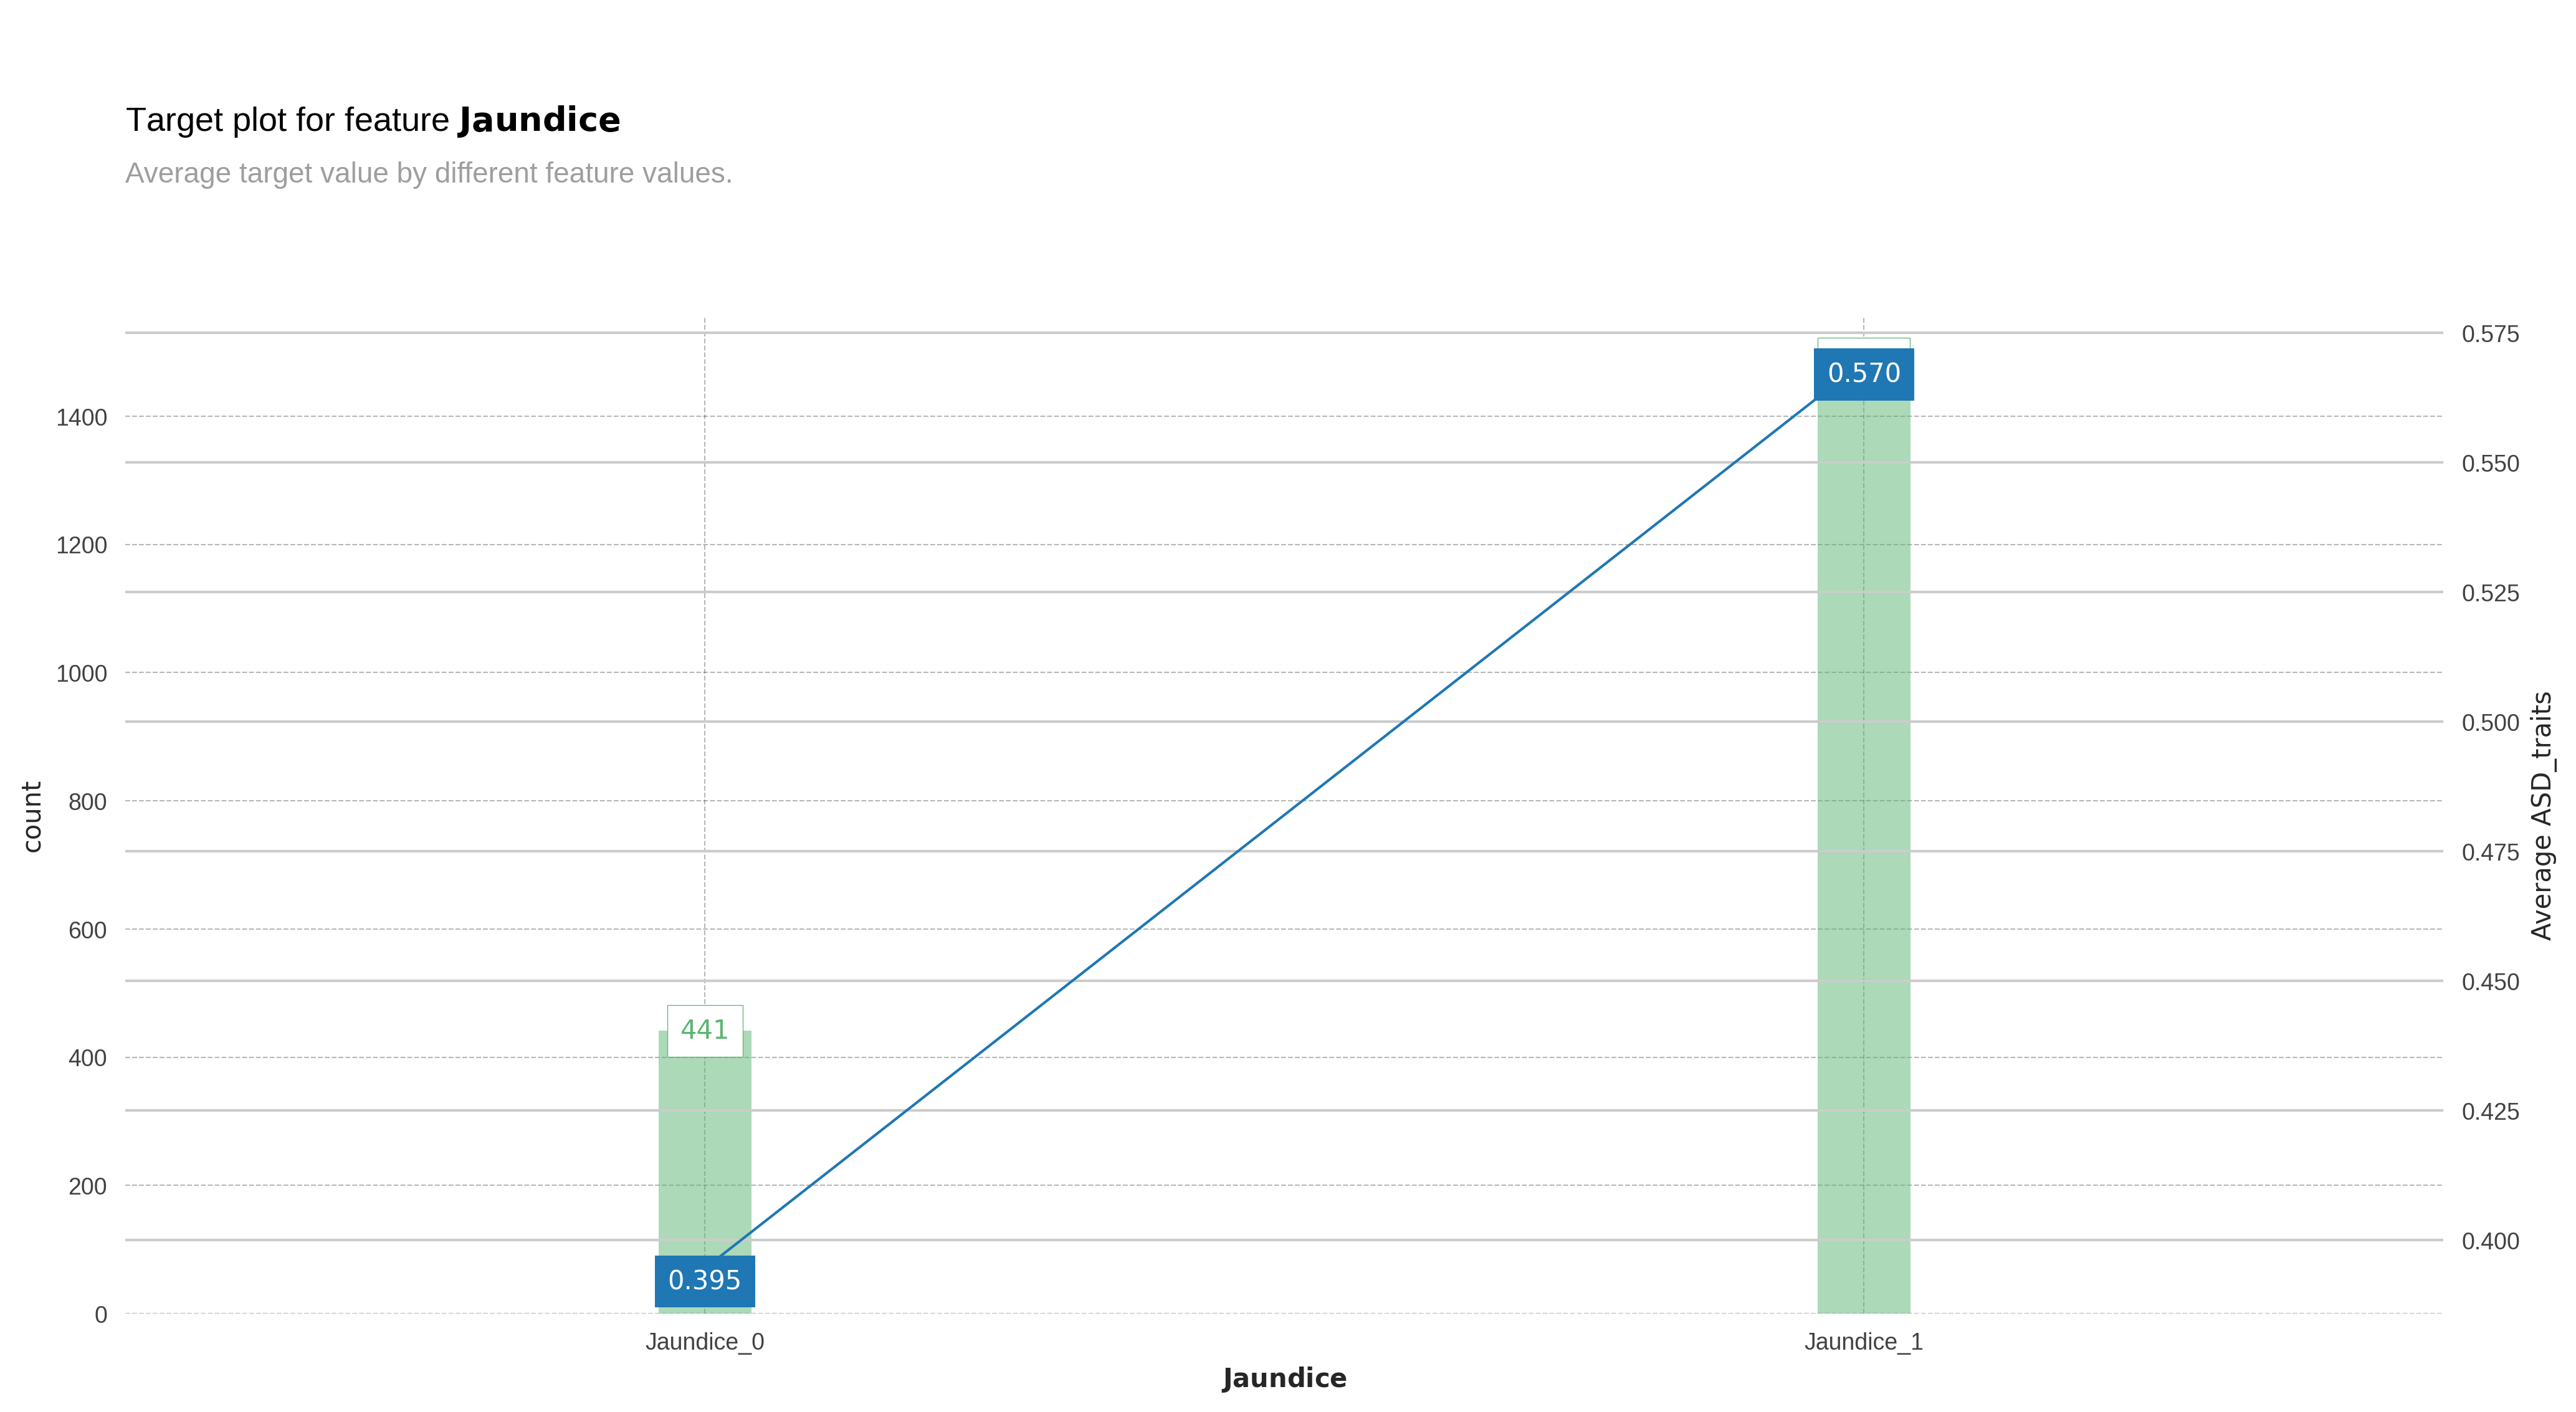

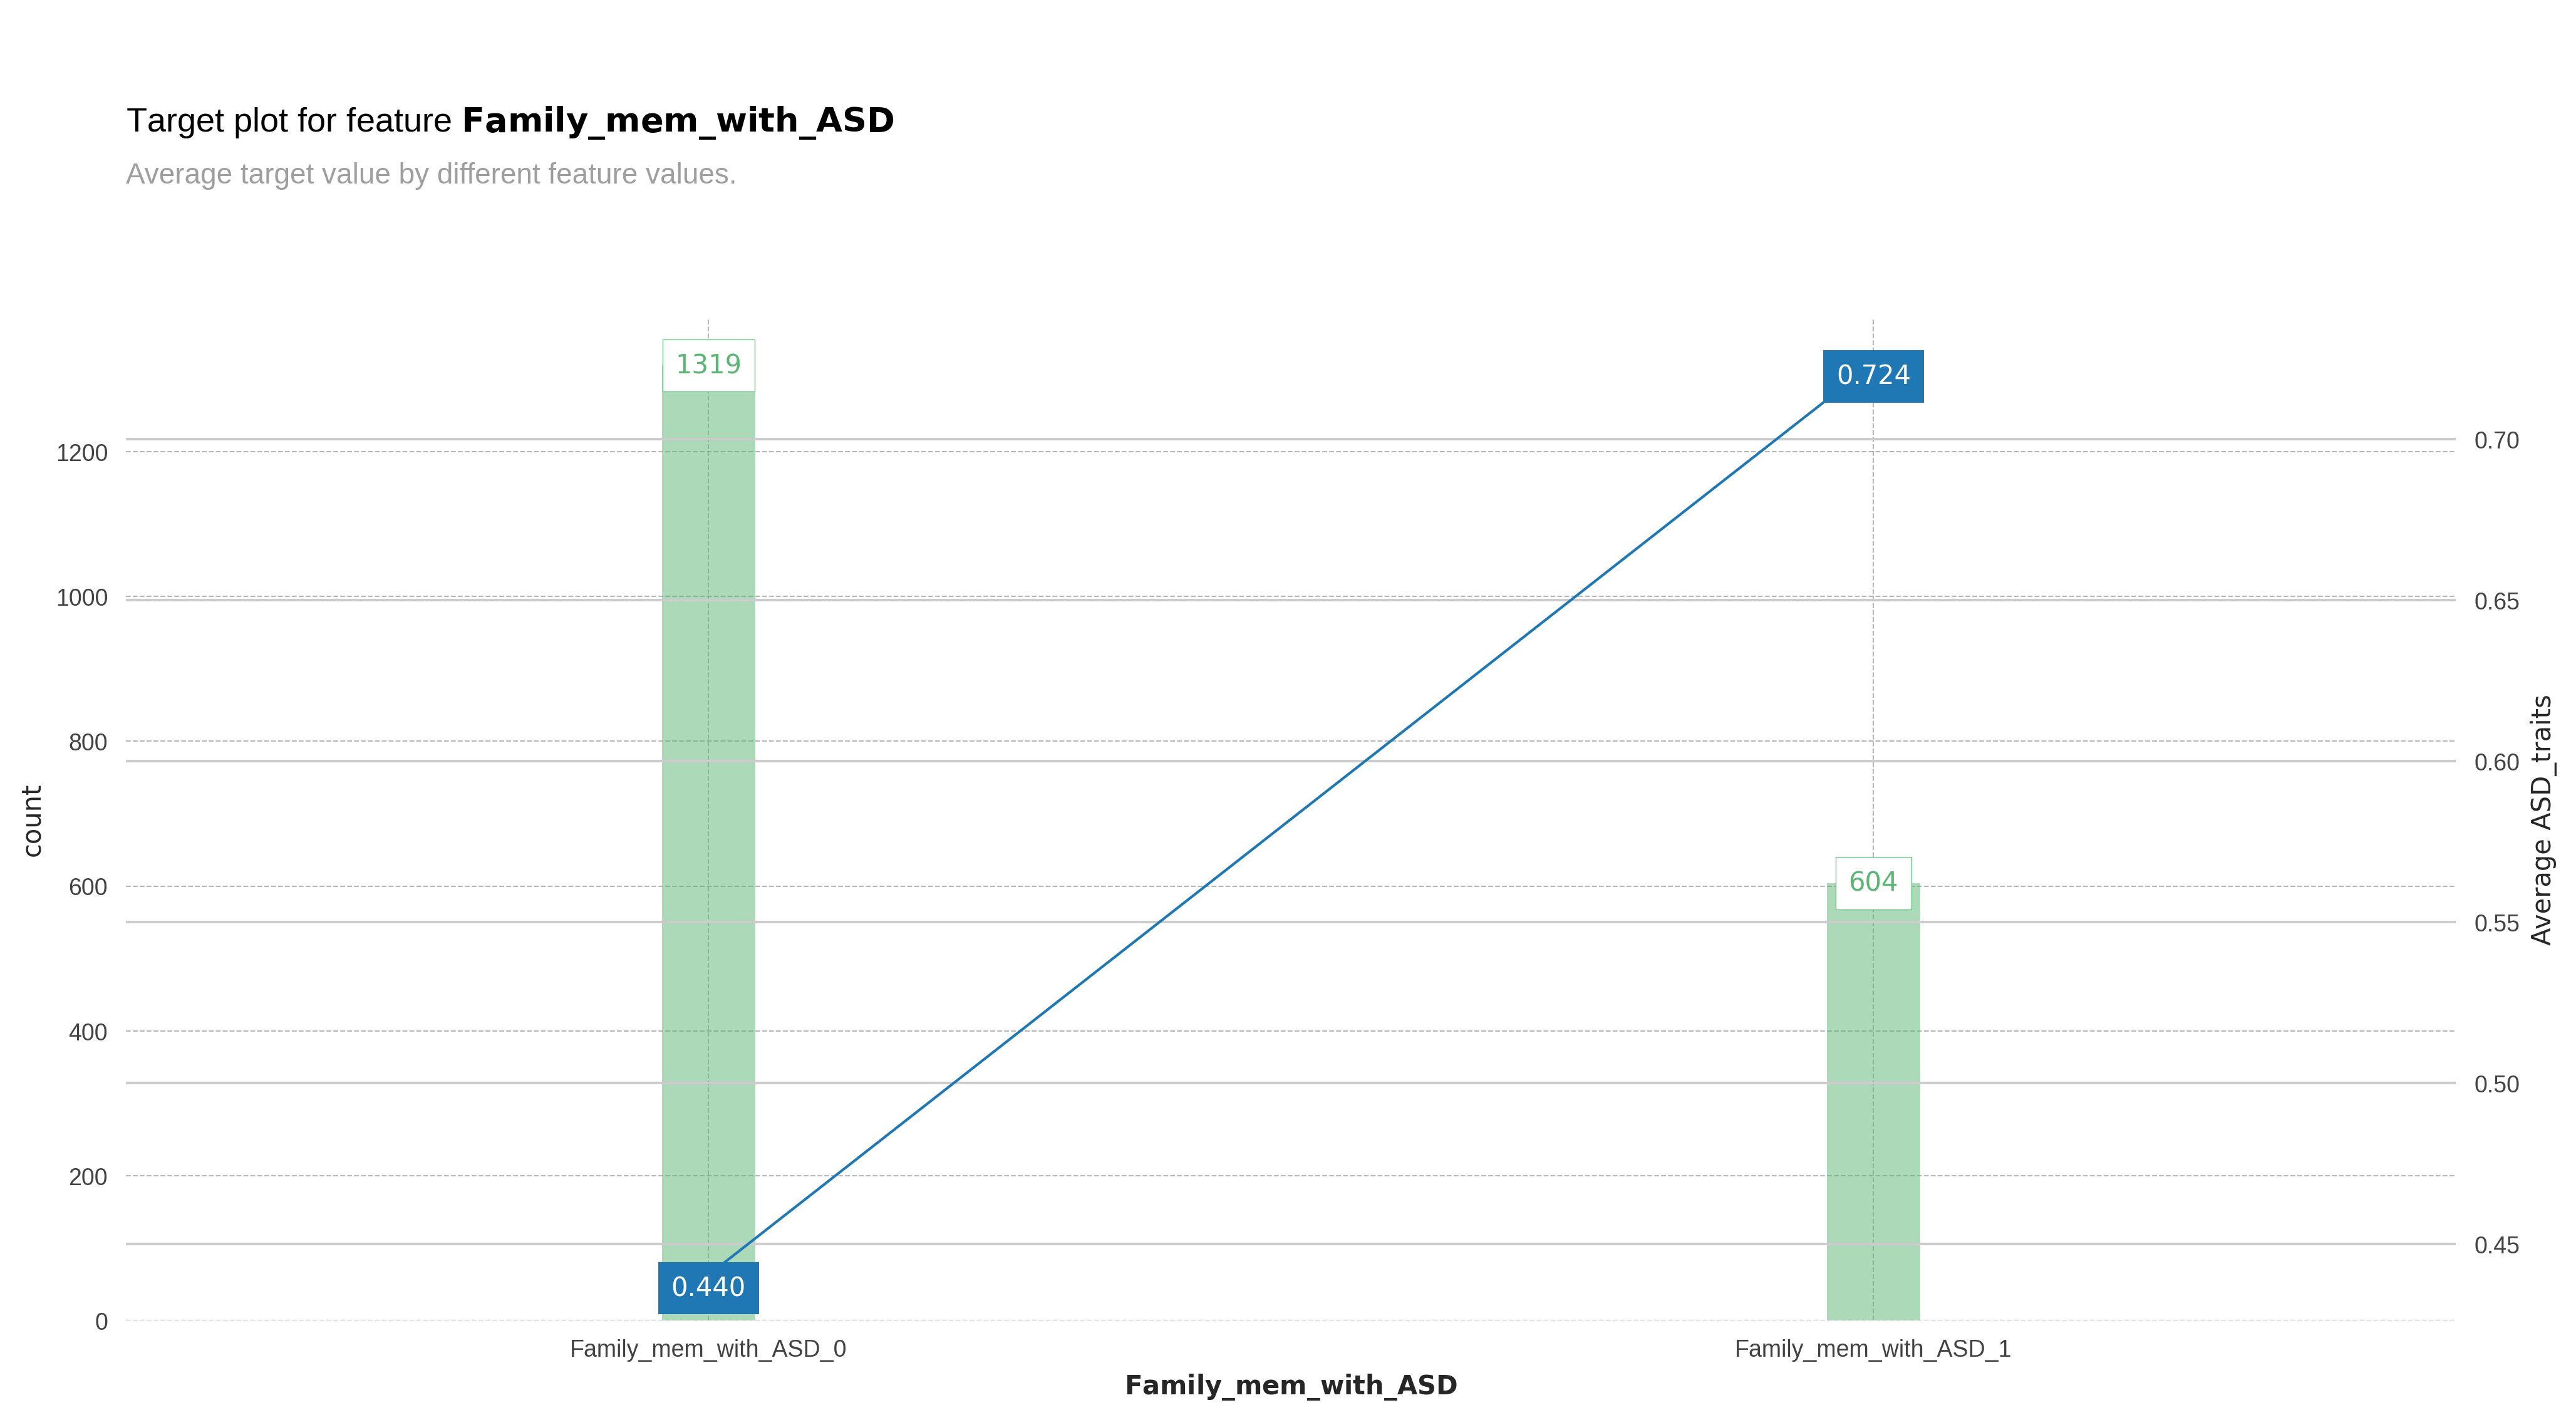

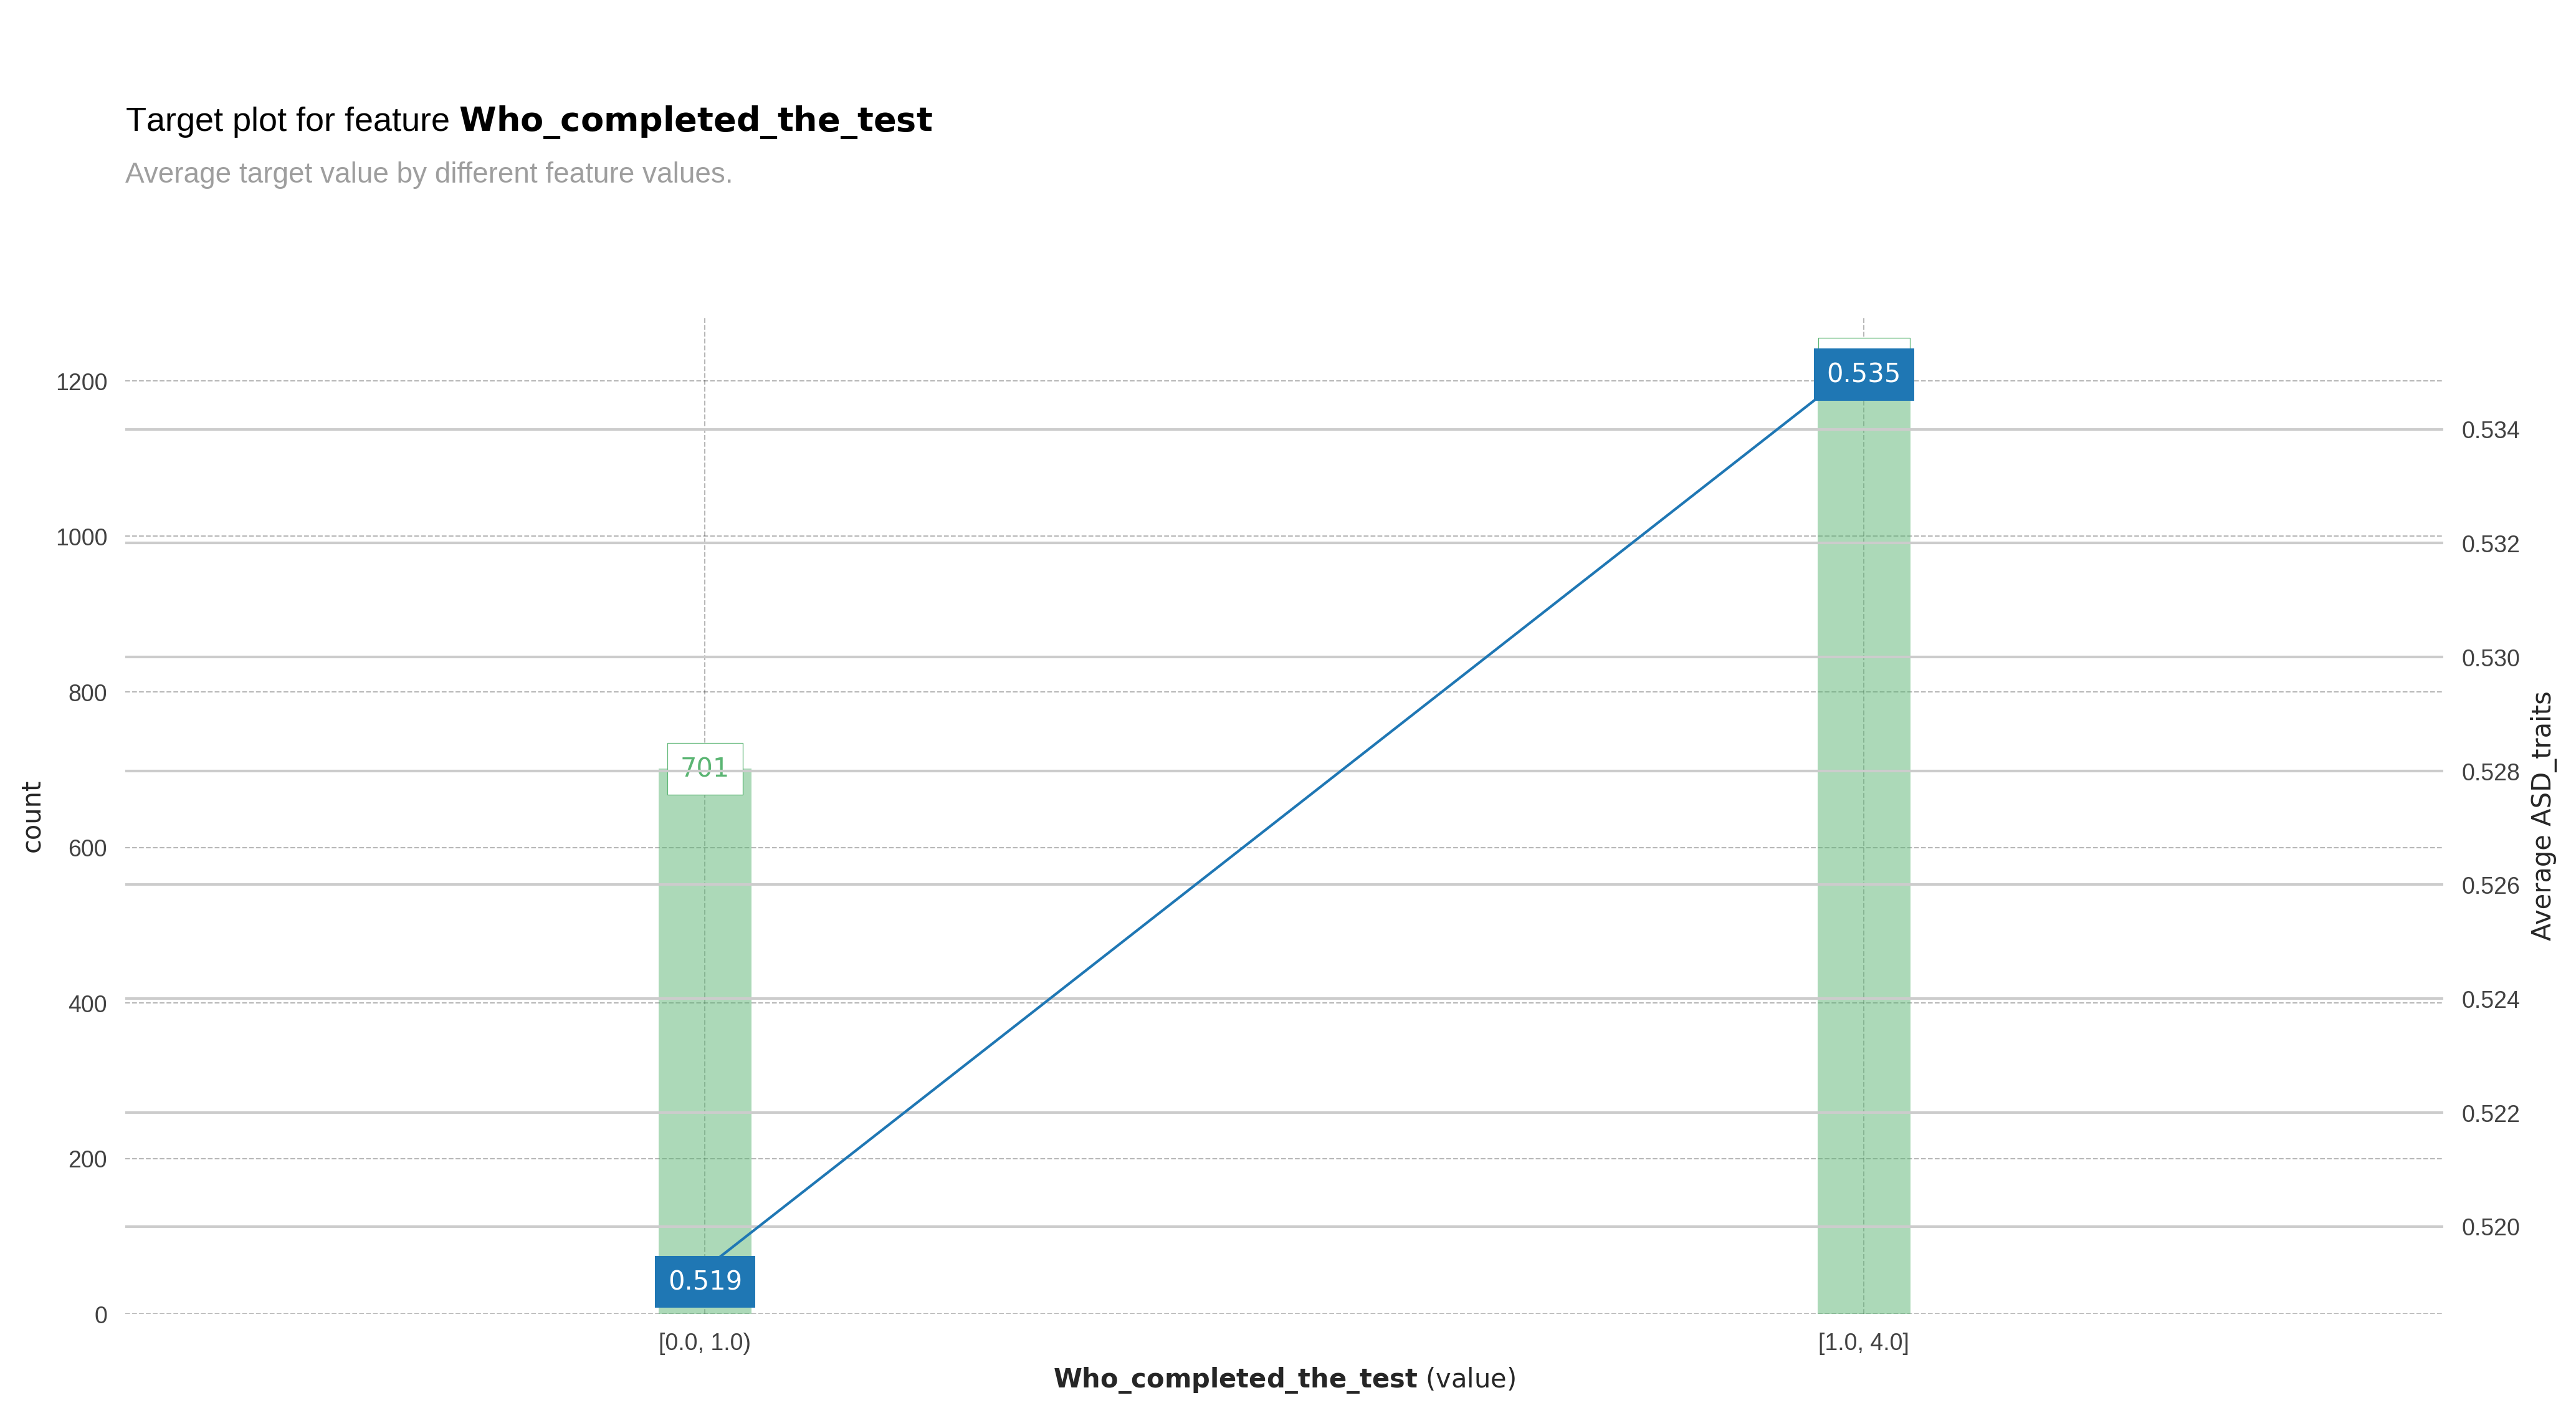

In [16]:
for feature in X_train.columns:
    target_lstat = info_plots.TargetPlot(
        df = pd.concat([X_train, y_train], axis=1),
        feature = feature,
        feature_name = feature,
        target = 'ASD_traits'
    )
    target_lstat.plot(engine='matplotlib')


### SHAP

In [17]:
X_train = dataset.drop('ASD_traits', axis=1)
y_train = dataset['ASD_traits']

print(X_train.columns)

Index(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9',
       'A10_Autism_Spectrum_Quotient', 'Social_Responsiveness_Scale',
       'Age_Years', 'Qchat_10_Score', 'Speech Delay/Language Disorder',
       'Learning disorder', 'Genetic_Disorders', 'Depression',
       'Global developmental delay/intellectual disability',
       'Social/Behavioural Issues', 'Childhood Autism Rating Scale',
       'Anxiety_disorder', 'Sex', 'Ethnicity', 'Jaundice',
       'Family_mem_with_ASD', 'Who_completed_the_test'],
      dtype='object')


In [18]:
rf = RandomForestRegressor(n_estimators = 100, random_state = seed, max_features='sqrt')
rf.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', random_state=10)

In [19]:
explainer = shap.Explainer(rf)
shap_values = explainer(X_train)

In [20]:
shap_values[0]

.values =
array([-3.91901217e-02, -2.38594389e-02, -1.59239470e-02, -2.92116897e-02,
       -3.60892889e-02, -3.47523226e-02,  7.91357390e-02,  6.06629694e-02,
       -4.80466150e-02,  6.75364131e-03,  5.09996999e-03,  1.13198621e-04,
       -2.74137248e-01,  7.18627121e-03, -3.56940692e-03, -6.40166103e-05,
       -1.08581595e-02,  1.45328556e-03, -3.07218427e-03,  2.70305563e-03,
       -5.65693925e-03, -4.05119046e-02, -4.30076670e-02,  6.05057623e-04,
       -1.53471656e-02, -1.05989909e-03])

.base_values =
0.5306448257930318

.data =
array([0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 3., 2., 3., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 4., 1., 0., 0.])

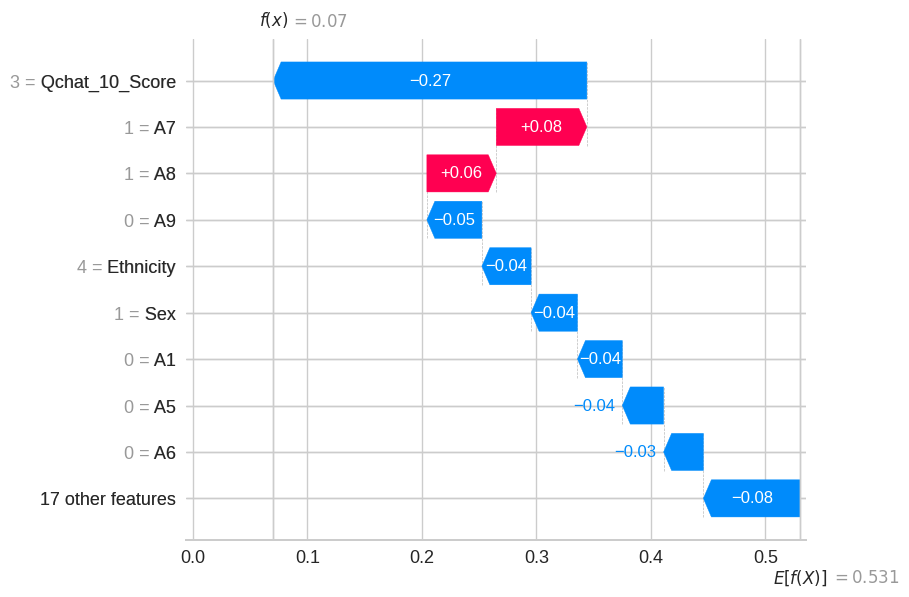

In [27]:
shap.plots.waterfall(shap_values[0])

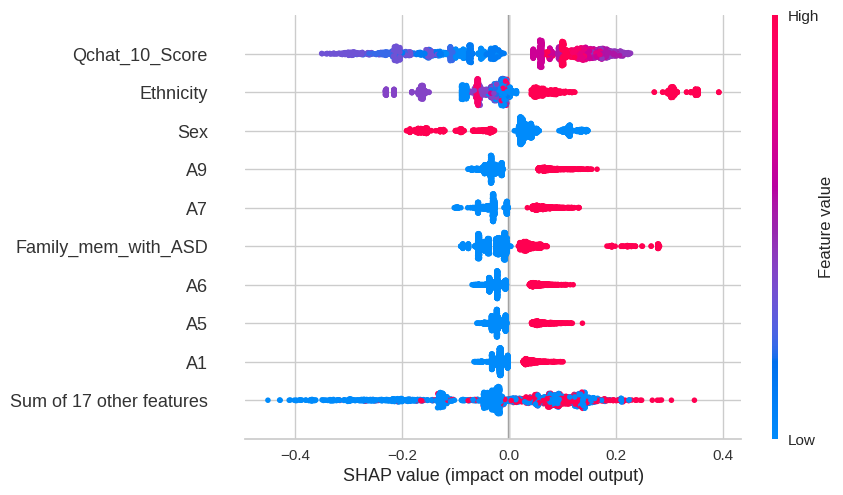

In [31]:
shap.plots.beeswarm(shap_values)

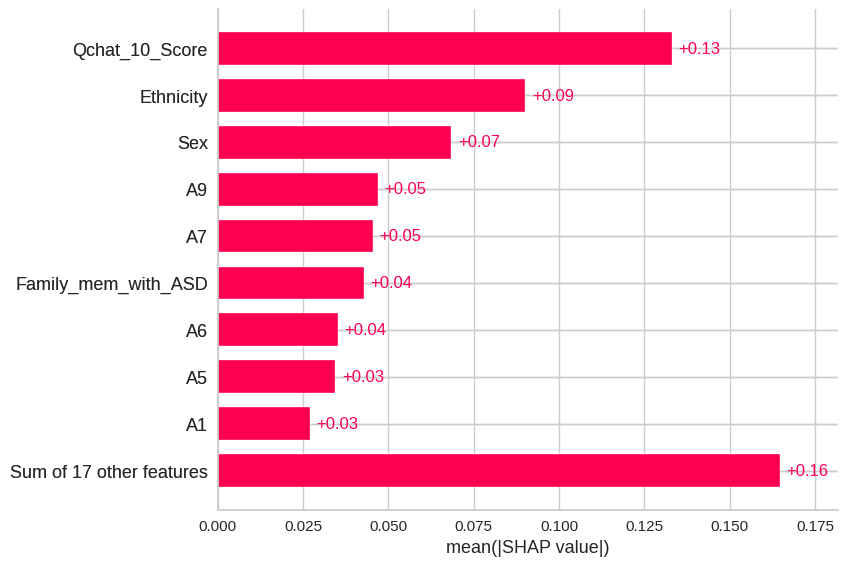

In [48]:
shap.plots.bar(shap_values)

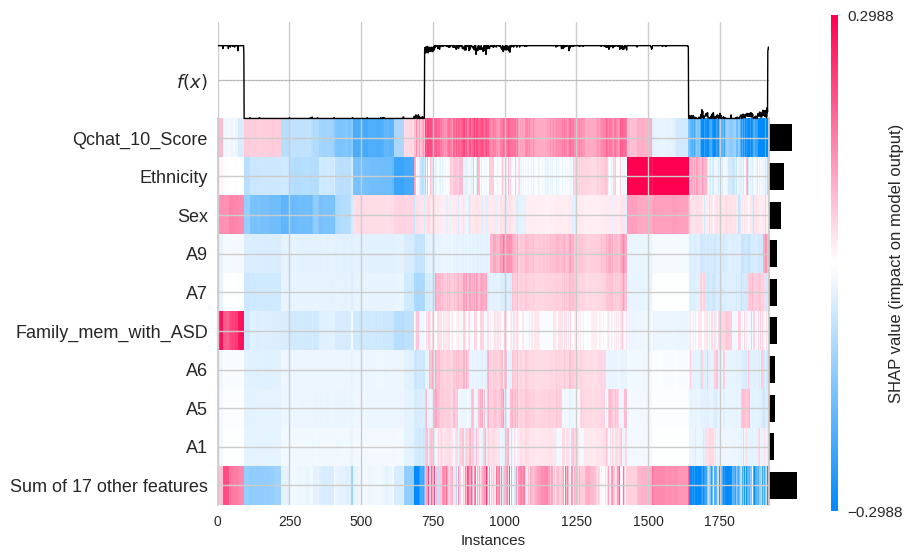

In [49]:
shap.plots.heatmap(shap_values)

## 분석 결과
세 분석 기법 모두 RandomForest 모델을 기반하여 분석 진행

### 변수 중요도
* `Qchat_10_Score`(Q-chat 검사의 총 점수) 변수와 `Ethnicity`(인종) 대한 중요도가 가장 높았음

### PDP
* Q-chat의 각 문항에 대한 변수들(`A1` ~ `A10`)에 각각 그렇다라고 응답한 경우 모델의 예측값에 더 큰 영향을 미침을 확인
* `Social_Responsiveness_Scale`(점수가 높을수록 사회적 기능이 낮음을 의미) 변수 또한 점수가 높을수록 모델의 예측값에 더 큰 영향을 미침을 확인
* `SpeechDelay/LanguageDisorder`(언어 지연/장애 여부), `LeanringDisorder`(학습 장애 여부), `Genetic_Disorders`(장애에 대한 유전 여부), `Depression`(우울감 여부), `Global developmental delay/intellectual disability`(전반적 발달 지연 및 지적 장애 여부), `Social/Behavioural Issues`(사회, 행동적 문제 여부), `Anxiety_disorder`(불안 장애 여부), `Jaundice`(황달 여부), `Family_mem_with_ASD`(가족 구성원 중 자폐를 가지고 있는지 여부) 모두 그렇다라고 응답한 경우 모델의 예측값에 더 큰 영향을 미침을 확인
* `Childhood Autism Rating Scale`(부모가 진행할 수 있는 자폐 진단 테스트 점수) 또한 점수가 높을수록 모델의 예측값에 더 큰 영향을 미침을 확인
* 마지막으로 성별 간 데이터 개수의 차이가 존재함에도 불구하고 남성일 때 모델의 예측값에 더 큰 영향을 미침을 확인

### SHAP
* `Qchat_10_Score` 변수와 Qchat 테스트의 각 문항에 대한 변수(`A1`~`A10`)가 모델 예측에 큰 영향이 있음을 확인